This is the code used for my BSc thesis in Harokopio University of Athens.

The sections denoted by **(*)** should **always** run.

# Preliminaries (*)
In this section, we:
* import the libraries used
* mount google drive
* create the agent class (in which we declare the movement etc)
* implement A*
* implement Flood Fill
* implement Dijkstra
* implement Wavefront


In [1]:
import os
import sys
import time
import copy
import random
import functools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from IPython import get_ipython
from scipy.spatial.distance import cdist
from PIL import Image
import re
import collections

from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def check_run_colab() -> bool:
    return bool('google.colab' in sys.modules)

# Check if the current environment is Google Colab
if check_run_colab():
    print("Running in Google Colab!")
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not running in Google Colab.")

Not running in Google Colab.


#### The Agent Class:

In [2]:
class Agent:

  def __init__(self, start: tuple, goal: tuple, real_stage, view_range=2):
      self.x = start[0]
      self.y = start[1]
      self.goal = goal
      self.view_range = view_range
      self.explored_stage = np.full_like(real_stage, -1)
      self.explored_stage[self.x, self.y] = 0
      self.agent_view(real_stage)
      self.start_time = time.time()
      self.u_hedac = None # hedac related parameter.
      # voronoi related parameters:
      self.voronoi_coords = None
      self.broadcast_range = max(real_stage.shape[0], real_stage.shape[1]) // 4
      self.visited_cells = np.zeros_like(real_stage)
      self.set_voronoi_goal = False


  def agent_view(self, real_stage):
    """ Refreshes the explored map of the agent (sees up, down, left, right). """
    up_obs, upleft_obs, upright_obs, down_obs, downleft_obs, downright_obs, left_obs, right_obs = False, False, False, False, False, False, False, False
    for i in range(self.view_range):
      if self.x > i:  # checks up
        tmp_x = self.x - i - 1
        if not up_obs:  # stops if it sees obstacle
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            up_obs = True
        if self.y > i and not upleft_obs:  # up-left
          if not upleft_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              upleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # up-right
          if not upright_obs:  # stops if it sees obstacle
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              upright_obs = True

      if self.x < len(real_stage) - i - 1:  # checks down:
        tmp_x = self.x + i + 1
        if not down_obs:
          self.explored_stage[(tmp_x, self.y)] = real_stage[(tmp_x, self.y)]
          if real_stage[(tmp_x, self.y)]:
            down_obs = True
        if self.y > i:  # down-left
          if not downleft_obs:
            self.explored_stage[(tmp_x, self.y - i - 1)] = real_stage[(tmp_x, self.y - i - 1)]
            if real_stage[(tmp_x, self.y - i - 1)]:
              downleft_obs = True
        if self.y < len(real_stage[0]) - i - 1: # down-right
          if not downright_obs:
            self.explored_stage[(tmp_x, self.y + i + 1)] = real_stage[(tmp_x, self.y + i + 1)]
            if real_stage[(tmp_x, self.y + i + 1)]:
              downright_obs = True

      if self.y > i and not left_obs:  # left (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y - i - 1)] = real_stage[(self.x, self.y - i - 1)]
        if real_stage[(self.x, self.y - i - 1)]:
          left_obs = True

      if self.y < len(real_stage[0]) - i - 1 and not right_obs: # right (& stops if it sees obstacle)
        self.explored_stage[(self.x, self.y + i + 1)] = real_stage[(self.x, self.y + i + 1)]
        if real_stage[(self.x, self.y + i + 1)]:
          right_obs = True

    self.explored_stage[self.explored_stage == 2] = 0

  def check_goal(self):
    if (self.x, self.y) == self.goal:
      return True
    return False

#### **A\* Algorithm** (source [here](https://pypi.org/project/python-astar/)): Produces a path from start to end using A\*.

In [3]:
"""
Python-astar - A* path search algorithm
"""

class Tile:
    """A tile is a walkable space on a map."""
    distance = 0
    came_from = None

    def __init__(self, x, y, weight=1):
        self.x = x
        self.y = y
        self.weight = 1
        assert (self.x is not None and self.y is not None)

    def update_origin(self, came_from):
        """Update which tile this one came from."""
        self.came_from = came_from
        self.distance = came_from.distance + self.weight

    def __eq__(self, other):
        """A tile is the same if they have the same position"""
        return (other and self.x == other.x and self.y == other.y)

    def __lt__(self, other):
        """We want the shortest distance tile to find the happy path.
        This is used by min() so we can just compare them :)
        """
        return (self.distance + self.weight <= other.distance)

    def __hash__(self):
        """We need this so we can use a set()"""
        return hash(str(self))

    @property
    def pos(self):
        """a (x, y) tuple with position on the grid"""
        return (self.x, self.y)

    def __str__(self):
        return str(self.pos)

    def __repr__(self):
        return str(self)


class AStar:
    """The A Star (A*) path search algorithm"""

    def __init__(self, world, coverage_mode: bool = False):
        world2 = copy.deepcopy(world)
        world2[world2 == -1] = 0
        if coverage_mode: # coverage_mode == different goals.
          world2[world2 == 2] = 1 # astar takes agents into account.
        else:
          world2[world2 == 2] = 0
        self.world = world2

    def search(self, start_pos, target_pos):
        """A_Star (A*) path search algorithm"""
        start = Tile(*start_pos)
        self.open_tiles = set([start])
        self.closed_tiles = set()

        # while we still have tiles to search
        while len(self.open_tiles) > 0:
            # get the tile with the shortest distance
            tile = min(self.open_tiles)
            # check if we're there. Happy path!
            if tile.pos == target_pos:
                return self.rebuild_path(tile)
            # search new ways in the neighbor's tiles.
            self.search_for_tiles(tile)

            self.close_tile(tile)
        # if we got here, path is blocked :(
        return None

    def search_for_tiles(self, current):
        """Search for new tiles in the maze"""
        for other in self.get_neighbors(current):
            if self.is_new_tile(other):
                other.update_origin(current)
                self.open_tiles.add(other)

            # if this other has gone a farthest distance before
            #   then we just found a new and shortest way to it.
            elif other > current:
                other.update_origin(current)
                if other in self.closed_tiles:
                    self.reopen_tile(other)

    def get_neighbors(self, tile):
        """Return a list of available tiles around a given tile"""
        min_x = max(0, tile.x - 1)
        max_x = min(len(self.world)-1, tile.x + 1)
        min_y = max(0, tile.y - 1)
        max_y = min(len(self.world[tile.x])-1, tile.y + 1)

        available_tiles = [
            (min_x, tile.y),
            (max_x, tile.y),
            (tile.x, min_y),
            (tile.x, max_y),
        ]
        neighbors = []
        for x, y in available_tiles:
            if (x, y) == tile.pos:
                continue

            if self.world[x][y] == 0:
                neighbors.append(Tile(x, y))

        return neighbors

    def rebuild_path(self, current):
        """Rebuild the path from each tile"""
        self.last_tile = current
        path = []
        while current is not None:
            path.append(current)
            current = current.came_from
        path.reverse()
        # return a list with tuples
        return [tile.pos for tile in path]

    def is_new_tile(self, tile):
        """Check if this is a proviously unknown tile"""
        return (
            tile not in self.open_tiles
            and tile not in self.closed_tiles
        )

    def reopen_tile(self, tile):
        """Reinstate a tile in the open list"""
        self.closed_tiles.remove(tile)
        self.open_tiles.add(tile)

    def close_tile(self, tile):
        """Remove tile from open_tiles, as we are done testing it"""
        self.open_tiles.remove(tile)
        self.closed_tiles.add(tile)

#### **Flood Fill**

In [4]:
def flood_fill(expl_maze, start, agent_obs=True):
    # function inputs: expl_maze = explored maze of agent, start = the position of the agent.
    maze = copy.deepcopy(expl_maze)
    if agent_obs:   # agents are obstacle.
        maze = np.where(maze == 2, 1, maze)
    else:   # agents are not obstacles
        maze = np.where(maze == 2, 0, maze)
    maze = np.where(maze == 2, 1, maze)
    maze = np.where(maze == -1, 0, maze)
    distances = np.full_like(maze, fill_value=np.iinfo(np.int32).max, dtype=np.float64)
    distances[start] = 0
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    def fill(x, y, distance):
        distances[x, y] = distance
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1]:
                if maze[nx, ny] == 0 and distances[nx, ny] > distance + 1:
                    fill(nx, ny, distance + 1)
    fill(start[0], start[1], 0)
    distances[distances == np.iinfo(np.int32).max] = np.inf

    # if no where left to go, stays where it is. Else, goes away from start pos.
    distances[start] = np.inf
    if np.all(distances == np.inf):
        distances[start] = 0

    return distances

In [5]:
def flood_fill_path(start_grid, start, end):
    """Returns a path representing the shortest flood fill path."""
    grid = copy.deepcopy(start_grid)
    grid = np.where(grid == 2, 1, grid)
    grid = np.where(grid == -1, 0, grid)
    rows, cols = grid.shape
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    
    # Queue for flood fill exploration
    queue = collections.deque([start])
    
    # Distance map to keep track of shortest known distance from start
    distances = np.inf * np.ones((rows, cols))
    distances[start] = 0
    
    # Perform flood fill exploration
    while queue:
        x, y = queue.popleft()
        
        if (x, y) == end:
            break
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_distance = distances[x, y] + 1
                
                if new_distance < distances[nx, ny]:
                    distances[nx, ny] = new_distance
                    queue.append((nx, ny))
    
    # Check if end coordinate is reachable
    if distances[end] == np.inf:
        return None  # No path found
    
    # Reconstruct path from end to start using shortest distance
    path = []
    current = end
    
    while current != start:
        path.append(current)
        x, y = current
        
        # Find the neighbor with the shortest distance
        min_distance = np.inf
        next_step = None
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < rows and 0 <= ny < cols and distances[nx, ny] < min_distance:
                min_distance = distances[nx, ny]
                next_step = (nx, ny)
        
        current = next_step
    
    path.append(start)
    path.reverse()
    
    return path

#### **Dijkstra**

In [6]:
import heapq

def dijkstra_path(start_grid, start, end):
    grid = copy.deepcopy(start_grid)
    grid = np.where(grid == 2, 1, grid)
    grid = np.where(grid == -1, 0, grid)
    rows, cols = grid.shape
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    
    # Priority queue for Dijkstra's algorithm
    pq = []
    heapq.heappush(pq, (0, start))  # (cost, (x, y))
    
    # Distance map to keep track of shortest distances from start
    distances = np.inf * np.ones((rows, cols))
    distances[start] = 0
    
    # Parent map to reconstruct the path
    parent = {}
    
    while pq:
        current_cost, (x, y) = heapq.heappop(pq)
        
        if (x, y) == end:
            break
        
        # Explore neighbors
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_cost = current_cost + 1  # Assuming each move has cost 1
                
                if new_cost < distances[nx, ny]:
                    distances[nx, ny] = new_cost
                    heapq.heappush(pq, (new_cost, (nx, ny)))
                    parent[(nx, ny)] = (x, y)
    
    # Reconstruct path from end to start using parent map
    path = []
    if (end in parent) or end == start:
        step = end
        while step in parent:
            path.append(step)
            step = parent[step]
        path.append(start)
        path.reverse()
    
    return path if path else None


In [7]:
def dijkstra(start_grid, start):
    grid = copy.deepcopy(start_grid)
    grid = np.where(grid == 2, 1, grid)
    grid = np.where(grid == -1, 0, grid)
    rows, cols = grid.shape
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    
    # Priority queue for Dijkstra's algorithm
    pq = []
    heapq.heappush(pq, (0, start))  # (cost, (x, y))
    
    # Distance matrix to store shortest distances from the start point
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0  # Distance to the start point is 0
    
    # Perform Dijkstra's algorithm
    while pq:
        current_cost, (x, y) = heapq.heappop(pq)
        
        # If the popped node's cost exceeds its current recorded cost, skip
        if current_cost > distances[x, y]:
            continue
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_cost = current_cost + 1  # Assuming each move has cost 1
                
                if new_cost < distances[nx, ny]:
                    distances[nx, ny] = new_cost
                    heapq.heappush(pq, (new_cost, (nx, ny)))

    return distances

#### **Wavefront**

In [8]:
def wavefront(start_grid, start, agent_obs=True):
    grid = copy.deepcopy(start_grid)
    if agent_obs:   # agents are obstacle.
        grid = np.where(grid == 2, 1, grid)
    else:   # agents are not obstacles
        grid = np.where(grid == 2, 0, grid)
    grid = np.where(grid == -1, 0, grid)
    rows, cols = grid.shape
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    
    # Queue for wavefront expansion
    queue = collections.deque([start])
    
    # Distance matrix to store shortest distances from the end point
    distances = np.full((rows, cols), np.inf)
    distances[start] = 0  # Distance to the end point is 0
    
    # Perform wavefront propagation
    while queue:
        x, y = queue.popleft()
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < rows and 0 <= ny < cols and grid[nx, ny] == 0:
                new_distance = distances[x, y] + 1
                
                if new_distance < distances[nx, ny]:
                    distances[nx, ny] = new_distance
                    queue.append((nx, ny))

    return distances

In [9]:
from queue import Queue

def wavefront_path(start_grid, start, end):
    grid = copy.deepcopy(start_grid)
    grid = np.where(grid == 2, 1, grid)
    grid = np.where(grid == -1, 0, grid)
    rows, cols = grid.shape
    visited = np.zeros_like(grid)
    queue = Queue()
    queue.put(start)
    visited[start] = 1

    while not queue.empty():
        current = queue.get()
        if current == end:
            break

        for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            r, c = current[0] + dr, current[1] + dc
            if 0 <= r < rows and 0 <= c < cols and grid[r, c] == 0 and visited[r, c] == 0:
                queue.put((r, c))
                visited[r, c] = visited[current] + 1

    if visited[end] == 0:
        return None

    # Reconstruct the path
    path = [end]
    while path[-1] != start:
        for dr, dc in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            r, c = path[-1][0] + dr, path[-1][1] + dc
            if 0 <= r < rows and 0 <= c < cols and visited[r, c] == visited[path[-1]] - 1:
                path.append((r, c))
                break

    return path[::-1]  # Reverse the path to start from start


# Stage/Maze (*)
This section contains code for:
* plot the stage/maze
* creation of gifs (that show the exploration process)
* simple stage creation
* maze creation
* agent generation (on stage)
* update of agent explored stage
* maze exploration metrics (from the paper *Yan, Z., Fabresse, L., Laval, J., & Bouraqadi, N. (2015, September). Metrics for performance benchmarking of multi-robot exploration. In 2015 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS) (pp. 3407-3414). IEEE*)

Function to plot the grid/maze:

In [10]:
def draw_maze(maze, path=None, goal=None, save_gif=False, numbered=False):
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
        ax.scatter(path[-1][1], path[-1][0], color='red', s=100, marker='s')

    if goal is not None:
        ax.scatter(goal[1], goal[0], color='red', s=100, marker='s')

    if numbered:
        for i in range(maze.shape[0]):
            for j in range(maze.shape[1]):
                cell_number = maze[i, j]
                ax.text(j, i, str(int(cell_number)), color='black', ha='center', va='center', fontsize=10)

    ax.set_xticks([])
    ax.set_yticks([])

    # Saves images to folder ========================
    if save_gif:
        if not os.path.exists("tmp_img"):
            os.makedirs("tmp_img")
        filepath = os.path.join("tmp_img", f"{time.time()}.png")
        plt.savefig(filepath)
    # =============================================

    plt.show()

In [11]:
from matplotlib.colors import ListedColormap, Normalize

def draw_maze_voronoi(v_map, agent_explored=None, path=None, goal=None, save_gif=False):
    unique_values = np.unique(v_map)
    # print(len(unique_values))
    if len(unique_values) > 11:
        print("Colored plot not supported for more than 10 agents. Plotting in grayscale:")
        draw_maze(v_map, path, goal, save_gif) if agent_explored is None else draw_maze(agent_explored, path, goal, save_gif)
        return

    tmp_v_map = copy.deepcopy(v_map)
    fig, ax = plt.subplots(figsize=(10,10))

    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    if agent_explored is not None:
        tmp_v_map[agent_explored == 1] = -1  # obstacles -> gray
        tmp_v_map[agent_explored == -1] = -2    # unexplored areas -> white
        tmp_v_map[agent_explored == 2] = -3 # agents -> black
    color_dict = {-3: 'black', -2: 'white', -1: '#555555', 0: "blue", 1: "brown", 2: "green", 3: "purple", 4: "orange", 5: "cyan", 6: "magenta", 7: "yellow", 8: "lime", 9: "pink"}
    # else:
    #     color_dict = {-1: 'darkgray', 0: "blue", 1: "brown", 2: "green", 3: "purple", 4: "orange", 5: "cyan", 6: "magenta", 7: "yellow", 8: "lime", 9: "pink"}

    colors = [color_dict[val] for val in sorted(color_dict.keys())]
    cmap = ListedColormap(colors)

    norm = Normalize(vmin=min(color_dict.keys()), vmax=max(color_dict.keys()))

    plt.imshow(tmp_v_map, cmap=cmap, norm=norm, interpolation='nearest')
    # if agent_explored is None:
    #     plt.colorbar()

    if path is not None:
        x_coords = [x[1] for x in path]
        y_coords = [y[0] for y in path]
        ax.plot(x_coords, y_coords, color='red', linewidth=2)
        ax.scatter(path[-1][1], path[-1][0], color='red', s=100, marker='s')

    if goal is not None:
        ax.scatter(goal[1], goal[0], color='red', s=100, marker='s')

    ax.set_xticks([])
    ax.set_yticks([])

    # Saves images to folder ========================
    if save_gif:
        if not os.path.exists("tmp_img"):
            os.makedirs("tmp_img")
        filepath = os.path.join("tmp_img", f"{time.time()}.png")
        plt.savefig(filepath)
    # =============================================

    plt.show()
    # print("---------------")

Function to convert images to gifs.

In [12]:
def images_to_gif(gif_filename=f"maze_{time.time()}.gif", duration=300, image_folder="tmp_img", gif_folder="utils"):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.png') and os.path.isfile(os.path.join(image_folder, f))]
    
    image_files.sort()
    
    images = []
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        images.append(image)
        
    gif_filepath = os.path.join(gif_folder, gif_filename)
    images[0].save(gif_filepath, save_all=True, append_images=images[1:], loop=0, duration=duration)
    
    for image_file in image_files:
        os.remove(os.path.join(image_folder, image_file))
    time.sleep(1)



Create a stage with obstacles (1) and free path (0).

In [13]:
def generate_stage(rows: int, cols: int, obs_prob = 0.2):

  # generate obstacles with obs_prob probability
  num_obstacles = int(rows * cols * obs_prob)

  stage = np.full((rows, cols), 0)

  # Set 1s at random positions for the specified percentage
  indices = np.random.choice(rows * cols, num_obstacles, replace=False)
  stage.flat[indices] = 1

  return stage

Function for maze creation. [Source](https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96).

In [14]:
def create_maze(rows, cols, obs_prob=0.8):
    rows = int(rows / 2)
    cols = int(cols / 2)

    maze = np.ones((rows*2+1, cols*2+1))

    x, y = (0, 0)

    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < rows and ny < cols and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()

    zero_indices = np.argwhere(maze == 0)
    zero_coords = [tuple(index) for index in zero_indices]

    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)] # adds randomly crosses of free space.
    for z in zero_coords:
       if random.random() >= obs_prob:
          for dx, dy in directions:
            nx, ny = z[0] + dx, z[1] + dy
            maze[nx, ny] = 0

    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1

    # removes crosses (so agents wont be stuck).
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            walls = []
            for d in directions:
                neighbor_i = i + d[0]
                neighbor_j = j + d[1]
                # Check if neighbor is in bounds
                if 0 <= neighbor_i < maze.shape[0] and 0 <= neighbor_j < maze.shape[1] and maze[(neighbor_i, neighbor_j)]:
                    walls.append((neighbor_i, neighbor_j))
            if len(walls) >= len(directions):
                for coord in walls:
                    maze[coord] = 0

    # re-adds the boundaries (after cross removed).
    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1
    # draw_maze(maze)

    return maze

 Creates the "explored" stage, which at the start everything is not explored (-1) and put the agents there (2).

In [15]:
def generate_agents(real_stage, num_agents: int = 1, view_range: int = 2, coverage_mode: bool = False):

  agents = []

  if num_agents <= 0:
    num_agents = 1

  zero_coordinates = list(zip(*np.where(real_stage == 0)))
  goal = random.choice(zero_coordinates)
  zero_coordinates.remove(goal)
  # Create the "explored" stage
  for _ in range(num_agents):
    if zero_coordinates:
      start = random.choice(zero_coordinates)
      zero_coordinates.remove(start)
      agents.append(Agent((start[0], start[1]), (goal[0], goal[1]), real_stage, view_range))
      if coverage_mode: # puts different goals
        goal = random.choice(zero_coordinates)
        zero_coordinates.remove(goal)
    else:
      break

  return agents

Function to concat all agents explored stages (returns the total explored stage):

In [16]:
def update_total_explored(agents, coverage_mode=False, agents_not_in_range=False):
  if len(agents) == 0:
    return

  total_explored = np.full(agents[0].explored_stage.shape, -1)

  # fills the border with 1s
  total_explored[0, :] = 1
  total_explored[-1, :] = 1
  total_explored[:, 0] = 1
  total_explored[:, -1] = 1

  for a in agents:
    total_explored[total_explored == -1] = a.explored_stage[total_explored == -1]
    total_explored[total_explored == 2] = 0

  for a in agents:
    if coverage_mode: # agents never leave the stage when coverage mode.
      total_explored[a.x, a.y] = 2
    elif not a.check_goal():  # if agent has reached goal -> collidable (as if it is removed from the stage).
      total_explored[a.x, a.y] = 2

  if not agents_not_in_range:  # if agents are in range, shares info (THIS IS USED ONLY IN VORONOI MODE).
    # Total explored contains the concats of all agents stages:
    for a in agents:
      a.explored_stage = copy.deepcopy(total_explored)

  return total_explored

Function to return only the unexplored coords assigned by voronoi method **for each agent**. This method is used only in voronoi coverage.

In [17]:
def find_unexp_voronoi(agent):
    unexp_vor_coords = []
    for v_coord in list(agent.voronoi_coords):
        if v_coord != (agent.x, agent.y) and agent.explored_stage[v_coord] == -1:
            unexp_vor_coords.append(v_coord)

    return np.array(unexp_vor_coords)

### Maze Exploration Metrics

<u>Citation:</u> Yan, Z., Fabresse, L., Laval, J., & Bouraqadi, N. (2015, September). Metrics for performance benchmarking of multi-robot exploration. In 2015 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS) (pp. 3407-3414). IEEE

Here follow some metrics discussed in the paper and used in our experiments.

#### Exploration Time:

Calculates the exploration time, from start to entire maze coverage. For our implementation, the agents run sequentially, thats why to calculate the exploration time, we use the following formula:

$$
explorationTime(n) = \frac{\sum_{i=1}^{n} t_{s_i}}{n} \cdot R
$$

where $t_{s_i}$ is the time needed for an agent to make a step, $R$ is the number of rounds, and $n$ is the number of robots.


#### Map Completeness:

**Calculates the explored percentage of the total explored stage**. According to the paper [above](https://yzrobot.github.io/publications/yz15iros.pdf), it is based on the formula:
$$
mapCompleteness = M / P
$$
where $M$ is the amount of explored area and $P$ the total area of ground truth map.

This method is used throughout the maze exploration process, to see at which stage of the exploration we are.

In [18]:
def calculate_expl_percentage(total_explored):
  subarray = total_explored[1:-1, 1:-1] # gets all rows and columns except from the borders (agents already know they are obstacles).
  num_minus_1 = np.sum(subarray == -1)  # gets the unexplored areas.
  explored_percentage = 1 - (num_minus_1 / (subarray.shape[0] * subarray.shape[1]))
  return explored_percentage  # equals to M / P of paper.

#### Map Quality:

**Function for calculating the final difference of the real grid and the total explored grid.** According to the paper [above](https://yzrobot.github.io/publications/yz15iros.pdf), it is based on the formula:
$$
mapQuality = \frac{M - A(\text{mapError})}{P}
$$

where $M$ is the total explored area in square meters, $P$ the total area of ground truth map and $A(mapError)$ is the area occupied by the error cells. The error cells are the cells in the explored grid map that have a different value from the corresponding cell in the ground truth map.

**`Map Quality` is a superset from `Map Completeness`. That's why this is what is returned as metric in the conclusion of the maze exploration experiment.**

In [19]:
def check_real_expl(real_grid, total_explored, debug=False):
  total_explored = np.where(total_explored == -1, 1, total_explored)  # converts all unexplored to 1s.
  expl_perc = calculate_expl_percentage(total_explored)
  # the borders of the maze are removed from the above calculation (bc the agents already know they are obstacles,
  # thats why we dont calculate them). To continue in the same logic, we also remove borders below.

  real = copy.deepcopy(real_grid[1:-1, 1:-1])
  real = np.where(real == 2, 0, real)
  tot = copy.deepcopy(total_explored[1:-1, 1:-1])
  tot = np.where(tot == 2, 0, tot)
  tot = np.where(tot == -1, 1, tot)

  false_positions = np.where(np.not_equal(real, tot))[0]
  total_false = np.sum(np.not_equal(real, tot)) / (real_grid.shape[0] * real_grid.shape[1])

  if debug: # print statements:
    if total_false == 0:
      print("Real == Explored? TRUE")
    else:
      print("Real == Explored? FALSE")
      print("Positions of False values:", false_positions)
      draw_maze(real)
      draw_maze(tot)
  return false_positions, expl_perc - total_false

#### Exploration Cost

**Function for calculating the cost of the exploration.** According to the paper [above](https://yzrobot.github.io/publications/yz15iros.pdf), it is based on the formula:
$$
explorationCost(n) = \sum_{i=1}^{n} d_i
$$
where $n$ is the number of robots in the fleet, and $d_i$ is the distance traveled by robot $i$.

**This metric is calculated in the corresponding coverage execution functions.**

#### Exploration Efficiency


**Function for calculating the efficienct of the exploration.** According to the paper [above](https://yzrobot.github.io/publications/yz15iros.pdf), it is based on the formula:
$$
explorationEfficiency(n) = \frac{M}{explorationCost(n)}
$$
where $n$ is the number of robots in the fleet and $M$ is the total explored area in square meters.

In [20]:
def calc_exploration_efficiency(total_explored, sum_d):
    tot = copy.deepcopy(total_explored[1:-1, 1:-1])
    tot = np.where(tot == 2, 0, tot)
    tot = np.where(tot == -1, 1, tot)
    if sum_d == 0:
        sum_d = 1
    return np.count_nonzero(tot >= 0) / sum_d

# Agents Move Towards one Goal (*)
This section **does not explore the entire stage**. It was made for agents to move to a specific goal.
This should run because it is used later in the code (**not in the thesis though**).

Function for testing astar:

In [21]:
def move_astar(start_grid, start_agents, debug=True):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents)
  total_agents = len(agents)
  # print(total_agents)
  round_time_list = []
  avg_rounds = []
  num_finish = 0

  rounds = 0
  while any((agent.x, agent.y) != agent.goal for agent in agents):
      rounds+=1
      eps_start_time = time.time()
      path_none = 0
      for agent in agents:
          if agent.check_goal():
              num_finish += 1
              total_explored = update_total_explored(agents)
              agents.remove(agent)
              avg_rounds.append(rounds)
              continue  # Agent has reached its goal

          path = AStar(agent.explored_stage).search((agent.x, agent.y), agent.goal)
          if debug:
            draw_maze(agent.explored_stage, path=path)

          if path:
              if agent.explored_stage[path[1]] != 2:
                grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
                agent.x, agent.y = path[1]  # Update agent position
                grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
                # if agent.check_goal():
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents)
      round_time_list.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  for agent in agents:  # gets the time of some finished agents (that have not been counted),
    if agent.check_goal():
      num_finish += 1
      avg_rounds.append(rounds)

  return calculate_expl_percentage(total_explored), rounds, np.mean(avg_rounds), np.sum(round_time_list), num_finish / total_agents, total_explored

# Agents Explore Stage (*)
**This section is researched in my thesis.** It contains the algorithms used for maze exploration (HEDAC, nearest frontier, etc). Also, it proposes new method(s) for maze exploration.

## **HEDAC**: Uses Artificial Potential Fields for maze exploration.
<u>Citation:</u> Crnković, B., Ivić, S., & Zovko, M. (2023). Fast algorithm for centralized multi-agent maze exploration. arXiv preprint arXiv:2310.02121 [[source](https://arxiv.org/pdf/2310.02121.pdf)].

For calculation of HEDAC, we iteratively calculate the following:

$$
u_{i,j}^{r+1} = \frac{\sum_{l \in L} a_{i,j}(l)u_{l}^{r} + s(x_{i,j}, t_k)}{\sum_{l \in L} a_{i,j}(l) + \alpha}, \text{ where } r \text{ = iterations until convergence.}
$$

And:

$$
L = \{(i+1, j), (i-1, j), (i, j+1), (i, j-1)\}, \text{ denotes the neighboring nodes of (i, j).} 
$$

So:

$$
a_{i,j}(l) = \begin{cases}
0, & \text{if neighbor is obstacle} \\
1, & \text{if neighbor is not obstacle}
\end{cases}
$$

In the paper, `a_ij(l)` can also get the value of 2, but we will just use (0, 1).

Also:

$$
s(x_{i,j}, t_k) = \max(0, 1 - c(x_{i,j}, t_k)) \cdot S(t_k)
$$

where:

$$
c(x_{i,j}, t_k) \text{ = coverage function }
$$

*<u>According to the paper</u>: For each agent that visits the maze node `xi,j` at each time step, 1 is added, and 0 in all other cases.* This has the same result in `s` if 1 is added when cell `xi,j` is explored else 0 (since we get max).

also, for numerical examples (according to the paper):

$$
S(t_k) = |I(t_k)| \text{, where } |I(t_k)| \text{ = number of explored indexes.}
$$

---

**Algorithm 1 from paper** (implemented below):
```bash
initialization ;
for t = 0, t = maxt, t = t + 1 do
	exchange of information about discovered nodes between agents;
	upadate of a linear system;
	iteratively solve a linear system (9),(10) ;
	for i = 1, i = N, i = i + 1 do
		next pos for agent i = non ocuppied neighbouring nodes where is the largest value of 
		 the scalar field u or current position if all neigbouring nodes are ocuppied;
		agents i new position is marked as visited node;
	end
```

In addition, for my thesis, I activated the anti-collision (AC) condition outlined in the paper, setting it to `ON`. This means that if an agent  has information that one of the other agents is currently standing on one of its neighboring nodes, the agent **does not consider this node for its next position**.


Solving the linear system of equations, to calculate scalar field **u**:

In [22]:
def calculate_sum_aij(i, j, explored_stage, u_r=None):
    neighbors_offsets = [(0, -1), (0, 1), (-1, 0), (1, 0)]
    sum_neighbors = 0

    for offset in neighbors_offsets:
        neighbor_i = i + offset[0]
        neighbor_j = j + offset[1]
        # Check if neighbor is in bounds
        if 0 <= neighbor_i < explored_stage.shape[0] and 0 <= neighbor_j < explored_stage.shape[1]:
            a_ij = 1 if explored_stage[neighbor_i, neighbor_j] <= 0 else 0 # 1 if no obstacle, else 0
            sum_neighbors += a_ij * u_r[(neighbor_i, neighbor_j)] if u_r is not None else a_ij
    return sum_neighbors

def calculate_s(explored_stage):
    """Calculates the entire s matrix, which in each cell contains corresponding s(xij)."""
    c = copy.deepcopy(explored_stage)
    c[c >= 0] = 1  # explored -> 1
    c[c == -1] = 0  # not explored -> 0

    S_t = np.sum(c) # sums the explored (1) indexes.

    s = np.zeros((explored_stage.shape[0], explored_stage.shape[1]))
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            s[(i, j)] = max(0, 1 - c[(i, j)]) * S_t
    return s

def calculate_uij(i, j, explored_stage, alpha, u_r, s_ij):
    """Calculates next iteration (r+1) u_ij"""
    t1 = calculate_sum_aij(i, j, explored_stage, u_r) + s_ij
    return t1 / (calculate_sum_aij(i, j, explored_stage) + alpha)

def update_attracting_field(u, alpha, s, explored_stage):
    """Function to update the attracting field iteratively"""
    new_u = np.zeros_like(u)
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            new_u[(i, j)] = calculate_uij(i, j, explored_stage, alpha, u, s[(i, j)])
    return new_u

def calc_attractive_field(explored_stage, alpha=0.1, max_iter=100):
    """Calculates the entire attractive field matrix for a specified explored stage."""
    u = np.zeros((explored_stage.shape[0], explored_stage.shape[1]))  # Initial attracting field
    # Iteratively update the attracting field
    s = calculate_s(explored_stage)
    for _ in range(max_iter):
        new_u = update_attracting_field(u, alpha, s, explored_stage)
        u = new_u
    return u

**Algorithm 1** (from paper):

In [23]:
def get_next_position(u, agent):
	# Updated next pos for agent as the non ocuppied neighbouring nodes where is the largest value of the scalar field u or current position if all neigbouring nodes are ocuppied;
    i, j = agent.x, agent.y
    L = [(1, 0), (-1, 0), (0, 1), (0, -1)]  # Neighboring nodes
    max_v = -np.inf
    target_pos = (i, j)
    for l in L:
        x, y = i + l[0], j + l[1]
        # if agent.voronoi_coords is not None and (x, y) not in agent.voronoi_coords:
        #     continue
        if 0 <= x < u.shape[0] and 0 <= y < u.shape[1]:
            if agent.explored_stage[x, y] <= 0 and u[x, y] > max_v:
                target_pos = (x, y)
                max_v = u[x, y]
    return target_pos	

def move_hedac_coverage(agents, start_grid, coverage_finish = 1.0, alpha=10, max_iter=100, debug=False, save_images=False):
    visited_nodes = set()

    agents = copy.deepcopy(agents)

    grid = copy.deepcopy(start_grid)

    total_explored = update_total_explored(agents, True)

    round_time_list = []
    rounds = 0
    count_same = 0
    sum_dist = 0

    while calculate_expl_percentage(total_explored) < coverage_finish:
        old_grid = copy.deepcopy(grid)
        rounds += 1
        eps_start_time = time.time()
        u = calc_attractive_field(total_explored, alpha, max_iter)  # A function to update and solve the linear system
        for i in agents:
            next_position = get_next_position(u, i)  # A function to get next position for agent i
            if debug:
                draw_maze(i.explored_stage, goal=next_position, save_gif=save_images)
            if (i.x, i.y) != next_position:
                sum_dist += 1
            grid[i.x, i.y] = 0  # Mark the old position as unoccupied
            i.x, i.y = next_position  # Update agent position
            grid[i.x, i.y] = 2  # Mark the new position as occupied by agent
            visited_nodes.add(next_position)
            i.agent_view(start_grid)
            total_explored = update_total_explored(agents, True)    # A function to exchange information about discovered nodes between agents
        round_time_list.append(time.time() - eps_start_time)
        if np.all(old_grid == grid):    # checks if agents are stuck (does not happen, but just in case)
            count_same += 1
            if count_same >= int(max_iter / 10):
                break

    re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

    return re[1], rounds, total_explored, np.sum(round_time_list), sum_dist, calc_exploration_efficiency(total_explored, sum_dist)


## **Frontier Selection**: Selects Frontier based on various criteria.

#### **Nearest Frontier**: Selects the closest unexplored frontier.
<u>Citation</u>: Yamauchi, B. (1998, May). Frontier-based exploration using multiple robots. In Proceedings of the second international conference on Autonomous agents (pp. 47-53).


<u>Comment</u>: We employ Dijkstra's algorithm to identify the nearest frontiers and navigate to them, as it efficiently calculates the shortest paths, thereby determining the nearest frontiers. This approach is recommended by:

*Juliá, M., Gil, A., & Reinoso, Ó. (2012). A comparison of path planning strategies for autonomous exploration and mapping of unknown environments. Autonomous Robots, 33(4), 427–444. https://doi.org/10.1007/s10514-012-9298-8*

In [24]:
def nearest_frontier(x, y, unexpl_coords, explored_stage) -> tuple:
    """Returns the new goal according to nearest frontier."""
    min_path = np.inf
    min_coord = (x, y)
    dist = dijkstra(explored_stage, (x, y)) + 1
    dist[(x, y)] = np.inf
    if np.all(dist == np.inf):   # stays in the same position if it cannot go ananywhere.
      return min_coord

    for u_c in unexpl_coords:
      if dist[tuple(u_c)] < min_path:
        min_path = dist[tuple(u_c)]
        min_coord = tuple(u_c)

    if min_path == np.inf:  # cannot go to unexplored coords -> stays there.
      return (x, y)

    return min_coord

#### **Cost Utility - MNM**
<u>Citation:</u> Marjovi, A., Nunes, J., Marques, L., & de, T. (2009). Multi-robot exploration and fire searching. Infoscience (Ecole Polytechnique Fédérale de Lausanne). https://doi.org/10.1109/iros.2009.5354598

$$
cost = dist(A^*_{i=0,n} [(X_R, Y_R), (X_{f_i}, Y_{f_i})])
$$

where:
$$
(X_{f_i}, Y_{f_i}): \text {position of the frontier i, } \text (X_R, Y_R): \text { position of the robot, n : number of robots}
$$

$$
{utility} = \sum_{i=1 | i \neq R}^{m}{dist}[(X_{f_k}, Y_{f_k}), (X_{r_i}, Y_{r_i})]
$$
where:
$$
(X_{r_i}, Y_{r_i}): \text {position of the robot i, m : number of the robots}
$$

The utility depends on the number of the robots and their proximity to the frontier; it means that if there are several frontiers at similar distances, the robot will go to the one that has **higher** utility.

In [25]:
def cost_utility_mnm(x, y, unexpl_coords, explored_stage, agents) -> tuple:
    """Returns the new goal according to mnm cost utility."""
    min_path = np.inf
    min_path_dict = {}
    target_coord = (x, y)
    astar_map = AStar(explored_stage, coverage_mode=True)
    for u_c in unexpl_coords:
      path = astar_map.search((x, y), tuple(u_c))
      if path is not None and len(path) <= min_path:
        min_path = len(path)
        target_coord = tuple(u_c)
        min_path_dict[tuple(u_c)] = min_path

    # list that contains cells (tuples) closer to agent.
    close_coords = [coord for coord, dist in min_path_dict.items() if dist == min_path]

    max_util = -1
    for k in close_coords:
        utility = 0
        for a in agents:
          if a.x == x and a.y == y: # 
             continue
          utility += abs(k[0] - a.x) + abs(k[1] - a.y)  # manhattan
        if utility > max_util:
          max_util = utility
          target_coord = k
    # print("Cost utility")

    return target_coord

#### **Cost Utility - JGR**
<u>Citation:</u> Juliá, M., Gil, A., & Reinoso, Ó. (2012). A comparison of path planning strategies for autonomous exploration and mapping of unknown environments. Autonomous Robots, 33(4), 427–444. https://doi.org/10.1007/s10514-012-9298-8

We select the target cell that maximizes $t_{CU}$:

$$
t_{CU} = \text{arg max}_{a \in F} B^{CU}(a)
$$

where $F$ the frontier cells and:
$$
B^{CU}(a) = U(a) - \lambda_{CU}C(a)
$$
where $a$ is the canditate cell and $\lambda_{CU}$ the relative importance between utility and cost.

Also, the utility function $U(a)$ can be calculated as so:

$$
U(a) = \frac{Unex(a, R_s)}{\pi R^2_s}
$$

where $Unex(a, R_s)$ the number of unexplored cells in maximum sensor range $R_s$ from cell $a$.

And the cost function $C(a)$ can be calculated like so:
$$
C(a) = \frac{L(a)}{\max_{b\in F} L(b)}
$$

where $L(a)$ is the length of the shortest path to reach the cell $a$.

<u>Comment:</u> Julia uses Dijkstra for finding nearest frontiers & shortest path to them.

In [26]:
def calculate_utility_jgr(x, y, view_range, explored_stage):
  up_obs, upleft_obs, upright_obs, down_obs, downleft_obs, downright_obs, left_obs, right_obs = False, False, False, False, False, False, False, False
  sum_unex = 0
  for i in range(view_range):
    if x > i:  # checks up
      tmp_x = x - i - 1
      if not up_obs:  # stops if it sees obstacle
        if explored_stage[(tmp_x, y)] == -1:
          sum_unex += 1
        elif explored_stage[(tmp_x, y)] > 0:
          up_obs = True
      if y > i:  # up-left
        if not upleft_obs:  # stops if it sees obstacle
          if explored_stage[(tmp_x, y - i - 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y - i - 1)] > 0:
            upleft_obs = True
      if y < len(explored_stage[0]) - i - 1: # up-right
        if not upright_obs:  # stops if it sees obstacle
          if explored_stage[(tmp_x, y + i + 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y + i + 1)] > 0:
            upright_obs = True

    if x < len(explored_stage) - i - 1:  # checks down:
      tmp_x = x + i + 1
      if not down_obs:
        if explored_stage[(tmp_x, y)] == -1:
          sum_unex += 1
        elif explored_stage[(tmp_x, y)] > 0:
          down_obs = True
      if y > i:  # down-left
        if not downleft_obs:
          if explored_stage[(tmp_x, y - i - 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y - i - 1)] > 0:
            downleft_obs = True
      if y < len(explored_stage[0]) - i - 1: # down-right
        if not downright_obs:
          if explored_stage[(tmp_x, y + i + 1)] == -1:
            sum_unex += 1
          elif explored_stage[(tmp_x, y + i + 1)] > 0:
            downright_obs = True

    if y > i and not left_obs:  # left (& stops if it sees obstacle)
      if explored_stage[(x, y - i - 1)] == -1:
        sum_unex += 1
      elif explored_stage[(x, y - i - 1)] > 0:
        left_obs = True

    if y < len(explored_stage[0]) - i - 1 and not right_obs: # right (& stops if it sees obstacle)
      if explored_stage[(x, y + i + 1)] == -1:
        sum_unex += 1
      elif explored_stage[(x, y + i + 1)] > 0:
        right_obs = True

  return sum_unex / (np.pi * (view_range ** 2))

def cost_utility_jgr(x, y, unexpl_coords, explored_stage, agent_view, lambda_=0.8) -> tuple:
    L = {}
    max_path = -1
    dk = dijkstra(explored_stage, (x, y)) + 1
    for u_c in unexpl_coords:
      # path = AStar(explored_stage, coverage_mode=True).search((x, y), tuple(u_c))
      path_length = dk[tuple(u_c)]
      if path_length != np.inf:
        L[tuple(u_c)] = path_length
        if path_length > max_path:
          max_path = path_length

    max_c = (x, y)
    max_u = -1
    for d in L:
      tmp = calculate_utility_jgr(d[0], d[1], agent_view, explored_stage) - (lambda_*(L[d] / max_path))
      if tmp > max_u:
        max_u = tmp
        max_c = d
    return max_c

#### **Cost Utility - BSO**
<u>Citation:</u> Bautin, A., Simonin, O., & Charpillet, F. (2011, May). Towards a communication free coordination for multi-robot exploration. In 6th National conference on control architectures of robots (pp. 8-p).

**Notations**
- $R$ is the set of robots, $R : {R_{1}...R_{n}}$ with $n = |R|$ the number of robots
- $F$ is the set of frontiers, $F : {F_{1}...F_{m}}$ with $m = |F|$ the number of frontiers
- $C$ a cost matrix with $C_{ij}$ the cost associated with assigning robot $R_{i}$ to frontier $F_{j}$
- $A$ an assignation matrix with $α_{ij} \in [0, 1]$. For calculation, $α_{ij} = 1$ if robot $R_{i}$ is assigned to $F_{j}$, else it is $0$.


---
**BSO (proposed) Algorithm: Minimum position**

**Input:** $C$ cost matrix  
**Output:** $\alpha_{ij}$ assignment of robot $R_i$

1. For each $F_j, j \in F$:
    - Compute $P_{ij} = \sum_{k \in R_{k}, k \neq i, C_{kj} < C_{ij}}1$

2. Set $\alpha_{ij} = \begin{cases} 1 & \text{if } j = \arg\min P_{ij}, F_j \in F \\ 0 & \text{otherwise} \end{cases}$.

    In case of equality, choose the minimum cost among $\min P_{ij}$.

Cost matrix is computed via wavefront propagation.

In [27]:
def compute_bso_cost_matrix(agents, frontiers, explored_stage):
    cost_matrix = np.full((len(agents), len(frontiers)), np.inf)
    for j, frontier in enumerate(frontiers):
        wf = wavefront(explored_stage, tuple(frontier), agent_obs=False) # wavefront ascending from frontier.
        for i, a in enumerate(agents):
            cost_matrix[i][j] = wf[(a.x, a.y)]
    return cost_matrix

def cost_utility_bso(agents, frontiers, explored_stage):
    cost_matrix = compute_bso_cost_matrix(agents, frontiers, explored_stage)
    # cost_matrix = compute_bso_cost_matrix(frontiers, explored_stage)
    p_matrix = np.zeros((len(agents), len(frontiers)))

    for i, a in enumerate(agents):
        if a.voronoi_coords is not None and a.set_voronoi_goal:
            continue
        d = {}
        for j, front in enumerate(frontiers):
            d[tuple(front)] = j
            for k, _ in enumerate(agents):
                if k != i:
                    p_matrix[i][j] += 1 if cost_matrix[k][j] < cost_matrix[i][j] else 0

        if a.voronoi_coords is not None:
            canditate_coords = {}
            min_score = np.inf
            for v in a.voronoi_coords:
                if tuple(v) in d and min_score >= p_matrix[i][d[tuple(v)]]:
                    min_score = p_matrix[i][d[tuple(v)]]
                    canditate_coords[d[tuple(v)]] = min_score
            if min_score == np.inf:
                a.goal = (a.x, a.y)
                continue
            final_cand_coords = [k for k in canditate_coords if canditate_coords[k] == min_score]
            min_indices = np.array(final_cand_coords)
        else:
            min_indices = np.where(p_matrix[i] == np.min(p_matrix[i]))[0]

        if len(min_indices) == 1:
            a.goal = tuple(frontiers[min_indices[0]])
        else:
            min_cost = np.inf
            for j in min_indices:
                if cost_matrix[i][j] < min_cost:
                    min_cost = cost_matrix[i][j]
                    a.goal = tuple(frontiers[j])

#### **Flood Fill**

The Flood Fill algorithm is widely recognized for maze navigation and exploration, frequently employed in competitions like the annual micro mouse competition.

However, research on multi-agent exploration/navigation remains **limited** according to the following papers, which also discuss the integration of flood fill with multi-agent navigation:

- Tjiharjadi, S., Razali, S., & Sulaiman, H. A. (2022). A systematic literature review of multi-agent pathfinding for maze research. Journal of Advances in Information Technology Vol, 13(4).
- Tjiharjadi, S., Razali, S., Sulaiman, H. A., & Fernando, G. (2022). Design of Multi-Agent Pathfinding Robot Using Improved Flood Fill Algorithm in Maze Exploration. International Journal of Mechanical Engineering and Robotics Research, 11(8), 631-638.

According to the papers mentioned, in Flood Fill **each cell has a value representing its distance from the target**. It's important to note that these papers primarily focus on **reaching a target cell and returning** to find the shortest path to the target cell **(pathfinding)**, rather than on the complete exploration of the maze. **The following code attempts to address the challenge of fully exploring the maze, taking inspiration from cu_bso**.


In [28]:
def compute_ff_matrix(agents, frontiers, explored_stage):
    cost_matrix = np.full((len(agents), len(frontiers)), np.inf)
    for j, frontier in enumerate(frontiers):
        wf = flood_fill(explored_stage, tuple(frontier), agent_obs=False) # wavefront ascending from frontier.
        for i, a in enumerate(agents):
            cost_matrix[i][j] = wf[(a.x, a.y)]
    return cost_matrix

def ff_assign_goals(agents, frontiers, explored_stage):
    cost_matrix = compute_ff_matrix(agents, frontiers, explored_stage)

    for i, a in enumerate(agents):
        if a.voronoi_coords is not None:
            if a.set_voronoi_goal:
                continue
            d = {tuple(front) : j for j, front in enumerate(frontiers)}
            canditate_coords = {}
            min_score = np.inf
            for v in a.voronoi_coords:
                if tuple(v) in d and min_score >= cost_matrix[i][d[tuple(v)]]:
                    min_score = cost_matrix[i][d[tuple(v)]]
                    canditate_coords[d[tuple(v)]] = min_score
            if min_score == np.inf:
                a.goal = (a.x, a.y)
                continue
            final_cand_coords = [k for k in canditate_coords if canditate_coords[k] == min_score]
            min_indices = np.array(final_cand_coords)
        else:
            min_indices = np.where(cost_matrix[i] == np.min(cost_matrix[i]))[0]
        a.goal = tuple(frontiers[min_indices[0]])


#### **<u>Proposed Cost Utility:</u>**
* Have a matrix of zeros (with the same shape as explored_stage)
* Put there the scores from all previous (cost-util) algorithms **normalized** (range [0, 1]).
* In case of more than 1 nearest frontiers, select the cell with the highest normalized score.

<u>New Utility Function:</u>

We can create a matrix of 0s (with the same shape as explored_stage). Then we can take the **unexplored** coordinates (frontiers) and we calculate first the nearest-frontiers **<u>using wavefront</u>**. Then, for each cell/frontier $a$ **that is closer to the agent** we calculate:

$$
utility(a) = N(u_{mnm}(a)) + \lambda \cdot N(u_{jgr}(a))
$$

where $a$ the frontier we exam and $\lambda$ a parameter which we define. Also:

$$
N(x) = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

to normalize the values in range [0, 1].

Also:
$$
u_{mnm}(a) = \sum_{i=1 | i \neq R}^{m}{dist}[(X_{f_a}, Y_{f_a}), (X_{r_i}, Y_{r_i})]
$$

where $(X_{r_i}, Y_{r_i})$ position of the robot i, $(X_{f_a}, Y_{f_a})$ position of the frontier $a$ and $m$ number of the robots.

Also:
$$
u_{jgr}(a) = Unex(a, R_s)
$$

where $Unex(a, R_s)$ the number of unexplored cells in maximum sensor range $R_s$ from frontier $a$.

<br>
<u>Adding HEDAC</u>:

To further enhance the cost-utility function, we can intergrate `HEDAC` like so:

$$
utility(a) = N(u_{mnm}(a)) + \lambda \cdot N(u_{jgr}(a)) + N(u_{hedac}(a))
$$

where $N(u_{hedac}(a))$ the normalized attractive field of cell $a$ according to `HEDAC`.

<u>Comment:</u> The HEDAC matrix is calculated once per round, similar to the normal HEDAC computation. However, instead of recalculating it every round, we compute it only when the distances of the nearest-frontier cells are the same. Subsequently, we store the calculated HEDAC matrix within an agent, which can then share the matrix with other available agents as needed. When the round finishes, we delete the matrix from the agent. This approach eliminates the need for recalculating the matrix in every round, **thereby optimizing computational efficiency**.

<br>
<u>Forcing Different Frontiers</u>:

Another idea is to ensure that agents **do not share the same frontiers/goals**. To implement this, we can remove from the frontiers "to be explored", the frontiers that the agents are already looking for. Like so, only one agent will go to a specific frontier (according to the corresponding utility function). Of course, this "restriction" will only apply when the number of unexplored frontiers is **greater or equal** than the number of agents.

<br>
<u>Adding the path</u>

One more approach would be to modify $u_{jgr}(a)$ so instead of just adding the expected cells to be explored only at the target cell, we can add the expected cells (to be explored) across the entire path of a-star algorithm, from the agent position to the target frontier. More specifically, the $u_{jgr}(a)$ utility function in the above formulas can be written like so:

$$
u_{jgr}(a) = \sum_{a_i\in path} Unex(a_i, R_s)
$$

where $a_i$ are the elements (cells) of `path`, which is the a-star path (list of coordinates) that directs the agent to the target cell $a$.

<br>
<u>Getting Final Result</u>:

We save the utility scores for cell $a$ to the corresponding cell in the initial matrix of 0s. An approach (similar to `cu_mnm`) for selecting the target node would be for the agent to choose the nearest-frontier, then if frontiers have similar distances, the agent should choose the one with max utility.

<br>
<u>Implementations & Naming Conventions</u>

The above proposals and alternatives have been implemented in the code below. Also, experiments of these methods were executed and their results were saved in the `results` folder of this repo. Here are the names of each method (described above) as used in the code and the experiment files:

* `new_cu_same`: proposed approach - without hedac (also does not force different goals between agents).
* `new_cu_hedac_same`: proposed approach - with hedac (also does not force different goals between agents).
* `new_cu_diffgoal`: proposed approach, with forcing different goals across agents.
* `new_cu_hedac_diffgoal`: proposed approach with hedac and forcing different goals across agents.
* `new_cu_diffgoal_path`: proposed approach, with forcing different goals across agents **and getting the entire path for u_jgr**.
* `new_cu_hedac_diffgoal_path`: proposed approac with hedac and forcing different goals across agents **and getting the entire path for u_jgr**.
* `new_cu_diffgoal_path_jgr`: executes `cu_jgr` if agents in range are less than 5, else executes `new_cu_diffgoal_path`. Number of agents 5 was selected after experimentation.


In [29]:
def calc_umnm(a, agents):
  utility = 0
  for i in agents:
    # if i.x == a[0] and i.y == a[1]: # ignores
    #     continue
    utility += abs(a[0] - i.x) + abs(a[1] - i.y)  # manhattan
  return utility

def calc_ujgr(a, Rs, explored_stage):
  return calculate_utility_jgr(a[0], a[1], Rs, explored_stage) * (np.pi * (Rs**2))

def norm_values(u):
  if np.all(u == 0):
    return u
  min_v = np.min(u)
  max_v = np.max(u)
  return (u - min_v) / (max_v - min_v)

def calc_new_util_path(x, y, agents, total_explored, close_coords=None, Rs=2, hedac=False, lambda_=0.2):
  u_mnm = np.full_like(total_explored, 0)
  u_jgr = np.full_like(total_explored, 0)

  if close_coords is None:  # if close_coords not defined -> gets the entire maze.
    indices = np.argwhere(total_explored)
    close_coords = [tuple(index) for index in indices]

  for u_c in close_coords:
    u_mnm[u_c] = calc_umnm(u_c, agents)

    # calculate u_jgr
    # path = AStar(total_explored, coverage_mode=True).search((x, y), u_c)
    path = wavefront_path(total_explored, (x, y), u_c)
    sum_ujr = 0
    if path is not None:
      for coord in path:
        sum_ujr += calc_ujgr(tuple(coord), Rs, total_explored)
    u_jgr[u_c] = sum_ujr
  u_mnm = norm_values(u_mnm)
  u_jgr = norm_values(u_jgr)

  if hedac:
    if agents[0].u_hedac is None:
      agents[0].u_hedac = norm_values(calc_attractive_field(total_explored, alpha=10))
    return u_mnm + (lambda_ * u_jgr) + agents[0].u_hedac

  return u_mnm + (lambda_ * u_jgr)


def calc_new_util(agents, total_explored, close_coords=None, Rs=2, hedac=False, lambda_=0.2):
  u_mnm = np.full_like(total_explored, 0)
  u_jgr = np.full_like(total_explored, 0)
  # print(close_coords)

  if close_coords is None:  # if close_coords not defined -> gets the entire maze.
    indices = np.argwhere(total_explored)
    close_coords = [tuple(index) for index in indices]

  for u_c in close_coords:
    u_mnm[u_c] = calc_umnm(u_c, agents)
    u_jgr[u_c] = calc_ujgr(u_c, Rs, total_explored)
  u_mnm = norm_values(u_mnm)
  u_jgr = norm_values(u_jgr)

  if hedac:
    if agents[0].u_hedac is None:
      agents[0].u_hedac = norm_values(calc_attractive_field(total_explored, alpha=10))
    return u_mnm + (lambda_ * u_jgr) + agents[0].u_hedac

  return u_mnm + (lambda_ * u_jgr)


def cost_utility_new(x, y, unexpl_coords, explored_stage, agents, view_range=2, algo=None, lambda_=1.0) -> tuple:
    hedac = False
    if algo in ['new_cu_hedac_diffgoal', 'new_cu_hedac_diffgoal_path', 'new_cu_hedac_same']:
       hedac = True

    min_path = np.inf
    min_path_dict = {}
    target_coord = (x, y)

    dist_matrix = wavefront(explored_stage, (x, y)) + 1
    dist_matrix[(x, y)] = np.inf

    if np.all(dist_matrix == np.inf):   # stays in the same position if it cannot go ananywhere.
      # print("Cannot go anywhere.")
      return target_coord

    for u_c in unexpl_coords:
      if dist_matrix[tuple(u_c)] <= min_path:
        min_path = dist_matrix[tuple(u_c)]
        target_coord = tuple(u_c)
        min_path_dict[tuple(u_c)] = min_path

    if min_path == np.inf:  # cannot go to unexplored coords -> stays there.
      return (x, y)
    # list that contains cells (tuples) closer to agent.
    close_coords = [coord for coord, dist in min_path_dict.items() if dist == min_path]

    if len(close_coords) == 1:  # returns if close_coords is only one.
      return target_coord

    # print(len(min_min_path_dict))
    if algo in ['new_cu_diffgoal_path', 'new_cu_hedac_diffgoal_path']:
      utility = calc_new_util_path(x, y, agents, explored_stage, close_coords, view_range, hedac, lambda_)
    else:
      utility = calc_new_util(agents, explored_stage, close_coords, view_range, hedac, lambda_)

    max_util = -1
    for k in close_coords:
        if utility[k] > max_util:
          max_util = utility[k]
          target_coord = k

    # print(target_coord)
    return target_coord

def update_goals_new_cost_util(agents, unexpl_coords, total_explored, start=False, algo='new_cu_diffgoal', lambda_=1.0):
  un_coords = copy.deepcopy(unexpl_coords.tolist())
  for a in agents:
    if total_explored[a.goal] == -1 and list(a.goal) in un_coords and len(unexpl_coords) >= len(agents):
      un_coords.remove(list(a.goal))  # agent a is exploring the goal, and will continue to explore it.

  for a in agents:
    if not start and total_explored[a.goal] == -1:
        continue
    a.goal = cost_utility_new(a.x, a.y, un_coords, a.explored_stage, agents, a.view_range, algo=algo, lambda_=lambda_)
    if a.goal != (a.x, a.y) and len(unexpl_coords) >= len(agents):
      un_coords.remove(list(a.goal))
      # print(f"Goal Removed: {list(a.goal)}")
      # print(f"Goals left: {un_coords}")
      # print("================")


New cost utility method for voronoi mode:

In [30]:
def update_goals_new_cost_util_voronoi(agents, unexpl_coords, start=False, algo='new_cu_diffgoal', lambda_=1.0):
    un_coords_all = copy.deepcopy(unexpl_coords.tolist())
    if len(un_coords_all) >= len(agents):
        for a in agents:
            if list(a.goal) not in un_coords_all:
                continue
            if a.set_voronoi_goal or (not start and a.explored_stage[a.goal] == -1):
                un_coords_all.remove(list(a.goal))

    un_coords = []
    for a in agents:
        agent_v = find_unexp_voronoi(a).tolist()
        gi = []
        for v in agent_v:
            if v in un_coords_all:
                gi.append(v)
        un_coords.append(gi)

    for a_i, a in enumerate(agents):
        if a.set_voronoi_goal or (not start and a.explored_stage[a.goal] == -1):
            continue
        if len(un_coords[a_i]) == 0:
            a.goal = (a.x, a.y)
            continue
        a.goal = cost_utility_new(a.x, a.y, un_coords[a_i], a.explored_stage, agents, a.view_range, algo=algo, lambda_=lambda_)
        if len(un_coords_all) >= len(agents):
            for i in range(len(un_coords)):
                un_coords[i].remove(list(a.goal)) if list(a.goal) in un_coords[i] else None

    # debugging:
    for a in agents:
        for a_j in agents:
            if a == a_j:
                continue
            if a.goal == a_j.goal and len(un_coords_all) >= len(agents) and list(a.goal) in un_coords_all:
                print(f'Agents {a.x, a.y} and {a_j.x, a_j.y} have same goal.')


### Function to update goals of agents
This function is used **throughout** the entire code (nearest frontier, cost utility and voronoi methods).

In [31]:
def update_goals(agents, total_explored, start=False, algo='nf', lambda_=1.0, voronoi_mode=False):
  """ Function to update the goals of the agents (if they are explored). """
  unexpl_coords = np.argwhere(total_explored == -1)
  if len(unexpl_coords) <= 0:
    return

  # new_cu_diffgoal_path_jgr impl:
  if algo == 'new_cu_diffgoal_path_jgr' and len(agents) <= 5:
    algo = 'cu_jgr'
  elif algo == 'new_cu_diffgoal_path_jgr' and len(agents) > 5:
    algo = 'new_cu_diffgoal_path'

  diffgoal_algos = ['new_cu_diffgoal', 'new_cu_hedac_diffgoal', 'new_cu_diffgoal_path', 'new_cu_hedac_diffgoal_path']

  if algo in diffgoal_algos:
    if voronoi_mode:
      update_goals_new_cost_util_voronoi(agents, unexpl_coords, start, algo=algo, lambda_=lambda_)
    else:
      update_goals_new_cost_util(agents, unexpl_coords, total_explored, start, algo=algo, lambda_=lambda_)
    return

  if algo == 'flood_fill':
    ff_assign_goals(agents, unexpl_coords, total_explored)
    return

  if algo == 'cu_bso':
    cost_utility_bso(agents, unexpl_coords, total_explored)
    return

  for a_i, a in enumerate(agents):
    # if not start and total_explored[a.goal] == -1 and not r:
    if not start and total_explored[a.goal] == -1:
      continue

    # New impl ============================
    if algo == 'nf':  # nearest frontier
      if not voronoi_mode:
        a.goal = nearest_frontier(a.x, a.y, unexpl_coords, a.explored_stage)
      elif not a.set_voronoi_goal:
        # print(f"Agent {a_i} path length & unexpl coords length:")
        a.goal = nearest_frontier(a.x, a.y, find_unexp_voronoi(a), a.explored_stage)
    elif algo == 'cu_mnm':  # cost utility - mnm
      if not voronoi_mode:
        a.goal = cost_utility_mnm(a.x, a.y, unexpl_coords, a.explored_stage, agents)
      elif not a.set_voronoi_goal:
        a.goal = cost_utility_mnm(a.x, a.y, find_unexp_voronoi(a), a.explored_stage, agents)
    elif algo == 'cu_jgr':
      if not voronoi_mode:
        a.goal = cost_utility_jgr(a.x, a.y, unexpl_coords, a.explored_stage, a.view_range, lambda_=lambda_)
      elif not a.set_voronoi_goal:
        a.goal = cost_utility_jgr(a.x, a.y, find_unexp_voronoi(a), a.explored_stage, a.view_range, lambda_=lambda_)
    elif algo == 'new_cu_same' or algo == 'new_cu_hedac_same':
      if not voronoi_mode:
        a.goal = cost_utility_new(a.x, a.y, unexpl_coords, a.explored_stage, agents, a.view_range, algo=algo)
      elif not a.set_voronoi_goal:
        a.goal = cost_utility_new(a.x, a.y, find_unexp_voronoi(a), a.explored_stage, agents, a.view_range, algo=algo)


### Execution of nearest frontier & cost utility methods
Here is the function for testing nearest frontier & cost utility methods (with focus on coverage).

In [32]:
def move_nf_coverage(start_grid, start_agents, coverage_finish = 1.0, debug=True, algo='nf', lambda_=1.0, save_images=False):

  grid = copy.deepcopy(start_grid)

  agents = copy.deepcopy(start_agents)

  for agent in agents:
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
  total_explored = update_total_explored(agents, True)

  update_goals(agents, total_explored, True, algo=algo, lambda_=lambda_)  # create new goal.

  round_time_list = []
  rounds = 0
  sum_dist = 0

  # tmp_stages = []

  while calculate_expl_percentage(total_explored) < coverage_finish:
      rounds += 1
      eps_start_time = time.time()
      path_none = 0
      agents[0].u_hedac = None
      for agent in agents:
          if algo == 'cu_mnm':
            path = AStar(agent.explored_stage, coverage_mode=True).search((agent.x, agent.y), agent.goal)
          elif algo in ['cu_jgr', 'nf']:
            path = dijkstra_path(agent.explored_stage, (agent.x, agent.y), agent.goal)
          elif algo == 'flood_fill':
            path = flood_fill_path(agent.explored_stage, (agent.x, agent.y), agent.goal)
          else: # cu_bso and all the new methods.
            path = wavefront_path(agent.explored_stage, (agent.x, agent.y), agent.goal)

          if debug:
            # print(len(agents), len(np.argwhere(total_explored == -1)))
            draw_maze(agent.explored_stage, path=path, save_gif=save_images)

          if path and len(path) > 1:
              if (agent.x, agent.y) != path[1]:
                sum_dist += 1
                # print("Sum_dist:", sum_dist)
              grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
              agent.x, agent.y = path[1]  # Update agent position
              grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
          else:
            path_none += 1
          agent.agent_view(start_grid)
          total_explored = update_total_explored(agents, True)

      # tmp_stages.append(copy.deepcopy(total_explored))
      # update goals (if agents have explored the goals of another agent):
      update_goals(agents, total_explored, algo=algo, lambda_=lambda_)
      # print("Rounds:", rounds)

      round_time_list.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          # print(path_none, len(agents))
          print("STOP PATH NONE")
          break

  re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

  return re[1], rounds, total_explored, np.sum(round_time_list), sum_dist, calc_exploration_efficiency(total_explored, sum_dist)

## **Submaps Exploration**: Splits the maze to submaps for exploring

### **<u>Proposed Voronoi method:</u>**
* Maze partion using vorronoi partitioning (each agent gets one partition)
* Use cost-utility for exploring each partition
* Once an agent has finished, goes to nearest unfinished partition
* Limited communication range with other agents
* Updates central map for knowing when the stage is explored (the central map is **not** shared between agents)

#### Detailed Overview

* Divide the maze based on Voronoi partitioning (the **"central"** points of each region are the **agents**).
* Agents must explore **all** the cells of the region assigned to them.
* While they are exploring the stage, if there are other agents in the appropriate broadcast range, they **"share"** the information they have with each other. The broadcast range can be the 25% of the max dimension of the stage.
* Also, once the broadcast reaches another agent **at the end of each round**, both agents will **merge** their voronoi regions, and explore the merged voronoi region.
* Once they explore their region, the agent moves to the **nearest** region that has not been fully explored (perhaps an evaluation function needs to be constructed for selecting the next region for exploration - for example, it will also take into account how much % of the region has been explored and how close it is to the agent). To evaluate which is the best region, **the central exploration matrix is examined**.
* The agent should be able to move to cells of other regions, also "saving" them in its explored map (which in turn can be shared if there are other agents in the broadcast range).
* Agents in **each round** will push centrally their explored maps **without pulling them**, so we know when they have explored the entire stage (and stop the experiment). The central map is also used to assign a new voronoi region once the agent has finished exploring its (previous) region.

Ultimately, the goals of the agent will always be within the region it has undertaken.

<u>Relatable Papers:</u> *Moulinec, H. (2022). A simple and fast algorithm for computing discrete Voronoi, Johnson-Mehl or Laguerre diagrams of points. Advances in Engineering Software, 170, 103150.*

#### Implementation

**Voronoi Partition Algorithm Paper:** Moulinec, H. (2022). A simple and fast algorithm for computing discrete Voronoi, Johnson-Mehl or Laguerre diagrams of points. Advances in Engineering Software, 170, 103150.

The algorithm 1 of the paper is implemented below:

In [33]:
def voronoi_map(agents):
    """
    Returns a 2d matrix representing the regions of each agent.
    The 2d matrix contains the index (from the agents list) of the agent assigned to it.
    """
    D = np.full_like(agents[0].explored_stage, np.inf, dtype=np.float64)
    # I = copy.deepcopy(D)
    I = np.full_like(D, -1)
    for i in range(1, D.shape[0]-1):
        for j in range(1, D.shape[1]-1):
            x_k = (i, j)
            for a_ind, a in enumerate(agents):
                x_s = (a.x, a.y)
                distance = abs(x_s[0] - x_k[0]) + abs(x_s[1] - x_k[1])
                if distance < D[x_k]:
                    I[x_k] = a_ind
                    D[x_k] = distance
    return I

Function to broadcast findings and positions of agents (if they are in broadcast_range from the agent).

In [34]:
def broadcast_explored(agents):
    for a in agents:
        a.explored_stage[a.explored_stage == 2] = 0 # removes all known agent positions.
        a.explored_stage[(a.x, a.y)] = 2
    cells_transferred = 0
    maze_shape = agents[0].explored_stage.shape[0] * agents[0].explored_stage.shape[1]
    for a_i in agents:
        for a_j in agents:
            distance = abs(a_i.x - a_j.x) + abs(a_i.y - a_j.y)
            if distance > 0 and distance <= a_i.broadcast_range:   # different agents & within broadcast
                a_i.explored_stage[a_i.explored_stage == -1] = a_j.explored_stage[a_i.explored_stage == -1]
                # shares agent positions (if in broadcast range):
                a_i.explored_stage[a_i.x, a_i.y] = 2
                a_i.explored_stage[a_j.x, a_j.y] = 2
                cells_transferred += 2 * maze_shape
    return cells_transferred

Function for returning coords that have been assigned to an agent by voronoi.

In [35]:
def find_agent_vcoords(matrix, agent_indx):
    coords = []
    rows, cols = matrix.shape
    for i in range(rows):
        for j in range(cols):
            if matrix[i, j] == agent_indx:
                coords.append((i, j))
    return coords

Function to find the agents that are in broadcast range. The list returns contains lists of agents that are all in broadcast range.

In [36]:
def find_near_agents(agents) -> list:
    near_agents = []
    for a_i in agents:
        agent_i_list = [a_i]
        for a_j in agents:
            distance = abs(a_i.x - a_j.x) + abs(a_i.y - a_j.y)
            if distance > 0 and distance <= a_i.broadcast_range:
                if len(agent_i_list) <= 1:
                    agent_i_list.append(a_j)
                else:
                    append_list = True
                    for a_k in agent_i_list:
                        if a_j in agent_i_list:
                            continue
                        distance2 = abs(a_k.x - a_j.x) + abs(a_k.y - a_j.y)
                        if distance2 > a_i.broadcast_range:
                            append_list = False
                            break
                    if append_list:
                        agent_i_list.append(a_j)

        agent_i_list.sort(key=lambda x: (x.x, x.y))  # Sort by coordinates (x, y)
        if agent_i_list not in near_agents:
            near_agents.append(agent_i_list)

    return near_agents

Returns a list of lists of agents. Each sublist has as 1st element the agent that is being examined, and the rest elements are agents that are in broadcast range of the 1st agent.

In [37]:
def find_agents_near_agent(agents) -> list:
    total_m = []
    for a_i in agents:
        m = [a_i]   # 1st element of the sublist -> current agent.
        for a_j in agents:
            if abs(a_i.x - a_j.x) + abs(a_i.y - a_j.y) <= a_i.broadcast_range:
                m.append(a_j)
        total_m.append(m)
    return total_m

Function to update the voronoi regions of agents (if agent has explored all of them).

In [38]:
def update_voronoi_regions(agents, total_explored, v_map, keep_old_voronoi=False):
    v_map_tmp = copy.deepcopy(v_map)

    for _, agent in enumerate(agents):
        finish_a = True
        for v in list(agent.voronoi_coords):
            if agent.explored_stage[v] == -1:
                finish_a =  False  # agent has not finished exploring its region.
                break

        if not finish_a:    # agent has not finished exploring its region -> does not update region.
            continue

        # print("Agent finished exploring its voronoi region!")
        v_map_tmp[total_explored != -1] = -1
        min_distance = np.inf
        min_v_part = -1

        for i in range(v_map_tmp.shape[0]):
            for j in range(v_map_tmp.shape[1]):
                if v_map_tmp[(i, j)] != -1:
                    path = dijkstra_path(agent.explored_stage, (agent.x, agent.y), (i, j))
                    if path is not None and len(path) < min_distance:
                        min_distance = len(path)
                        min_v_part = v_map_tmp[(i, j)]
        if not keep_old_voronoi:
            agent.voronoi_coords = find_agent_vcoords(v_map, min_v_part)
        else:
            agent.voronoi_coords = list(set(agent.voronoi_coords) | set(find_agent_vcoords(v_map, min_v_part)))


Function for debugging (checks if the goals of each agent is within its voronoi region):

In [39]:
def see_goals(agents, expl_perc):
    for a in agents:
      if expl_perc < 1.0 and a.goal != (a.x, a.y) and a.goal not in a.voronoi_coords:
        print("FAILS")
        print(f'Agent at {(a.x, a.y)} has goal {a.goal}. V_coords: {a.voronoi_coords}')
        print("================")
        break

Appends the voronoi coords when agents are in broadcast range:

In [40]:
def append_voronoi(agents, start_v_map):
    near_agents = find_near_agents(agents)

    agent_new_coords = {}

    for agent_list in near_agents:
        for agent in agent_list:
            if agent not in agent_new_coords:
                agent_new_coords[agent] = set(agent.voronoi_coords)
            for agent2 in agent_list:
                if agent != agent2:
                    agent_new_coords[agent] |= set(agent2.voronoi_coords)    # union operator.

    for agent in agent_new_coords:
        agent.voronoi_coords = list(agent_new_coords[agent])

    # update of vmap:
    v_map_new = np.full_like(start_v_map, -10)
    for i, agent in enumerate(agents):
        for c in agent.voronoi_coords:
            if v_map_new[c] == -10:
                v_map_new[c] = i

    v_map_new[v_map_new == -10] = start_v_map[v_map_new == -10]

    return v_map_new

Function for the main voronoi exploration process.

In [41]:
def move_voronoi_coverage(start_grid, start_agents, coverage_finish = 1.0, debug=True, algo='nf', lambda_=1.0, save_images=False):

  grid = copy.deepcopy(start_grid)
  agents = copy.deepcopy(start_agents)
  # print(grid)
  # for a in agents:
  #   print(a.x,a.y)
  #   print(a.goal)
  #   print('-------')

  start_v_map = voronoi_map(agents)
  v_map = copy.deepcopy(start_v_map)
  if debug:
    draw_maze_voronoi(v_map, save_gif=save_images)

  for i, agent in enumerate(agents):
      agent.voronoi_coords = find_agent_vcoords(v_map, i)
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
      agent.explored_stage[agent.explored_stage == 2] = 0
      agent.explored_stage[(agent.x, agent.y)] = 2
      # fills the border with 1s
      agent.explored_stage[0, :] = 1
      agent.explored_stage[-1, :] = 1
      agent.explored_stage[:, 0] = 1
      agent.explored_stage[:, -1] = 1

  v_map = append_voronoi(agents, start_v_map)

  total_com_cost = broadcast_explored(agents)
  total_explored = update_total_explored(agents, True, True)

  near_agents = find_agents_near_agent(agents)
  update_voronoi_regions(agents, total_explored, v_map)
  for agents_list in near_agents:
    update_goals(agents_list, update_total_explored(agents_list, True, False), True, algo=algo, lambda_=lambda_, voronoi_mode=True)  # create new goal.
    agents_list[0].set_voronoi_goal = True
    # see_goals(agents_list, calculate_expl_percentage(total_explored)) # used for debugging.

  # start_time = time.time()
  round_time_list = []
  rounds = 0
  sum_dist = 0
  # tmp_stage = [total_explored]
  while calculate_expl_percentage(total_explored) < coverage_finish:
      rounds += 1
      eps_start_time = time.time()
      path_none = 0
      agents[0].u_hedac = None
      for i, agent in enumerate(agents):
          agent.explored_stage[agent.visited_cells > 4] = 1  # new mod -> agents do not revisit old cells.
          if algo == 'cu_mnm':
            path = AStar(agent.explored_stage, coverage_mode=True).search((agent.x, agent.y), agent.goal)
          elif algo in ['cu_jgr', 'nf']:
            path = dijkstra_path(agent.explored_stage, (agent.x, agent.y), agent.goal)
          else: # all the new methods.
            path = wavefront_path(agent.explored_stage, (agent.x, agent.y), agent.goal)

          agent.explored_stage[agent.visited_cells > 4] = 0
          if debug:
            draw_maze_voronoi(v_map, agent.explored_stage, path=path, save_gif=save_images)

          if path and len(path) > 1:
              if (agent.x, agent.y) != path[1]:
                sum_dist += 1
                agent.visited_cells[(agent.x, agent.y)] += 1 if len(agents) > 1 else 0
              grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
              agent.x, agent.y = path[1]  # Update agent position
              grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
          else:
            if np.all(agent.visited_cells) == 0:
              path_none += 1
            agent.visited_cells = np.zeros_like(agent.explored_stage)
          agent.agent_view(start_grid)
          agent.set_voronoi_goal = False
          total_com_cost += broadcast_explored(agents)
          total_explored = update_total_explored(agents, True, True)
      if debug:
        print("ENTIRE EXPLORED ==========")
        draw_maze(total_explored, save_gif=save_images)
        print("=============")

      v_map = append_voronoi(agents, start_v_map)
      # update goals (if agents have explored the goals of another agent):
      update_voronoi_regions(agents, total_explored, v_map)
      # tmp_stage.append(total_explored)
      near_agents = find_agents_near_agent(agents)

      for agents_list in near_agents:
        # update goals (if agents have explored the goals of another agent):
        update_goals(agents_list, update_total_explored(agents_list, True, False), False, algo=algo, lambda_=lambda_, voronoi_mode=True)
        agents_list[0].set_voronoi_goal = True
        # see_goals(agents_list, calculate_expl_percentage(total_explored)) # used for debugging.

      round_time_list.append(time.time() - eps_start_time)
      if path_none >= len(agents): # stops if no agents have moved.
          # for t in tmp_stage:
          #    draw_maze(t)
          print("STOP PATH NONE")
          break

  re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

  return re[1], rounds, total_explored, np.sum(round_time_list), sum_dist, calc_exploration_efficiency(total_explored, sum_dist), total_com_cost

Function for helping main hedac voronoi exploration process.

In [42]:
def check_voronoi_hedac_reach(agent, agent_explored_stage):
    m = wavefront(agent_explored_stage, (agent.x, agent.y))
    m[agent_explored_stage >= 0] = np.inf
    for v in agent.voronoi_coords:
      if m[v] != np.inf:
        return True
    return False

def helper_hedac_voronoi(agent, explored_stage, alpha, max_iter):
    # sets all the other areas to obstacles, for better field calculation.
    agent_total_explored = copy.deepcopy(explored_stage)
    for tmp_i in range(agent_total_explored.shape[0]):
      for tmp_j in range(agent_total_explored.shape[1]):
        if (tmp_i, tmp_j) not in agent.voronoi_coords:
          agent_total_explored[tmp_i, tmp_j] = 1

    # print(agent_total_explored)
    u = calc_attractive_field(agent_total_explored, alpha, max_iter)
    # agent has explored all the coords it can reach:
    if np.all(agent_total_explored >= 0) or not check_voronoi_hedac_reach(agent, agent_total_explored):
      update_goals([agent], explored_stage, voronoi_mode=True)  # assigns goal using nearest-frontier.
      path = wavefront_path(explored_stage, (agent.x, agent.y), agent.goal)
      if path is not None:
        for coord in path:
          u[coord] = np.inf

    return u

Function for the main hedac voronoi exploration process.

In [43]:
def move_hedac_voronoi_coverage(start_grid, start_agents, coverage_finish = 1.0, alpha=10, max_iter=100, debug=False, save_images=False):

  grid = copy.deepcopy(start_grid)
  agents = copy.deepcopy(start_agents)
  # print(grid)
  # for a in agents:
  #   print(a.x, a.y)

  start_v_map = voronoi_map(agents)
  v_map = copy.deepcopy(start_v_map)
  if debug:
    draw_maze_voronoi(v_map, save_gif=save_images)
  for i, agent in enumerate(agents):
      agent.voronoi_coords = find_agent_vcoords(v_map, i)
      grid[agent.x, agent.y] = 2  # Mark initial agent positions
      agent.explored_stage[agent.explored_stage == 2] = 0
      agent.explored_stage[(agent.x, agent.y)] = 2
      # fills the border with 1s
      agent.explored_stage[0, :] = 1
      agent.explored_stage[-1, :] = 1
      agent.explored_stage[:, 0] = 1
      agent.explored_stage[:, -1] = 1

  v_map = append_voronoi(agents, start_v_map)

  total_com_cost = broadcast_explored(agents)
  total_explored = update_total_explored(agents, True, True)

  update_voronoi_regions(agents, total_explored, v_map, True)

  round_time_list = []
  rounds = 0
  count_same = 0
  sum_dist = 0
  while calculate_expl_percentage(total_explored) < coverage_finish:
      old_grid = copy.deepcopy(grid)
      rounds += 1
      eps_start_time = time.time()
      agents[0].u_hedac = None
      # u = calc_attractive_field(total_explored, alpha, max_iter)  # A function to update and solve the linear system
      for i, agent in enumerate(agents):
          u = helper_hedac_voronoi(agent, agent.explored_stage, alpha, max_iter)
          agent.explored_stage[agent.visited_cells > 4] = 1  # new mod -> agents do not revisit old cells.
          agent.goal = get_next_position(u, agent)  # A function to get next position for agent i
          agent.explored_stage[agent.visited_cells > 4] = 0
          if debug:
            draw_maze_voronoi(v_map, agent.explored_stage, goal=agent.goal, save_gif=save_images)
          if (agent.x, agent.y) != agent.goal:
            sum_dist += 1
            agent.visited_cells[(agent.x, agent.y)] += 1 if len(agents) > 1 else 0
          else:
            agent.visited_cells = np.zeros_like(agent.explored_stage)
          grid[agent.x, agent.y] = 0  # Mark the old position as unoccupied
          agent.x, agent.y = agent.goal  # Update agent position
          grid[agent.x, agent.y] = 2  # Mark the new position as occupied by agent
          agent.agent_view(start_grid)
          total_com_cost += broadcast_explored(agents)
          total_explored = update_total_explored(agents, True, True)
      if debug:
        print("ENTIRE EXPLORED ==========")
        draw_maze(total_explored, save_gif=save_images)
        print("=============")

      v_map = append_voronoi(agents, start_v_map)
      # update goals (if agents have explored the goals of another agent):
      update_voronoi_regions(agents, total_explored, v_map, True)

      round_time_list.append(time.time() - eps_start_time)
      if np.all(old_grid == grid):    # checks if agents are stuck
          count_same += 1
          agent.visited_cells = np.zeros_like(agents[0].explored_stage)
          if count_same >= int(max_iter / 10):
              break

  re = check_real_expl(start_grid, total_explored)  # gets the difference of explored & real grid

  return re[1], rounds, total_explored, np.sum(round_time_list), sum_dist, calc_exploration_efficiency(total_explored, sum_dist), total_com_cost

# Experiment Functions (*):
These functions are part of the main experiments used in my thesis. It contains:
* function for saving in xlsx
* function for testing coverage (or not) on mazes (that returns and saves specific metrics of the efficiency of the algo)


Function to save to xlsx file:

In [44]:
def save_xlsx(file_path: str, new_row: dict):
  """
  Saves new_row to specified xlsx file_path.
  Example of new_row dict:
    new_row = {
      "#_Agents": num_agent,
      "Coverage": avg_cover,
      "Finished_Agents": avg_finish,
      "Experiment_Time": avg_expt_time,
      "Episode_Time": round_time_list,
      "Agent_Finish_Time": avg_agent_time,
      "Dimensions": (maze_dim, maze_dim)
  }
  """

  try:
      df = pd.read_excel(file_path)
  except FileNotFoundError:
      df = pd.DataFrame(columns=[k for k in new_row.keys()])
  df = df._append(new_row, ignore_index=True)
  df.to_excel(file_path, float_format='%.5f', index=False)

Function to test astar with many experiments (print averages).

In [45]:
def check_last_float(input_string):
    if "_" in input_string:
        parts = input_string.split("_")
        last_part = parts[-1]
        string_without_last_part = "_".join(parts[:-1])

        try:
            last_part_float = float(last_part)
            return string_without_last_part, last_part_float
        except ValueError:
            return input_string, None
    return input_string, None

In [46]:
def test_astar(num_agents, num_test, start_grid = None, gen_stage_func = None, file_path = None, agent_view_range = 2, debug=False, coverage_mode=True, coverage_finish=1.0, algo='nf', alpha=10, max_hedac_iter=100, lambda_=1.0, voronoi_mode=False, save_images=False):
  """
  Function to test astar with many experiments (returns averages).
  If you want to give the initial grid, initialize the variable start_grid with your grid
  (and put the gen_stage_func parameter = None).
  If you want to create a different stage for each experiment, put start_grid = None
  and initialize the next parameter (gen_stage_func) like so:
  functools.partial(func_for_grid_gen, rows, cols, obs_prob)
  where func_for_grid_gen is a function for grid generation, rows and cols are the number
  of rows and columns of the grid and obs_prob the probablity of obstacles.
  """
  if save_images:
    debug = True

  algo, cu_l = check_last_float(algo)

  lambda_ = cu_l if cu_l is not None else lambda_

  avg_cover = []
  total_rounds = []
  avg_exp_time = []
  avg_round_time= []
  avg_agent_step_time = []
  avg_expl_cost = []
  avg_expl_eff = []
  avg_comm_cost = []

  params = gen_stage_func.keywords

  count_false = 0

  print(f"Algo: {algo} / Lambda: {lambda_}")
  for i in range(num_test):
    if count_false > 4:
      break

    print(f"Test: {i}") if not voronoi_mode else print(f'Test: {i} / Voronoi')
    if start_grid is None:
      grid = gen_stage_func()
    else:
      grid = copy.deepcopy(start_grid)
    agents = generate_agents(real_stage = grid, num_agents = num_agents, view_range = agent_view_range, coverage_mode = coverage_mode)
    if coverage_mode:
      if algo == 'hedac':
        if not voronoi_mode:
          res = move_hedac_coverage(start_grid=grid, agents=agents, alpha=alpha, coverage_finish=coverage_finish, max_iter=max_hedac_iter, debug=debug, save_images=save_images)
        else:
          res = move_hedac_voronoi_coverage(start_grid=grid, start_agents=agents, alpha=alpha, coverage_finish=coverage_finish, max_iter=max_hedac_iter, debug=debug, save_images=save_images)
      elif not voronoi_mode:
        res = move_nf_coverage(start_grid=grid, start_agents=agents, coverage_finish = coverage_finish, debug=debug, algo=algo, lambda_=lambda_, save_images=save_images)
      else:
        res = move_voronoi_coverage(start_grid=grid, start_agents=agents, coverage_finish= coverage_finish, debug=debug, algo=algo, lambda_=lambda_, save_images=save_images)
      # if res[0] != 1.0:
      #   count_false += 1
      if file_path is not None:
        row = {"#_Agents":num_agents, "Coverage": res[0], "Total_Rounds": res[1], "Expl_Cost": res[4], "Expl_Eff": res[5], "Avg_Round_Time": res[3]/res[1], "Avg_Agent_Step_Time": res[3]/num_agents, "Experiment_Time": res[1]*(res[3]/num_agents)}
        if voronoi_mode:
          row['Comm_Cost'] = res[6]
        row["Obs_Prob"] = params["obs_prob"]
        row["Test"] = i
        save_xlsx(file_path, row)
      avg_expl_cost.append(res[4])
      avg_expl_eff.append(res[5])
      if voronoi_mode:
        avg_comm_cost.append(res[6])
    else:
      res = move_astar(start_grid=grid, start_agents=agents, debug=debug)
      if file_path is not None:
        save_xlsx(file_path, {"#_Agents":num_agents, "Coverage": res[0], "Total_Rounds": res[1], "Avg_Rounds": res[2], "Avg_Round_Time": res[3]/res[1], "Finished_Agents": res[4], "Avg_Agent_Step_Time": res[3]/num_agents, "Experiment_Time": res[1]*(res[3]/num_agents), "Obs_Prob": params["obs_prob"], "Test": i})
    avg_cover.append(res[0])
    total_rounds.append(res[1])
    avg_exp_time.append(res[1]*(res[3]/num_agents))
    avg_round_time.append(res[3]/res[1])
    avg_agent_step_time.append(res[3]/num_agents)
    # if res[0] != 1:
    #   draw_maze(res[2])

  avg_cover, avg_rounds, avg_exp_time, avg_round_time, avg_agent_step_time, std_rounds = np.mean(avg_cover), np.mean(total_rounds), np.mean(avg_exp_time), np.mean(avg_round_time), np.mean(avg_agent_step_time), np.std(total_rounds)
  if coverage_mode:
    avg_expl_cost, avg_expl_eff, = np.mean(avg_expl_cost), np.mean(avg_expl_eff)
    if voronoi_mode:
      avg_comm_cost = np.mean(avg_comm_cost)
      print(f"Average Coverage Percentage: {avg_cover} / Average Total Rounds: {avg_rounds} / Std Total Rounds: {std_rounds} / Average Expl Cost {avg_expl_cost} / Average Expl Efficiency {avg_expl_eff} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time} / Average Comm Cost: {avg_comm_cost}")
      return avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds, avg_expl_cost, avg_expl_eff, avg_comm_cost
    else:
      print(f"Average Coverage Percentage: {avg_cover} / Average Total Rounds: {avg_rounds} / Std Total Rounds: {std_rounds} / Average Expl Cost {avg_expl_cost} / Average Expl Efficiency {avg_expl_eff} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time}")
      return avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds, avg_expl_cost, avg_expl_eff

  # not coverage mode:
  print(f"Average Coverage Percentage: {avg_cover} / Average Total Rounds: {avg_rounds} / Std Total Rounds: {std_rounds} / Average Round Time: {avg_round_time} / Average Agent Step Time: {avg_agent_step_time} / Average Experiment Time: {avg_exp_time}")
  return avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds

# Running Experiments
This section contains code for running experiments and saving the results to corresponding xlsx files.

## Simple Experimentation (debugging)
Code for experimenting with dynamically generated stages/mazes. **It is used for debugging**.

In [ ]:
num_agents = [10] # number of agents.
num_test = 1000
voronoi_mode_test = True
save_images = False
maze_dim = (15, 15)
# algos = ['new_cu_hedac_diffgoal', 'new_cu_diffgoal', 'hedac', 'new_cu_hedac_same', 'new_cu_same', 'nf', 'cu_bso', 'new_cu_diffgoal_path', 'new_cu_hedac_diffgoal_path', 'cu_jgr']
# algos = ['new_cu_hedac_diffgoal', 'new_cu_diffgoal', 'new_cu_diffgoal_path', 'new_cu_hedac_diffgoal_path', 'new_cu_same', 'new_cu_hedac_same']
algos = ['new_cu_diffgoal_path_0.2']

for algo in algos:
    for num_agents_i in num_agents:
        res=test_astar(num_agents_i, num_test, None, functools.partial(create_maze, rows=maze_dim[0], cols=maze_dim[1], obs_prob=0.85), debug=False, coverage_mode=True, algo=algo, lambda_=0.8, voronoi_mode=voronoi_mode_test, save_images=save_images)
        images_to_gif(f'test_{algo}.gif', 500) if save_images else None


## Complex Experimentation (used in thesis)
This section contains the main experiment process used for getting results/comparing algos.

In [47]:
def run_exp_xlsx(file_path, file_path_all, agents_num_list, rows, cols, num_test, obs_prob=0.85, agent_view = 2, coverage_mode=True, algo='nf', alpha=10, max_hedac_iter=100, lambda_=0.8, voronoi_mode=False):
  """Function to test and save the results of the algos."""
  try:
      df = pd.read_excel(file_path)
  except FileNotFoundError:
    if not coverage_mode:
      df = pd.DataFrame(columns=["#_Agents", "Coverage", "Avg_Total_Rounds", "Avg_Round_Time", "Avg_Agent_Step_Time", "Experiment_Time", "Obs_Prob"])
    else:
      if voronoi_mode:
        df = pd.DataFrame(columns=["#_Agents", "Coverage", "Avg_Total_Rounds", "Avg_Expl_Cost", "Avg_Expl_Eff", "Avg_Comm_Cost", "Avg_Round_Time", "Avg_Agent_Step_Time", "Experiment_Time", "Obs_Prob"])
      else:
        df = pd.DataFrame(columns=["#_Agents", "Coverage", "Avg_Total_Rounds", "Avg_Expl_Cost", "Avg_Expl_Eff", "Avg_Round_Time", "Avg_Agent_Step_Time", "Experiment_Time", "Obs_Prob"])

  # print(f"DEBUG {agents_num_list} ==========")
  for num_agent in agents_num_list:
    print(f"Agent number: {num_agent} / Obs_Prob: {obs_prob}")
    res = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob=obs_prob), agent_view_range=agent_view, debug=False, file_path=file_path_all, coverage_mode=coverage_mode, algo=algo, alpha=alpha, max_hedac_iter=max_hedac_iter, lambda_=lambda_, voronoi_mode=voronoi_mode, save_images=False)
    avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds = res[0], res[1], res[2], res[3], res[4], res[5]
    new_row = {
        "#_Agents": num_agent,
        "Coverage": avg_cover,
        "Avg_Total_Rounds": avg_rounds,
        "Std_Total_Rounds": std_rounds,
        "Avg_Round_Time": avg_round_time,
        "Avg_Agent_Step_Time": avg_agent_step_time,
        "Experiment_Time": avg_exp_time,
        "Obs_Prob": obs_prob,
    }
    if coverage_mode:
      new_row['Avg_Expl_Cost'] = res[6]
      new_row['Avg_Expl_Eff'] = res[7]
      if voronoi_mode:
        new_row['Avg_Comm_Cost'] = res[8]
    df = df._append(new_row, ignore_index=True)
    df.to_excel(file_path, float_format='%.5f', index=False)
    print(f"Agent number: {num_agent} / Obs_Prob: {1-obs_prob}")
    res = test_astar(num_agent, num_test, gen_stage_func=functools.partial(create_maze, rows=rows, cols=cols, obs_prob= 1 - obs_prob), agent_view_range=agent_view, debug=False, file_path=file_path_all, coverage_mode=coverage_mode, algo=algo, alpha=alpha, max_hedac_iter=max_hedac_iter, lambda_=lambda_, voronoi_mode=voronoi_mode, save_images=False)
    avg_cover, avg_rounds, avg_round_time, avg_agent_step_time, avg_exp_time, std_rounds = res[0], res[1], res[2], res[3], res[4], res[5]
    new_row = {
        "#_Agents": num_agent,
        "Coverage": avg_cover,
        "Avg_Total_Rounds": avg_rounds,
        "Std_Total_Rounds": std_rounds,
        "Avg_Round_Time": avg_round_time,
        "Avg_Agent_Step_Time": avg_agent_step_time,
        "Experiment_Time": avg_exp_time,
        "Obs_Prob": 1 - obs_prob,
    }
    if coverage_mode:
      new_row['Avg_Expl_Cost'] = res[6]
      new_row['Avg_Expl_Eff'] = res[7]
      if voronoi_mode:
        new_row['Avg_Comm_Cost'] = res[8]
    df = df._append(new_row, ignore_index=True)
    df.to_excel(file_path, float_format='%.5f', index=False)


The following code runs the above function.
- If running in Jupyter Notebook and not on a Unix-based system, it does not use multiprocessing.
- Otherwise (when running locally or on Unix), it uses multiprocessing.

In [48]:
def run_all_exp(algo, agents_num_list, rows, cols, num_test, obs_prob=0.85, agent_view=2, coverage_mode=True, alpha=10, max_hedac_iter=100, lambda_=0.8, voronoi_mode=False):
  """Final function to run all experiments."""
  if not coverage_mode: # this is not researched in the thesis.
    algo = 'astar'
  file_name_all = f'{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
  file_name = f'{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'  # saves the averages.

  parent_parent_dir = "results"
  if voronoi_mode:
    parent_parent_dir = "results_submaps"

  if check_run_colab(): # runs all:
    file_path_all = f'/content/drive/My Drive/thesis/{parent_parent_dir}/{algo}/{rows}x{cols}/all/' + file_name_all
    file_path = f'/content/drive/My Drive/thesis/{parent_parent_dir}/{algo}/{rows}x{cols}/' + file_name  # saves the averages.
  else:
    parent_dir = f"{algo}"
    sub_dir = f"{rows}x{cols}"
    sub_sub_dir = "all"
    os.makedirs(parent_parent_dir, exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir), exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir, sub_dir), exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir), exist_ok=True)
    file_path = os.path.join(parent_parent_dir, parent_dir, sub_dir, file_name)
    file_path_all = os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir, file_name_all)

  print(f"Running {algo} algorithm...")
  if get_ipython() and os.name != 'posix': # runs in jupiter and windows
    run_exp_xlsx(file_path, file_path_all, agents_num_list, rows, cols, num_test, obs_prob, agent_view, coverage_mode, algo, lambda_=lambda_, voronoi_mode=voronoi_mode)
  else: # in unix or script (not notebook) -> uses multiprocesses:
    # num_cores = 4
    num_cores = multiprocessing.cpu_count()
    if num_cores >= 8:
      num_cores = num_cores // 2 # min num cores is 4 (good number for number of agents)
    file_paths = [os.path.join(parent_parent_dir, parent_dir, sub_dir, f"p{i+1}_" + file_name) for i in range(num_cores)]
    file_paths_all = [os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir, f"p{i+1}_" + file_name_all) for i in range(num_cores)]

    # Calculating the agent distribution in the processes:
    team_size = 1 + max(0, len(agents_num_list) - num_cores)
    agent_teams = [agents_num_list[i:i+team_size] for i,_ in enumerate(agents_num_list)]
    while len(agent_teams) > num_cores:
      agent_teams.pop()
    if len(agent_teams) < num_cores:
      num_cores = len(agent_teams)
    print(f"Num_Cores: {num_cores}")
    print(f"Agent Teams: {agent_teams}")
    # ------------------------

    l = len(agent_teams[0]) # gets the team size of each team
    params_list = [(file_paths[i], file_paths_all[i], agent_teams[i], rows, cols, num_test, round(abs((i % 2) - obs_prob), 2), agent_view, coverage_mode, algo, alpha, max_hedac_iter, lambda_, voronoi_mode) for i in range(num_cores)]
    print(params_list)

    if __name__ == "__main__":
      processes = []
      for params in params_list:
          process = multiprocessing.Process(target=run_exp_xlsx, args=params)
          processes.append(process)

      for process in processes:
          process.start()

      for process in processes:
          process.join()

      if os.name == 'posix' or not get_ipython():
        df = []
        df_all = []
        for i in range(1, num_cores+1):
            # path_all = f'{parent_parent_dir}/{algo}/{rows}x{cols}/all/p{i}_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
            path_all = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", "all", f"p{i}_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx")
            # path_avg = f'{parent_parent_dir}/{algo}/{rows}x{cols}/p{i}_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'
            path_avg = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", f"p{i}_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx")
            df_all.append(pd.read_excel(path_all))
            df.append(pd.read_excel(path_avg))
            os.remove(path_avg)
            os.remove(path_all)

        # path_all = f'{parent_parent_dir}/{algo}/{rows}x{cols}/all/p_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}'
        path_all = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", "all", f"{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx")
        # path = f'{parent_parent_dir}/{algo}/{rows}x{cols}/p_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}'
        path = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", f"{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx")

        df_all = pd.concat(df_all, ignore_index=True, axis=0)
        if os.path.exists(path_all):
          df_tmp = pd.read_excel(path_all)
          df_all = pd.concat([df_tmp, df_all], axis=0)
        df_all.to_excel(path_all, index=False)

        df = pd.concat(df, ignore_index=True, axis=0)
        if os.path.exists(path):
          df_tmp = pd.read_excel(path)
          df = pd.concat([df_tmp, df], axis=0)
        df.to_excel(path, index=False)


Running the experiments:

In [ ]:
# Initialization Parameters ========
agents_num_list = [[1, 2, 4, 6, 8, 10]]
rows = 15
cols = 15
num_test = 100
obs_prob = 0.85
agent_view = 2
coverage_mode = True    # 'coverage_mode = True' is researched in the thesis.
alpha, max_hedac_iter = 10, 100 # used in hedac
lambda_ = 0.2
voronoi_mode = False
# algos = ['new_cu_hedac_diffgoal', 'new_cu_diffgoal', 'new_ff_hedac', 'hedac', 'new_cu_hedac_same', 'new_cu_same', 'nf', 'cu_bso', 'new_cu_diffgoal_path', 'new_cu_hedac_diffgoal_path', 'cu_jgr', 'ff_default', 'new_ff_jgr']
algos = ['nf']
for t_algo in algos:
  for agents_num_list_i in agents_num_list:
    run_all_exp(t_algo, agents_num_list_i, rows, cols, num_test, obs_prob, agent_view, coverage_mode, alpha, max_hedac_iter, lambda_, voronoi_mode=voronoi_mode)


Algorithm for running coverage tests with 12 cores (in linux environment):

In [ ]:
def twelve_cores(algo, rows, cols, voronoi_mode, num_test, obs_prob=0.85, agent_view=2, alpha=10, max_hedac_iter=100, lambda_=0.8):
    if get_ipython() and os.name != 'posix': # runs in jupiter and windows
        print("Cannot run in parallel.")
        return
    if multiprocessing.cpu_count() != 12:
        print("Function designed only for 12 cores.")
        return
    num_cores = 12
    coverage_mode = True
    parent_parent_dir = "results"
    if voronoi_mode:
        parent_parent_dir = "results_submaps"

    file_name_all = f'{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
    file_name = f'{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'  # saves the averages.

    parent_dir = f"{algo}"
    sub_dir = f"{rows}x{cols}"
    sub_sub_dir = "all"
    os.makedirs(parent_parent_dir, exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir), exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir, sub_dir), exist_ok=True)
    os.makedirs(os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir), exist_ok=True)
    file_path = os.path.join(parent_parent_dir, parent_dir, sub_dir, file_name)
    file_path_all = os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir, file_name_all)

    file_paths = [os.path.join(parent_parent_dir, parent_dir, sub_dir, f"p{i+1}_" + file_name) for i in range(num_cores)]
    file_paths_all = [os.path.join(parent_parent_dir, parent_dir, sub_dir, sub_sub_dir, f"p{i+1}_" + file_name_all) for i in range(num_cores)]

    # Calculating the agent distribution in the processes:
    agent_teams = [[1],[2],[4],[6],[8],[10],[1],[2],[4],[6],[8],[10]]
    print(f"Num_Cores: {num_cores}")
    print(f"Agent Teams: {agent_teams}")
    # ------------------------

    l = len(agent_teams[0]) # gets the team size of each team
    params_list = [(file_paths[i], file_paths_all[i], agent_teams[i], rows, cols, num_test, round(abs((i % 2) - obs_prob), 2), agent_view, coverage_mode, algo, alpha, max_hedac_iter, lambda_, voronoi_mode) for i in range(num_cores)]
    print(params_list)

    if __name__ == "__main__":
        processes = []
        for params in params_list:
            process = multiprocessing.Process(target=run_exp_xlsx, args=params)
            processes.append(process)

        for process in processes:
            process.start()

        for process in processes:
            process.join()

        if os.name == 'posix' or not get_ipython():
            df = []
            df_all = []
            for i in range(1, num_cores+1):
                # path_all = f'{parent_parent_dir}/{algo}/{rows}x{cols}/all/p{i}_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx'
                path_all = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", "all", f"p{i}_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx")
                # path_avg = f'{parent_parent_dir}/{algo}/{rows}x{cols}/p{i}_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx'
                path_avg = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", f"p{i}_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx")
                df_all.append(pd.read_excel(path_all))
                df.append(pd.read_excel(path_avg))
                os.remove(path_avg)
                os.remove(path_all)

            # path_all = f'{parent_parent_dir}/{algo}/{rows}x{cols}/all/p_{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}'
            path_all = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", "all", f"{algo}_all_{rows}x{cols}_{coverage_mode}_{agent_view}.xlsx")
            # path = f'{parent_parent_dir}/{algo}/{rows}x{cols}/p_{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}'
            path = os.path.join(parent_parent_dir, algo, f"{rows}x{cols}", f"{algo}_{rows}x{cols}_{coverage_mode}_{agent_view}_{num_test}.xlsx")

            df_all = pd.concat(df_all, ignore_index=True, axis=0)
            if os.path.exists(path_all):
                df_tmp = pd.read_excel(path_all)
                df_all = pd.concat([df_tmp, df_all], axis=0)
            df_all.to_excel(path_all, index=False)

            df = pd.concat(df, ignore_index=True, axis=0)
            if os.path.exists(path):
                df_tmp = pd.read_excel(path)
                df = pd.concat([df_tmp, df], axis=0)
            df.to_excel(path, index=False)

algos = ['new_cu_diffgoal_path_0.2', 'nf', 'cu_jgr', 'cu_bso', 'hedac', 'cu_mnm']
rows, cols = 30, 30
num_test = 125
for algo in algos:
    twelve_cores(algo, rows, cols, True, num_test)


## Final Averages & Std calculation (used in thesis)
This code is used to create the averages files and append them by adding std of each examined column. **Implemented only for coverage experiments.**

In [10]:
# DEFINE RESULTS DIRECTORY =========
root_directory = 'results_submaps'
# =================================

for root, dirs, files in os.walk(root_directory):
    if os.path.basename(root) == "all":
        excel_files = [f for f in files if f.endswith('.xlsx') or f.endswith('.xls')]
        if excel_files:
            for excel_file in excel_files:
                excel_path = os.path.join(root, excel_file)
                df = pd.read_excel(excel_path)
                if "Comm_Cost" in list(df.columns):
                    columns_list = ['#_Agents', 'Coverage', 'Avg_Total_Rounds', 'Avg_Expl_Cost', 'Avg_Expl_Eff', 
                                                'Avg_Comm_Cost', 'Avg_Round_Time', 'Avg_Agent_Step_Time', 'Avg_Experiment_Time', 
                                                'Std_Total_Rounds', 'Std_Expl_Cost', 'Std_Expl_Eff', 'Std_Comm_Cost',
                                                'Std_Round_Time', 'Std_Agent_Step_Time', 'Std_Experiment_Time', 'Obs_Prob']
                else:
                    columns_list = ['#_Agents', 'Coverage', 'Avg_Total_Rounds', 'Avg_Expl_Cost', 'Avg_Expl_Eff', 
                                                'Avg_Round_Time', 'Avg_Agent_Step_Time', 'Avg_Experiment_Time', 
                                                'Std_Total_Rounds', 'Std_Expl_Cost', 'Std_Expl_Eff', 
                                                'Std_Round_Time', 'Std_Agent_Step_Time', 'Std_Experiment_Time', 'Obs_Prob']
                df = df.groupby(['#_Agents', 'Obs_Prob'])
                df_new = pd.DataFrame(columns=columns_list)
                group_length = len(next(iter(df.groups.values())))
                for _, group_data in df:
                    if len(group_data) != group_length:
                        raise ValueError('Agents do not have the same experiments!')
                    row = {}
                    row['Coverage'] = group_data['Coverage'].mean()
                    row['Avg_Total_Rounds'] = group_data['Total_Rounds'].mean()
                    row['Avg_Expl_Cost'] = group_data['Expl_Cost'].mean()
                    row['Avg_Expl_Eff'] = group_data['Expl_Eff'].mean()
                    row['Avg_Round_Time'] = group_data['Avg_Round_Time'].mean()
                    row['Avg_Agent_Step_Time'] = group_data['Avg_Agent_Step_Time'].mean()
                    row['Avg_Experiment_Time'] = group_data['Experiment_Time'].mean()

                    row['Std_Total_Rounds'] = group_data['Total_Rounds'].std()
                    row['Std_Expl_Cost'] = group_data['Expl_Cost'].std()
                    row['Std_Expl_Eff'] = group_data['Expl_Eff'].std()
                    row['Std_Round_Time'] = group_data['Avg_Round_Time'].std()
                    row['Std_Agent_Step_Time'] = group_data['Avg_Agent_Step_Time'].std()
                    row['Std_Experiment_Time'] = group_data['Experiment_Time'].std()
                    if "Comm_Cost" in list(group_data.columns):
                        row['Avg_Comm_Cost'] = group_data['Comm_Cost'].mean()
                        row['Std_Comm_Cost'] = group_data['Comm_Cost'].std()

                    row['#_Agents'] = group_data['#_Agents'].iloc[0].astype(int)
                    row['Obs_Prob'] = group_data['Obs_Prob'].iloc[0]

                    df_new = df_new._append(row, ignore_index=True)
                excel_paths = []
                contents = os.listdir(root[:-3])
                for item in contents:
                    item_path = os.path.join(root[:-3], item)
                    if os.path.isfile(item_path) and (item.endswith('.xlsx') or item.endswith('.xls')):
                        excel_paths.append(item_path)
                excel_path_parts = excel_paths[0].rsplit("_", 1)
                excel_path_parts[-1] = f"{group_length}.xlsx"
                excel_path = "_".join(excel_path_parts)
                df_new.to_excel(excel_path, index=False)


# Results Plot
Plotting and comparing the results/methods of the experiments.

For comparing the methods, [Copeland's Method](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_in_Society_(Lippman)/02%3A_Voting_Theory/2.10%3A_Copelands_Method_(Pairwise_Comparisons)) is also used.

The voting process for each metric is as follows:

- **Exploration Rounds:** A lower number of rounds results in a higher Copeland score.
- **Exploration Time:** Less time taken yields a higher Copeland score.
- **Exploration Cost:** Lower cost corresponds to a higher Copeland score.
- **Exploration Efficiency:** Greater efficiency leads to a higher Copeland score.

### Functions for plotting:

In [6]:
from scipy.stats import norm

# the best method is the one with the lowest avg rounds.

def find_all_pairs(labels):
    pairs = []
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            pair = (labels[i], labels[j])
            pairs.append(pair)
    return pairs


def select_best(file_dict, column, obs_prob=0.85, the_higher_the_better=False):
    method_dict = {}
    for label, file_path in file_dict.items():
        df = pd.read_excel(file_path)
        df = df[df['Obs_Prob'] == obs_prob]
        df['Worse_Rounds'] = df[column]
        method_dict[label] = list(df['Worse_Rounds'])

    sorted_keys = list(method_dict.keys())
    sorted_keys_list = []
    for i in range(len(method_dict[sorted_keys[0]])):
        sorted_keys = sorted(method_dict.keys(), key=lambda x: method_dict[x][i], reverse=the_higher_the_better)
        sorted_keys_list.append(sorted_keys)

    df = pd.DataFrame(sorted_keys_list, columns=[f'choice_{i+1}' for i in range(len(sorted_keys_list[0]))])

    pairs = find_all_pairs(list(method_dict.keys()))
    points_dict = {k: 0.0 for k in list(method_dict.keys())}

    for p in pairs:
        p0_counter, p1_counter = 0, 0
        for index, row in df.iterrows():
            p0_position, p1_position = row.tolist().index(p[0]), row.tolist().index(p[1])
            if p0_position < p1_position:
                p0_counter += 1
            else:
                p1_counter += 1
        if p0_counter > p1_counter:
            points_dict[p[0]] += 1
        elif p1_counter > p0_counter:
            points_dict[p[1]] += 1
        else:
            # tie:
            points_dict[p[0]] += 0.5
            points_dict[p[1]] += 0.5

    return points_dict

def plot_copeland_comparison(file_dict, column, the_higher_the_better=False, transparent=False, maze_dim="15x15"):
    best_85 = select_best(file_dict, column=column, obs_prob=0.85, the_higher_the_better=the_higher_the_better)
    best_15 = select_best(file_dict, column=column, obs_prob=0.15, the_higher_the_better=the_higher_the_better)

    best_all = {}
    for k in best_85:
        best_all[k] = best_15[k] + best_85[k]

    best_all = dict(sorted(best_all.items(), key=lambda item: item[1], reverse=True))
    best_85 = dict(sorted(best_85.items(), key=lambda item: item[1], reverse=True))
    best_15 = dict(sorted(best_15.items(), key=lambda item: item[1], reverse=True))

    # print(best_15)
    # print(best_85)
    # print(best_all)
    methods_all = list(best_all.keys())
    values_all = list(best_all.values())
    methods_85 = list(best_85.keys())
    values_85 = list(best_85.values())
    methods_15 = list(best_15.keys())
    values_15 = list(best_15.values())

    figure, axis = plt.subplots(1, 3, figsize=(15, 5))
    axis[0].barh(methods_all, values_all, color='lightblue', label='Total')
    axis[1].barh(methods_85, values_85, color='red', label='85 % Obs')
    axis[2].barh(methods_15, values_15, color='green', label='15 % Obs')
    
    plt.suptitle(f"Comparison of {column} for {maze_dim} // Copeland's Method")

    for ax in axis:
        ax.set_xlabel('Points')
        ax.set_ylabel('Methods')
        ax.invert_yaxis()
        ax.legend(loc='lower right')
        ax.grid(True)
        if transparent:
            ax.patch.set_alpha(0)  # Set alpha value for each subplot
    if transparent:
        figure.patch.set_alpha(0)

    plt.tight_layout()
    plt.show()



Function to plot the results of each method:

In [12]:
def plot_comparison(file_dict, column, print_avg=False, c_l=0.95, maze_dim=(15, 15), normalize=False, legent_left=False, transparent=False):
    obs_probs = [0.85, 0.15]
    fig, axes = plt.subplots(1, len(obs_probs), figsize=(15, 6), sharey=True)
    legend_labels = []
    for i, obs_prob in enumerate(obs_probs):
        data = {}
        list_yerr = []
        for label, file_path in file_dict.items():
            match = re.search(r'\d+(?=\.\w+$)', file_path)
            num_test = int(match.group()) if match else 50 # default num_test.
            df = pd.read_excel(file_path)
            z_value = norm.ppf((1 + c_l) / 2)
            df['ci'] = z_value * df['Std_'+column] / np.sqrt(num_test)
            df = df[df['Obs_Prob'] == obs_prob]
            data['#_Agents'] = list(df['#_Agents'])
            data[label] = list(df['Avg_'+column])
            if print_avg:
                print(f"{label} Average for {num_test} tests ({obs_prob} obs prob): {np.mean(df['Avg_Total_Rounds']):.2f} rounds")
            list_yerr.append(list(df['ci']))
            legend_labels.append(label)

        df = pd.DataFrame(data)
        if normalize:
            list_yerr = None
            columns_to_scale = df.columns[df.columns != '#_Agents']
            max_value = df[columns_to_scale].max().max()
            min_value = df[columns_to_scale].min().min()
            df[columns_to_scale] = (df[columns_to_scale] - min_value) / (max_value - min_value) + 0.5

        df.set_index('#_Agents', inplace=True)
        ax = df.plot(ax=axes[i], kind='bar', yerr=list_yerr, capsize=5, rot=0)
        ax.set_xlabel('# of Agents')
        ax.set_ylabel('Avg_'+column)
        title = f"{obs_prob} Obs Prob / Coverage 100% / Maze {maze_dim[0]}x{maze_dim[1]}"
        if normalize:
            title = f"{obs_prob} Obs Prob / Coverage 100% / Maze {maze_dim[0]}x{maze_dim[1]} (normalized)"
        ax.set_title(title)
        ax.grid(True)
        ax.legend().remove()
        if transparent:
            ax.patch.set_alpha(0)  # Set alpha value for each subplot

    if transparent:
        fig.patch.set_alpha(0)  # Set alpha value for the entire figure

    handles, _ = ax.get_legend_handles_labels()
    if legent_left:
        fig.legend(handles, legend_labels, loc='upper left')
    else:
        fig.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.show()


def convert_paths_os(file_dict):
    converted_paths = {}
    for key, path in file_dict.items():
        directory, filename = os.path.split(path)
        local_directory = os.path.join(*directory.split('/'))
        local_path = os.path.join(local_directory, filename)
        converted_paths[key] = local_path
    return converted_paths


In [4]:
def find_best_along_copeland(file_dict, columns, the_higher_the_better_cols=None, scores=None):

    the_higher_the_better = False
    for column in columns:
        if the_higher_the_better_cols is not None:
            for c in the_higher_the_better_cols:
                if c == column:
                    the_higher_the_better = True
                    break
        best_85 = select_best(file_dict, column=column, obs_prob=0.85, the_higher_the_better=the_higher_the_better)
        best_15 = select_best(file_dict, column=column, obs_prob=0.15, the_higher_the_better=the_higher_the_better)

        best_all = {}
        for k in best_85:
            best_all[k] = best_15[k] + best_85[k]
            if k not in scores:
                scores[k] = 0

        best_all = dict(sorted(best_all.items(), key=lambda item: item[1], reverse=True))
        best_85 = dict(sorted(best_85.items(), key=lambda item: item[1], reverse=True))
        best_15 = dict(sorted(best_15.items(), key=lambda item: item[1], reverse=True))

        min_all = min(best_all.values())
        max_all = max(best_all.values())
        min_85 = min(best_85.values())
        max_85 = max(best_85.values())
        min_15 = min(best_15.values())
        max_15 = max(best_15.values())

        for k in list(best_all.keys()):
            norm_all = (best_all[k] - min_all) / (max_all - min_all)
            norm_85 = (best_85[k] - min_85) / (max_85 - min_85)
            norm_15 = (best_15[k] - min_15) / (max_15 - min_15)
            scores[k] += norm_all + norm_85 + norm_15

    return scores

### Plotting (not voronoi mode):

#### All methods comparisons:

Plot all methods results & comparing which method is best:

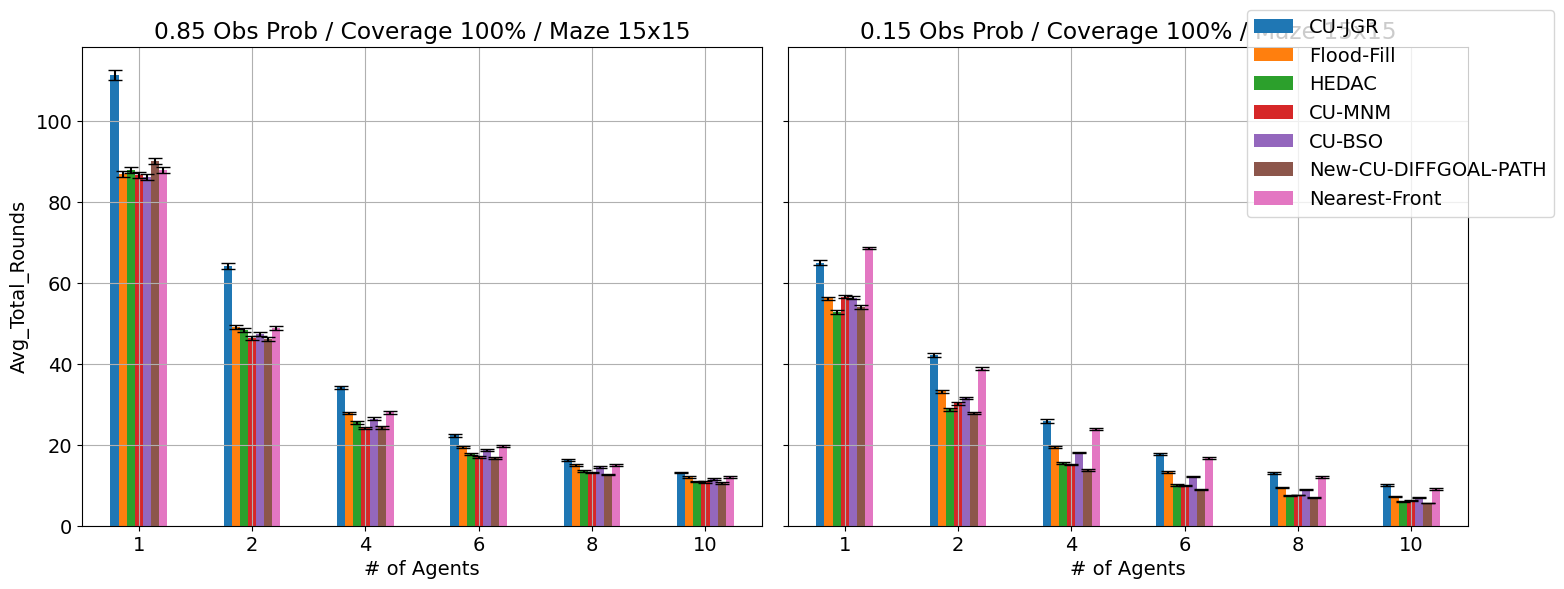

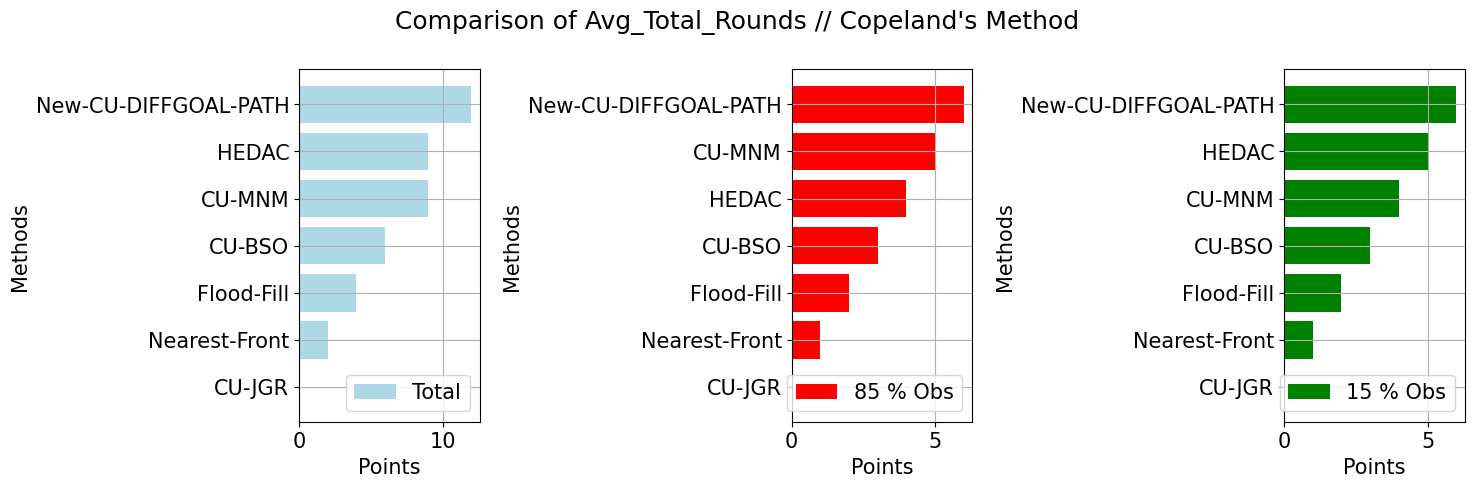

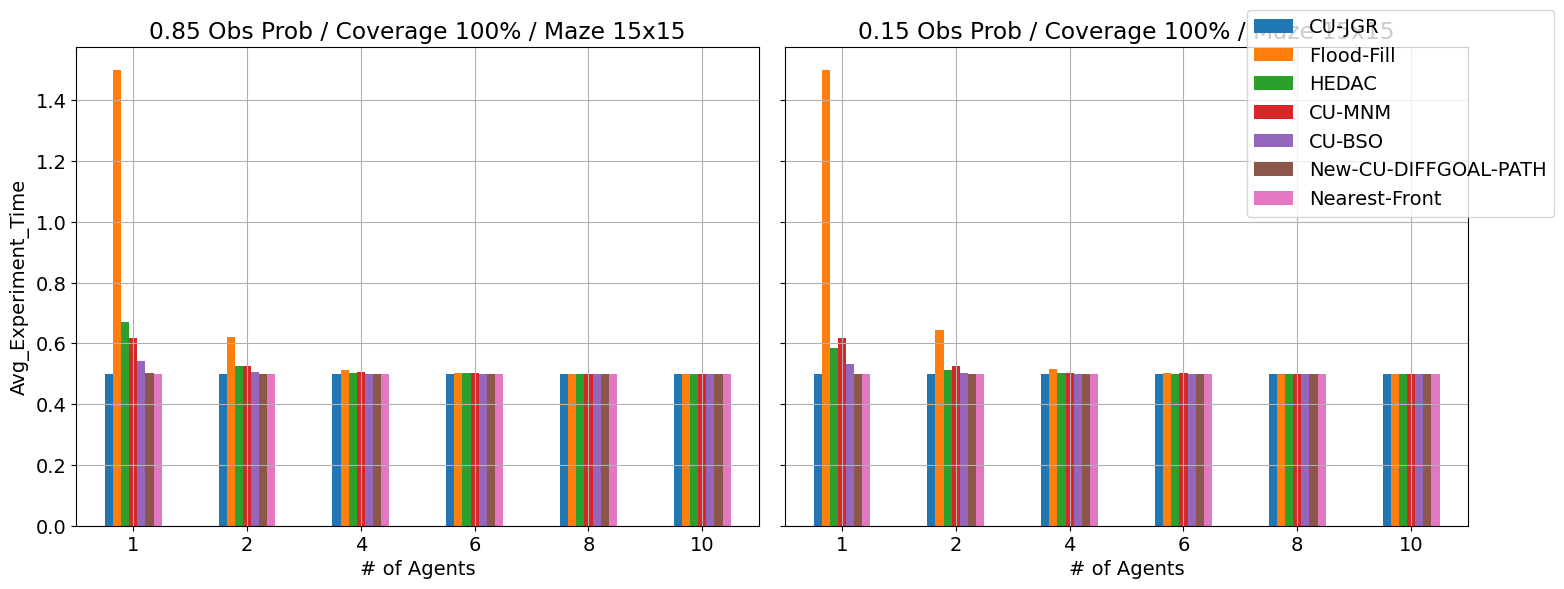

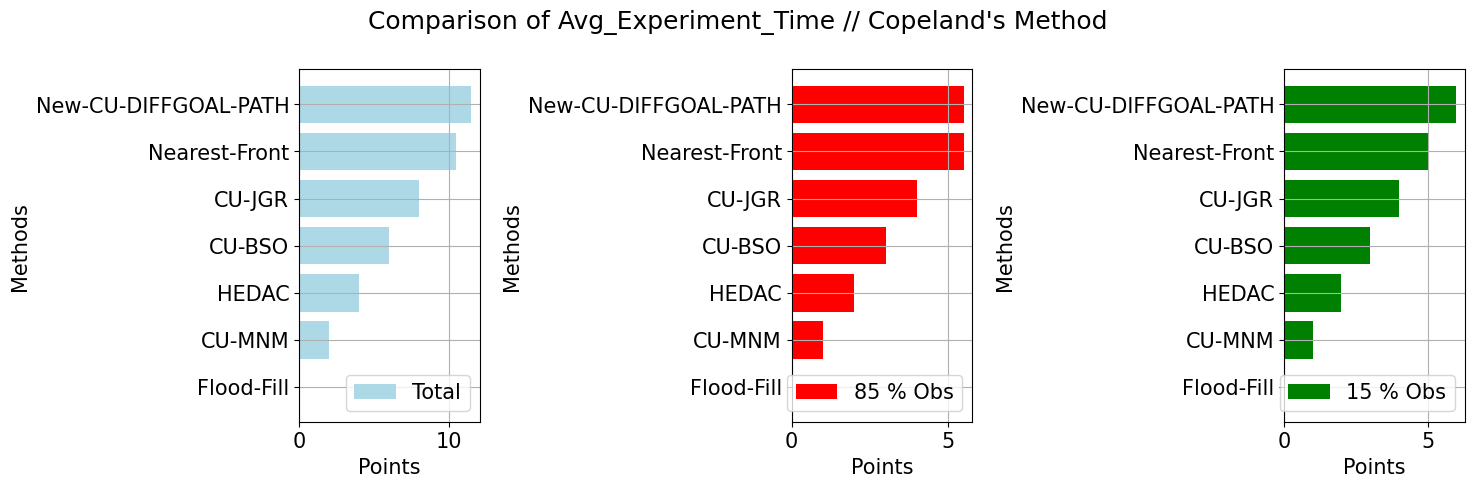

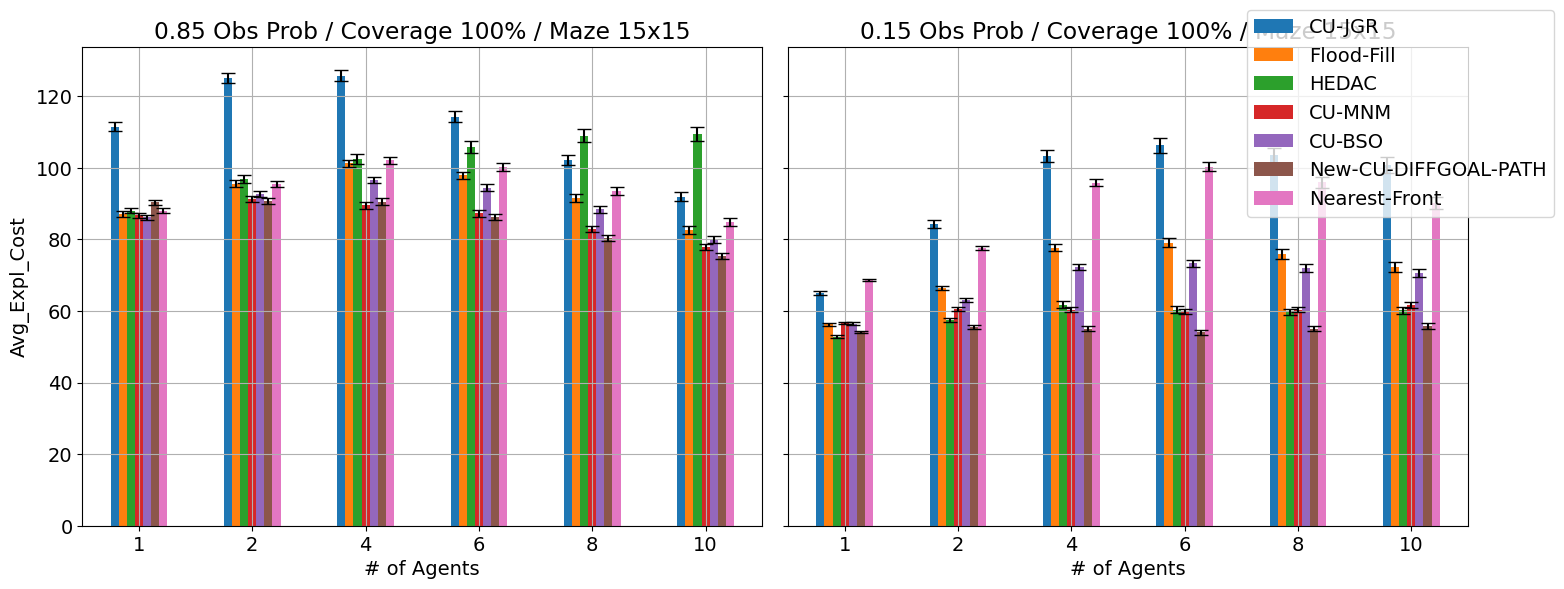

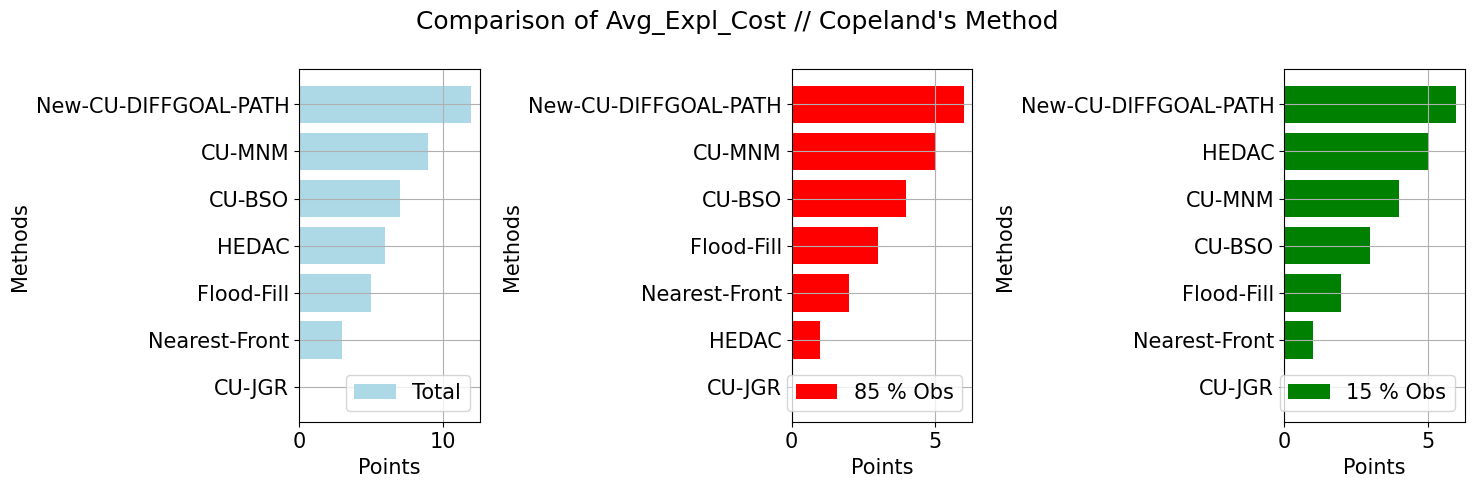

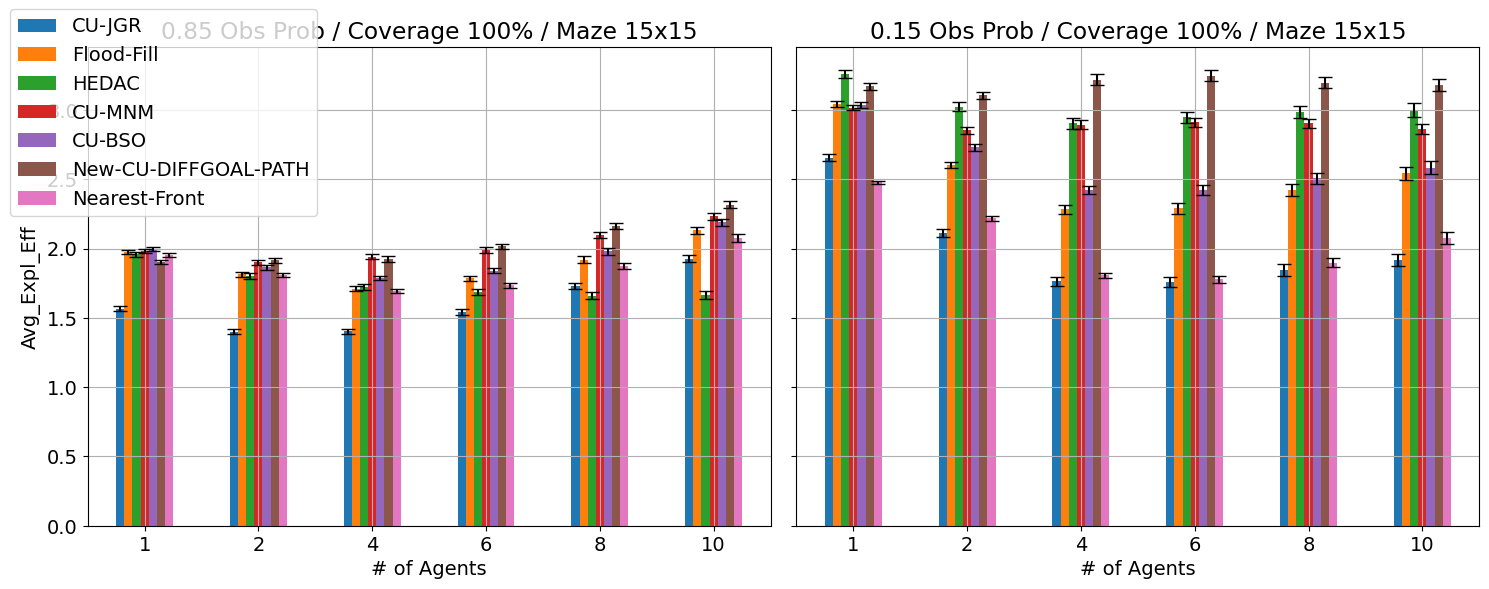

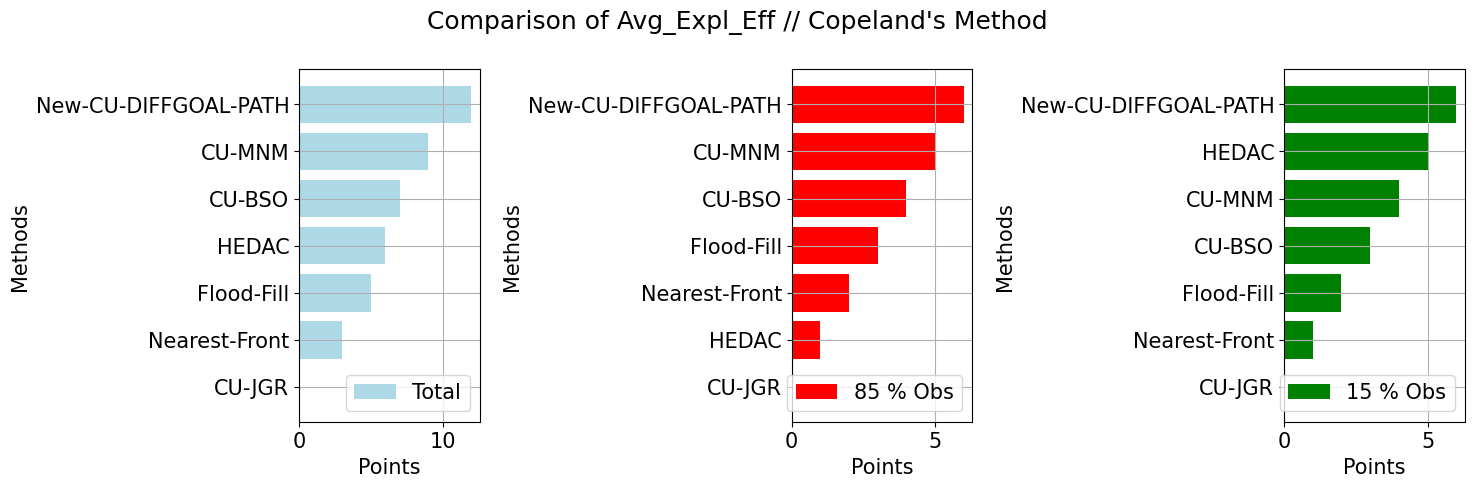

In [50]:
file_dict = {
             'CU-JGR': 'results/cu_jgr/15x15/cu_jgr_15x15_True_2_1000.xlsx',
             'Flood-Fill': 'results/flood_fill/15x15/flood_fill_15x15_True_2_1000.xlsx',
             'HEDAC': 'results/hedac/15x15/hedac_15x15_True_2_1000.xlsx', 
             'CU-MNM': 'results/cu_mnm/15x15/cu_mnm_15x15_True_2_1000.xlsx',
             'CU-BSO': 'results/cu_bso/15x15/cu_bso_15x15_True_2_1000.xlsx',
             'New-CU-DIFFGOAL-PATH': 'results/new_cu_diffgoal_path/15x15/new_cu_diffgoal_path_15x15_True_2_1000.xlsx',
             'Nearest-Front': 'results/nf/15x15/nf_15x15_True_2_1000.xlsx',
             #'New-CU-DIFFGOAL-PATH-JGR': 'results/new_cu_diffgoal_path_jgr/15x15/new_cu_diffgoal_path_jgr_15x15_True_2_500.xlsx',
             #'New_FF_JGR': 'results/new_ff_jgr/15x15/new_ff_jgr_15x15_True_2_500.xlsx',
             #'New-CU-HEDAC-DIFFGOAL-PATH': 'results/new_cu_hedac_diffgoal_path/15x15/new_cu_hedac_diffgoal_path_15x15_True_2_500.xlsx',
             #'New-CU-Same': 'results/new_cu_same/15x15/new_cu_same_15x15_True_2_500.xlsx',
             #'New-CU-Hedac-Same': 'results/new_cu_hedac_same/15x15/new_cu_hedac_same_15x15_True_2_500.xlsx',
             #'New-CU-DIFFGOAL': 'results/new_cu_diffgoal/15x15/new_cu_diffgoal_15x15_True_2_500.xlsx',
             #'New-CU-Hedac-DIFFGOAL': 'results/new_cu_hedac_diffgoal/15x15/new_cu_hedac_diffgoal_15x15_True_2_500.xlsx',
             #'New-FF-Hedac': 'results/new_ff_hedac/15x15/new_ff_hedac_15x15_True_2_500.xlsx',
             #'New-FF-CU-Hedac-DIFFGOAL': 'results/new_ff_cu_hedac_diffgoal/15x15/new_ff_cu_hedac_diffgoal_15x15_True_2_450.xlsx',
             #'New-FF-CU-DIFFGOAL': 'results/new_ff_cu_diffgoal/15x15/new_ff_cu_diffgoal_15x15_True_2_450.xlsx',
             }
convert_paths_os(file_dict)

plt.rcParams.update({'font.size': 14})  # changes plot font size.
plot_comparison(file_dict, 'Total_Rounds')

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Total_Rounds')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Experiment_Time', normalize=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Experiment_Time')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Expl_Cost')

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Expl_Cost')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Expl_Eff', legent_left=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Expl_Eff', True)


#### Comparisons of different $\lambda$ of new method:

Define directory of all experiments:

In [59]:
all_exp_directory = 'results/new_cu_diffgoal_path/lambda_comps/experiments'

Compare individual maze dimensions:

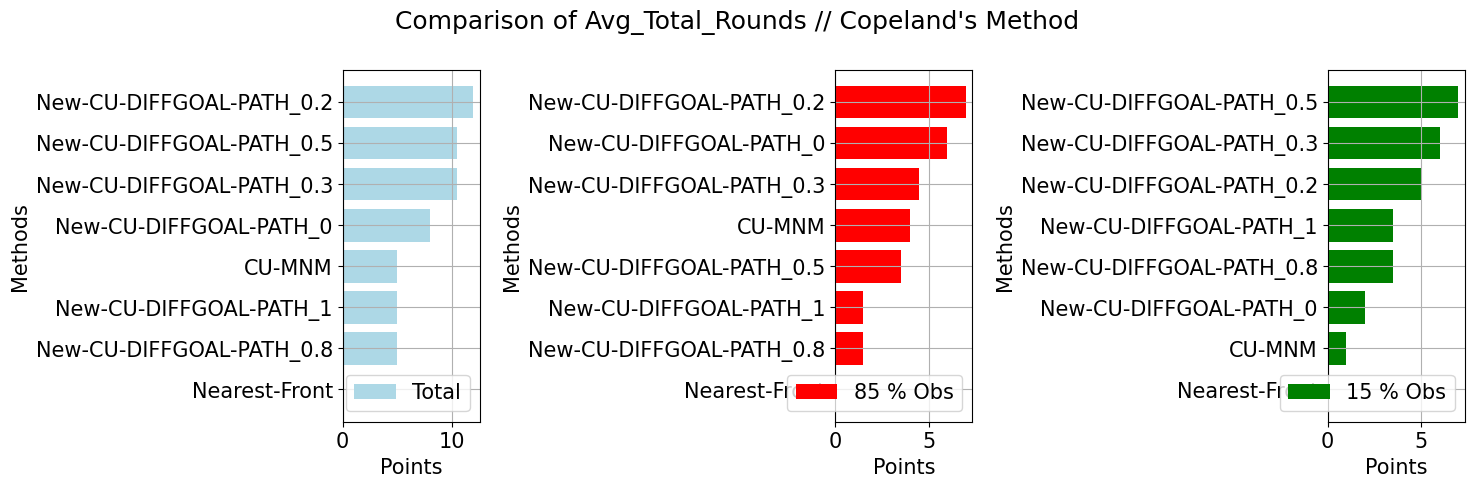

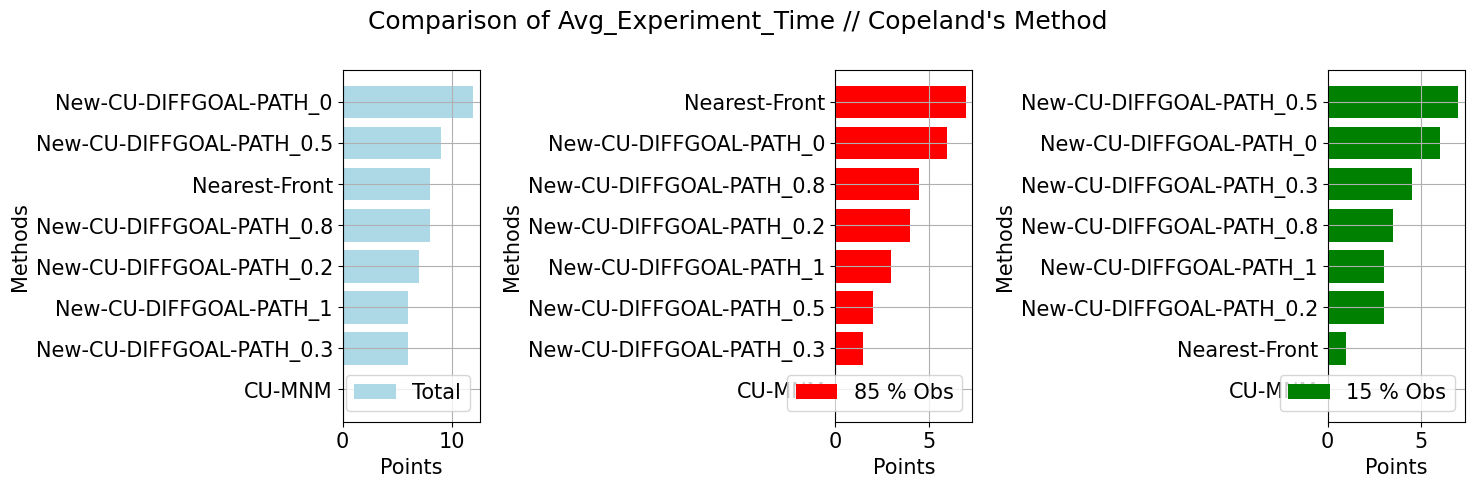

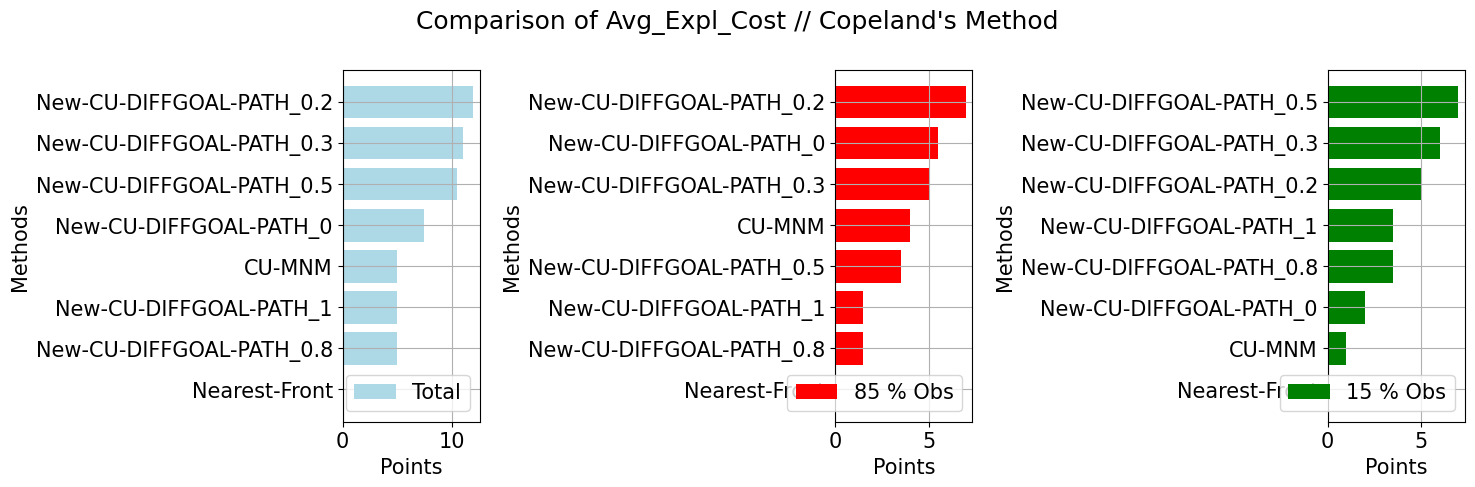

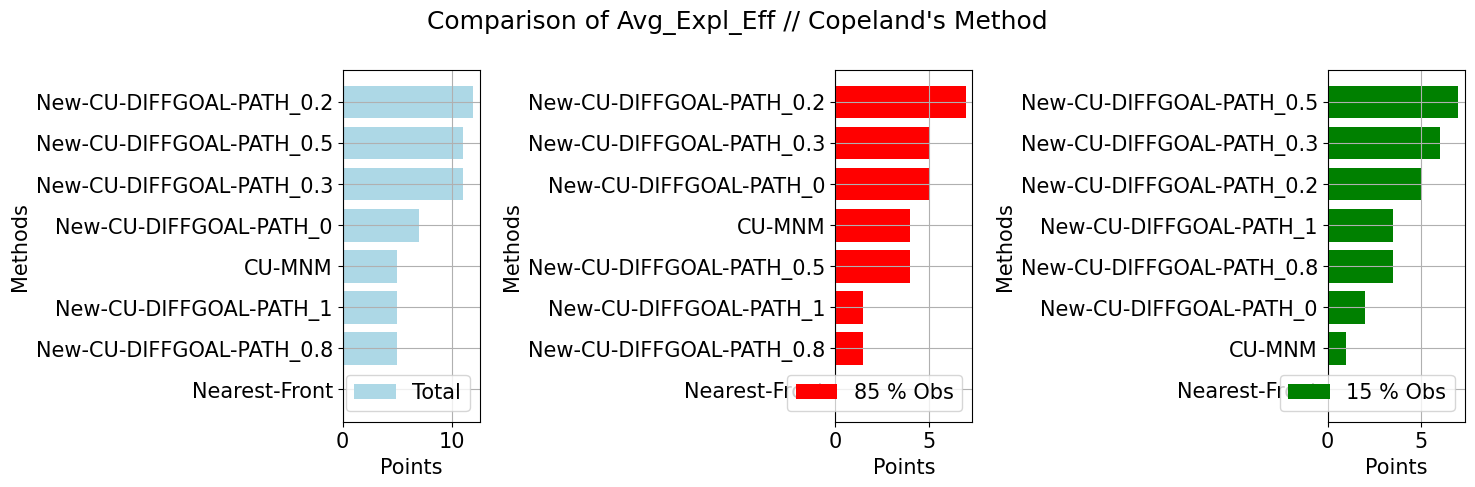

In [71]:
dimensions_str = "15x15"

file_dict = {
             'CU-MNM': f'results/cu_mnm/{dimensions_str}/cu_mnm_{dimensions_str}_True_2_1000.xlsx',
             'Nearest-Front': f'results/nf/{dimensions_str}/nf_{dimensions_str}_True_2_1000.xlsx',
             'New-CU-DIFFGOAL-PATH_1': f'{all_exp_directory}/new_cu_diffgoal_path_1/{dimensions_str}/new_cu_diffgoal_path_1_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0.8': f'{all_exp_directory}/new_cu_diffgoal_path_0.8/{dimensions_str}/new_cu_diffgoal_path_0.8_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0.5': f'{all_exp_directory}/new_cu_diffgoal_path_0.5/{dimensions_str}/new_cu_diffgoal_path_0.5_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0.2': f'{all_exp_directory}/new_cu_diffgoal_path_0.2/{dimensions_str}/new_cu_diffgoal_path_0.2_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0.3': f'{all_exp_directory}/new_cu_diffgoal_path_0.3/{dimensions_str}/new_cu_diffgoal_path_0.3_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0': f'{all_exp_directory}/new_cu_diffgoal_path_0/{dimensions_str}/new_cu_diffgoal_path_0_{dimensions_str}_True_2_100.xlsx',
             }

# removes CU-MNM and Nearest-Front, if dimension != 15x15 (no experiments for these dimensions).
if dimensions_str != '15x15':
    if 'CU-MNM' in file_dict:
        file_dict.pop('CU-MNM')
    if 'Nearest-Front' in file_dict:
        file_dict.pop('Nearest-Front')

convert_paths_os(file_dict)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Total_Rounds')
plot_copeland_comparison(file_dict, 'Avg_Experiment_Time')
plot_copeland_comparison(file_dict, 'Avg_Expl_Cost')
plot_copeland_comparison(file_dict, 'Avg_Expl_Eff', True)

Addition of all copeland scores:

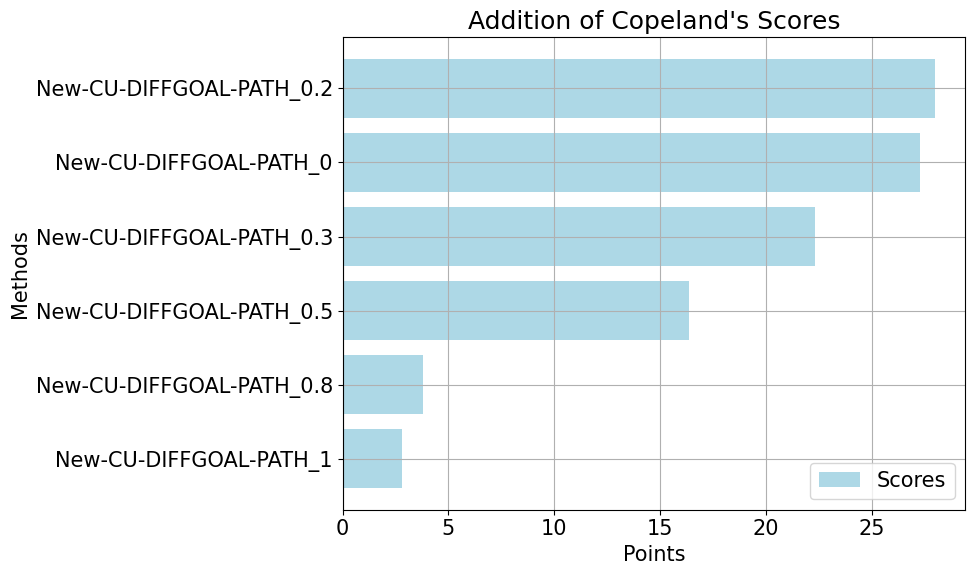

In [62]:
dimensions_list = ["15x15", "30x30", "50x50"]
scores = {}
for dimensions in dimensions_list:
    file_dict = {
                'New-CU-DIFFGOAL-PATH_1': f'{all_exp_directory}/new_cu_diffgoal_path_1/{dimensions}/new_cu_diffgoal_path_1_{dimensions}_True_2_100.xlsx',
                'New-CU-DIFFGOAL-PATH_0.8': f'{all_exp_directory}/new_cu_diffgoal_path_0.8/{dimensions}/new_cu_diffgoal_path_0.8_{dimensions}_True_2_100.xlsx',
                'New-CU-DIFFGOAL-PATH_0.5': f'{all_exp_directory}/new_cu_diffgoal_path_0.5/{dimensions}/new_cu_diffgoal_path_0.5_{dimensions}_True_2_100.xlsx',
                'New-CU-DIFFGOAL-PATH_0.2': f'{all_exp_directory}/new_cu_diffgoal_path_0.2/{dimensions}/new_cu_diffgoal_path_0.2_{dimensions}_True_2_100.xlsx',
                'New-CU-DIFFGOAL-PATH_0.3': f'{all_exp_directory}/new_cu_diffgoal_path_0.3/{dimensions}/new_cu_diffgoal_path_0.3_{dimensions}_True_2_100.xlsx',
                'New-CU-DIFFGOAL-PATH_0': f'{all_exp_directory}/new_cu_diffgoal_path_0/{dimensions}/new_cu_diffgoal_path_0_{dimensions}_True_2_100.xlsx',}    

    scores = find_best_along_copeland(file_dict, ['Avg_Total_Rounds', 'Avg_Experiment_Time', 'Avg_Expl_Cost', 'Avg_Expl_Eff'], ['Avg_Expl_Eff'], scores)

scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
methods_all = list(scores.keys())
values_all = list(scores.values())
plt.figure(figsize=(10, 6))
plt.barh(methods_all, values_all, color='lightblue', label='Scores')
plt.title("Addition of Copeland's Scores")
plt.xlabel('Points')
plt.ylabel('Methods')
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



### Plotting (voronoi mode):

Renamed `New-CU-DIFFGOAL-PATH` as `CU-LVP`.

#### 15x15 Maze

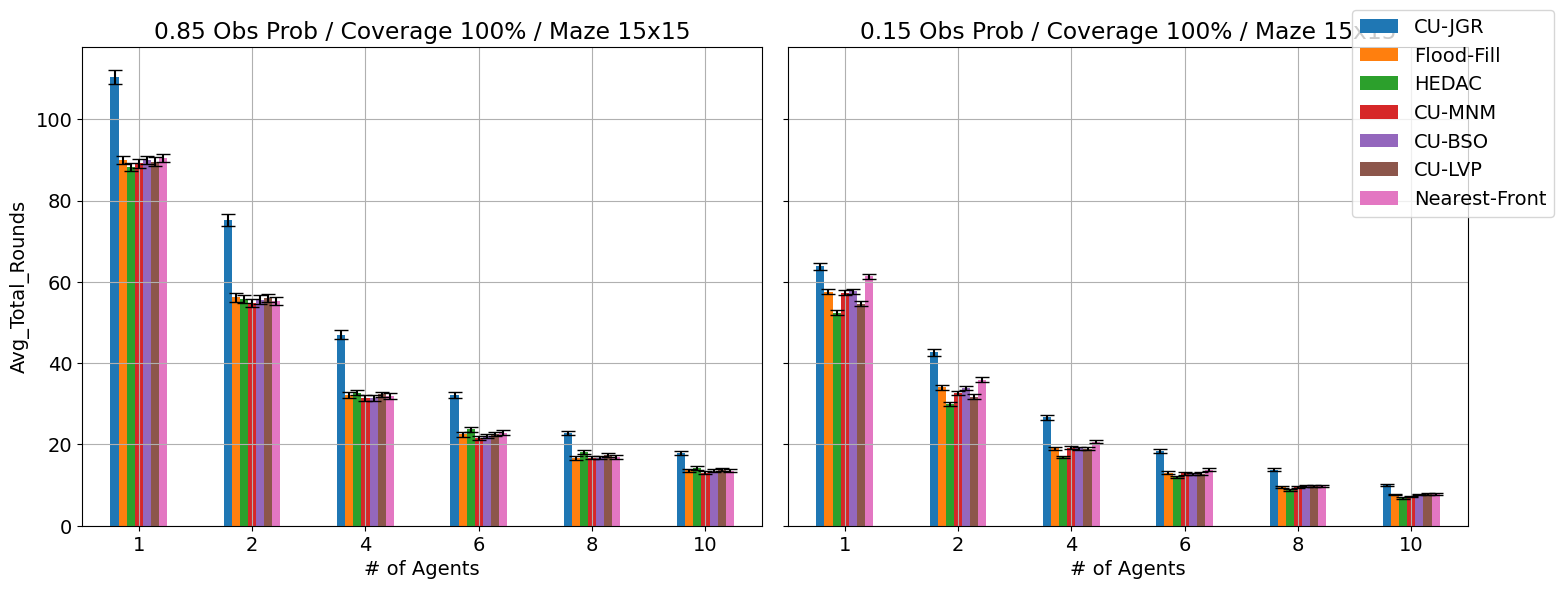

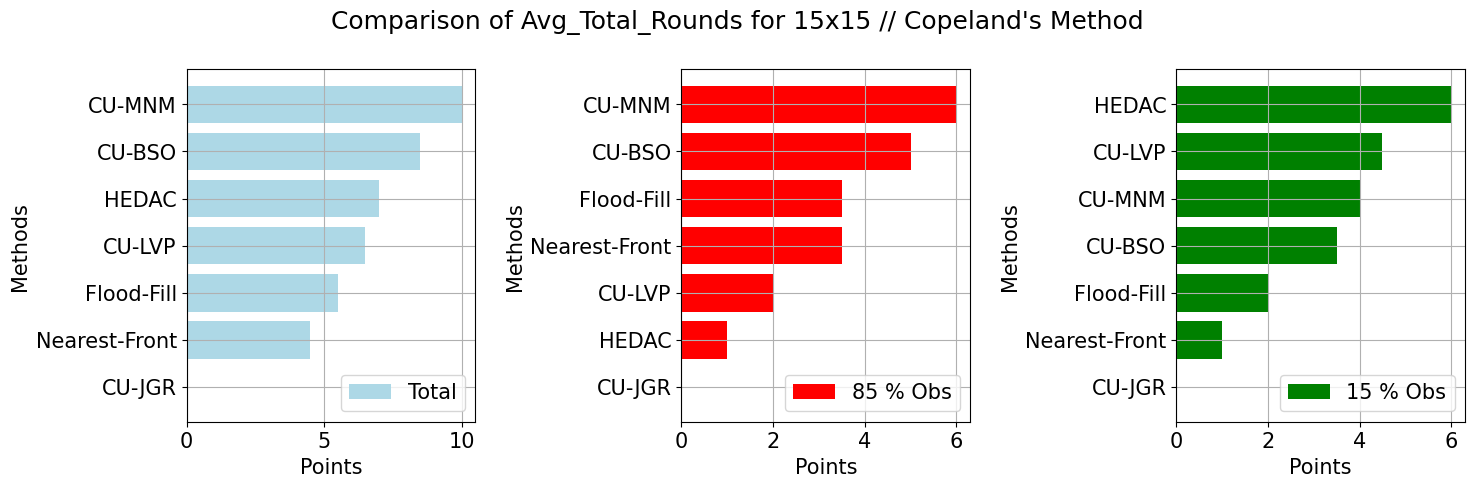

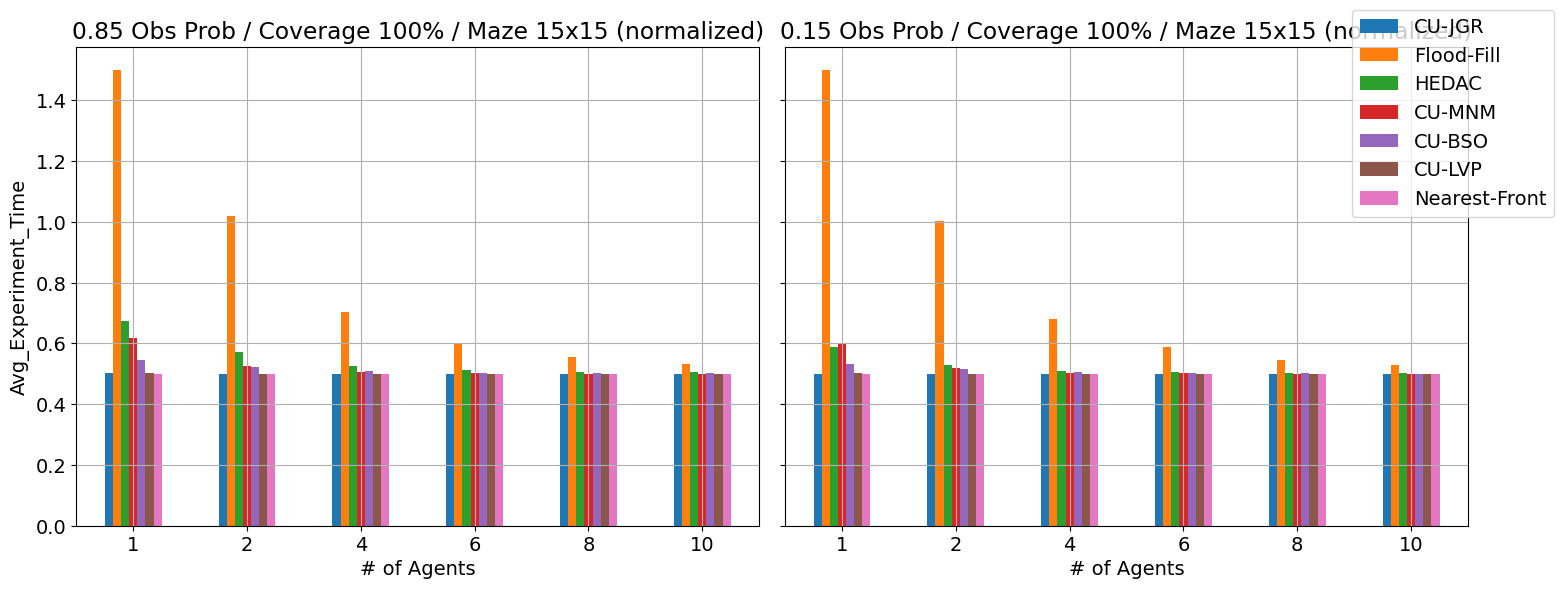

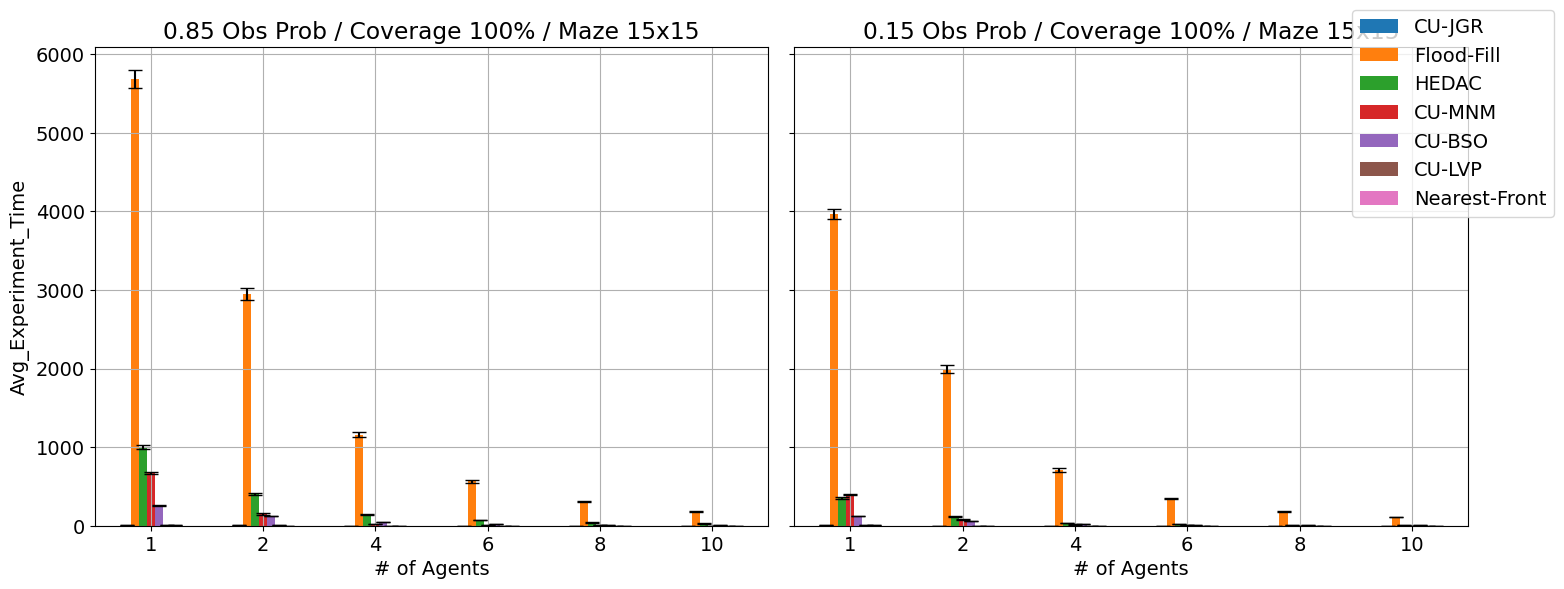

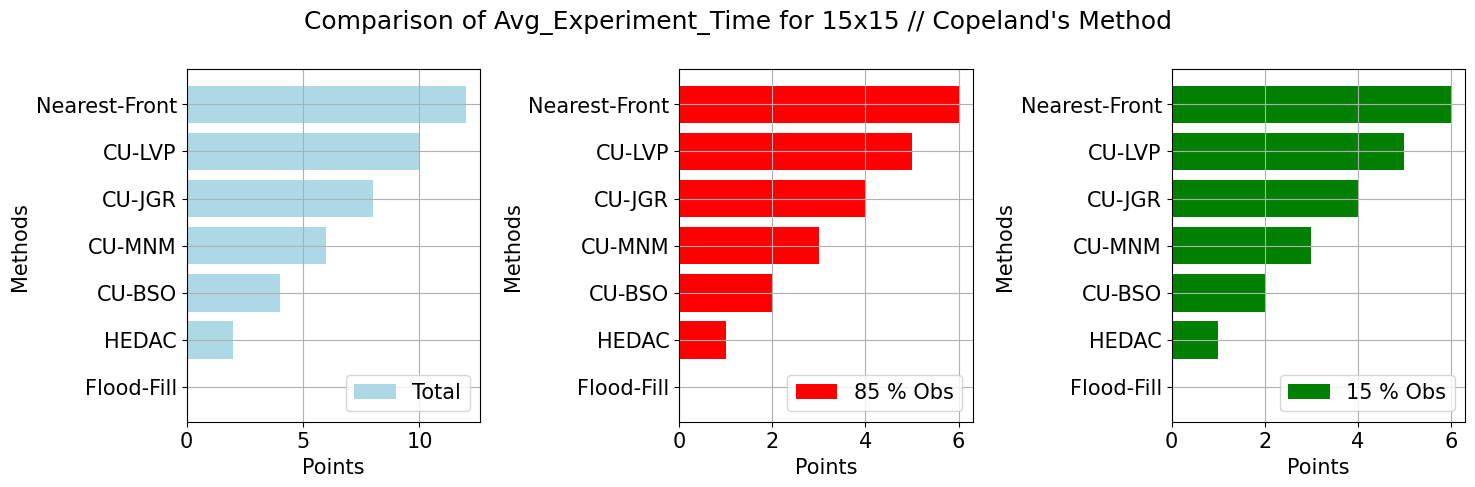

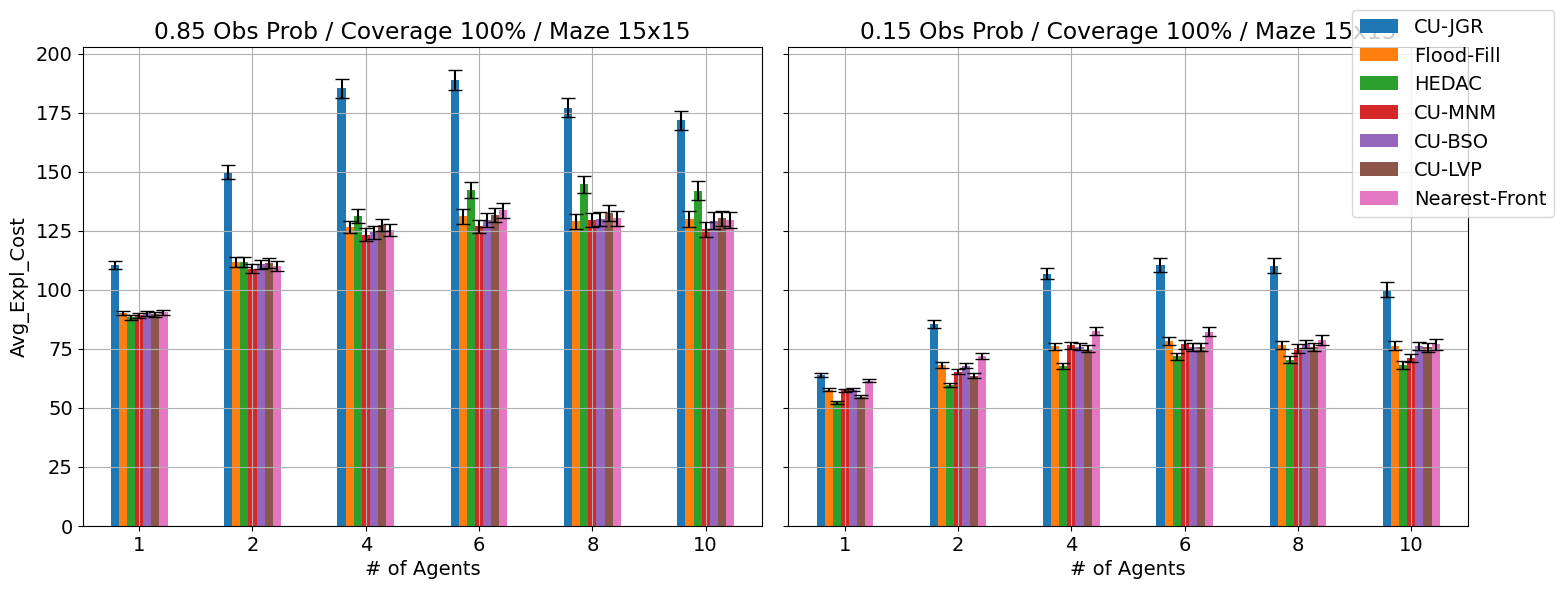

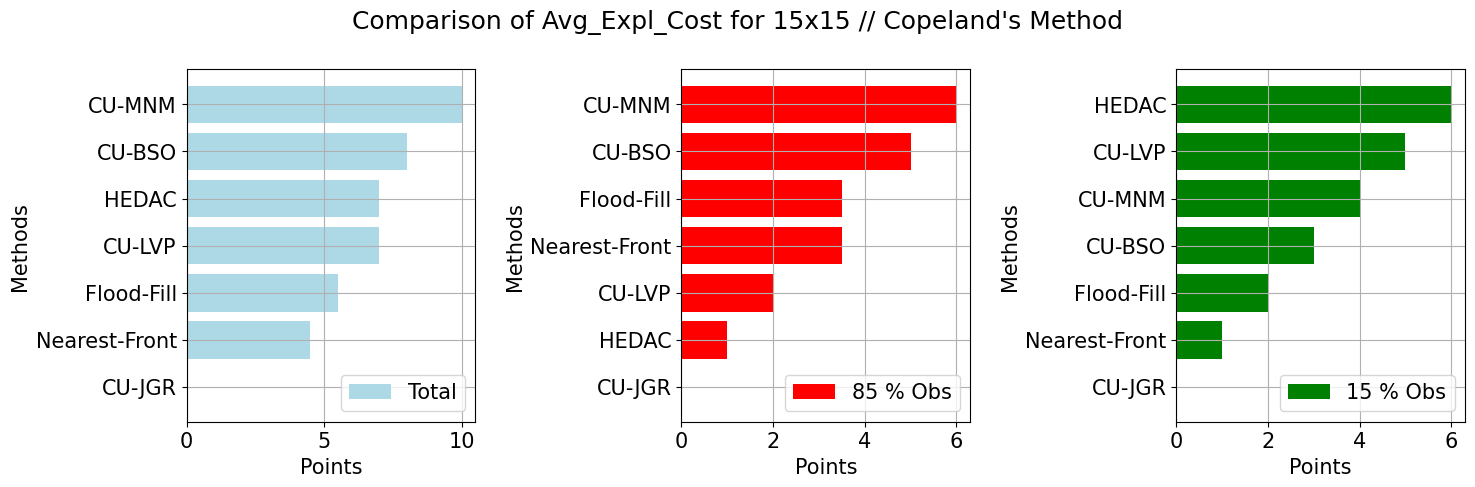

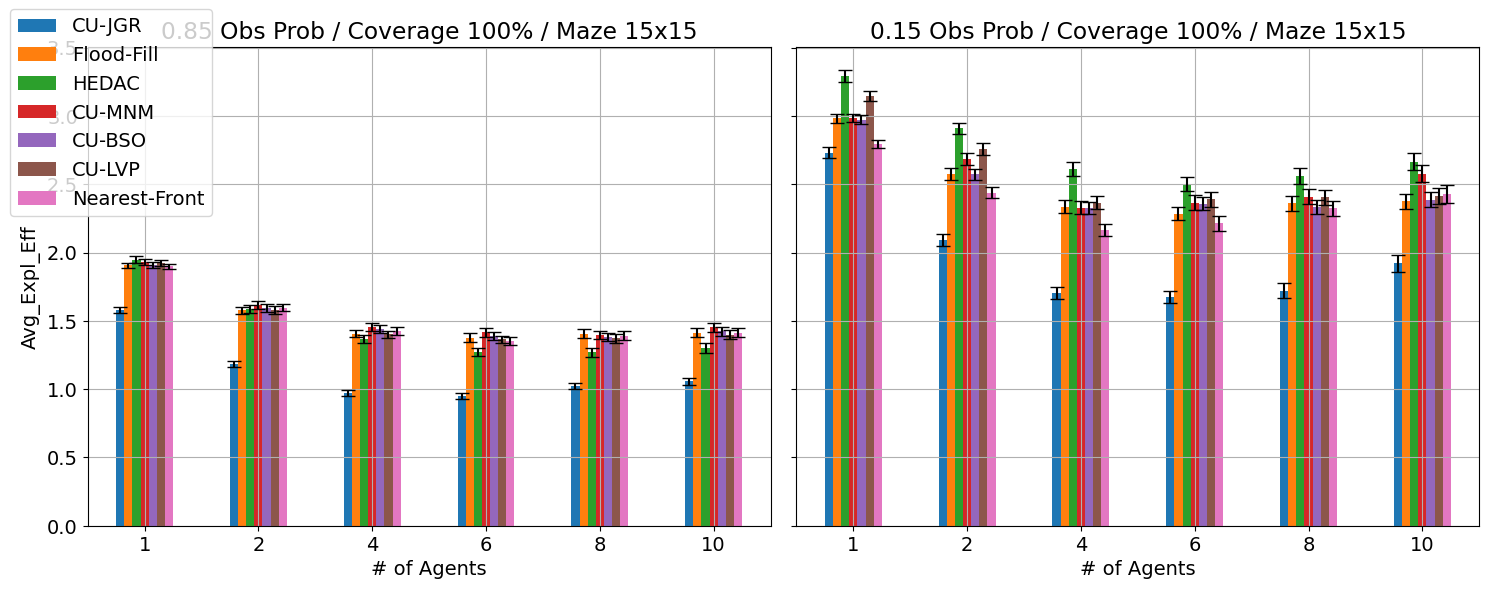

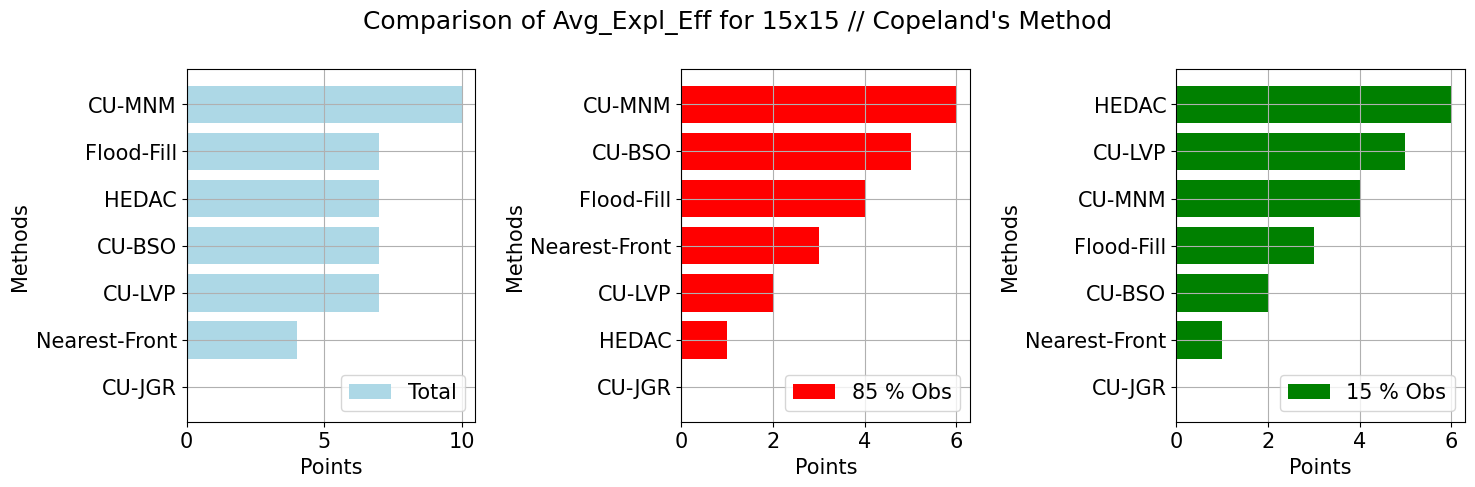

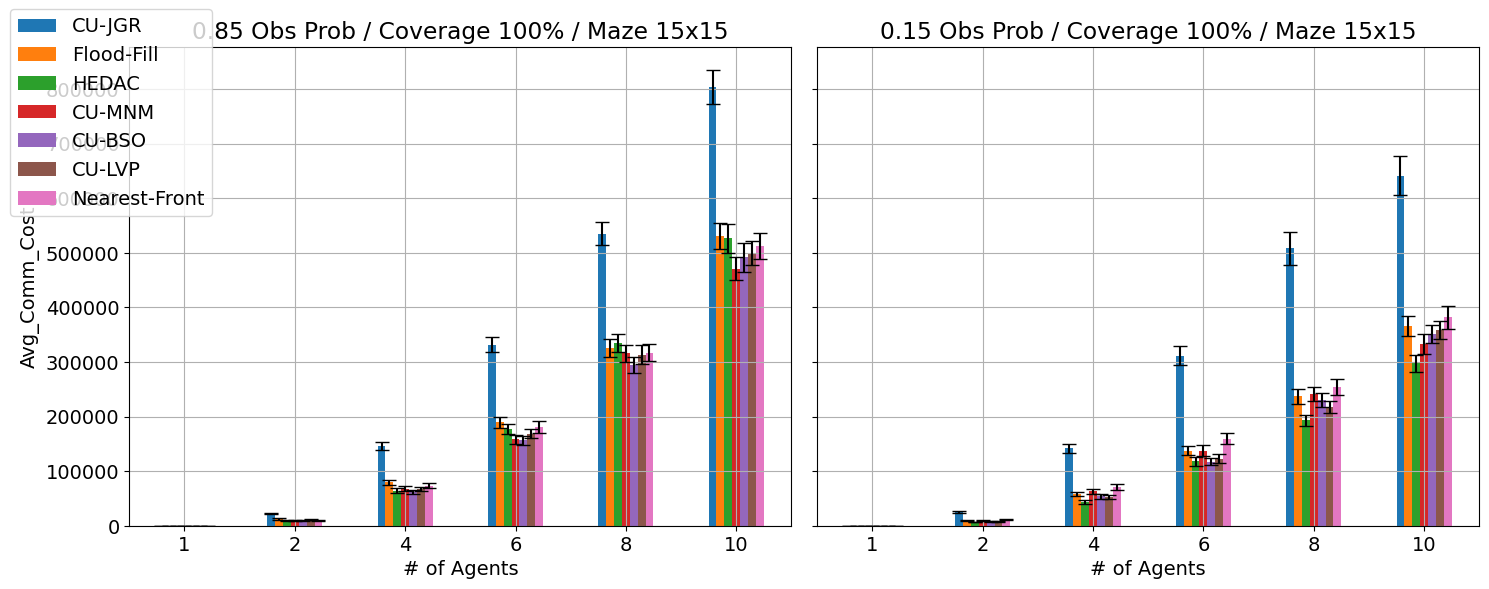

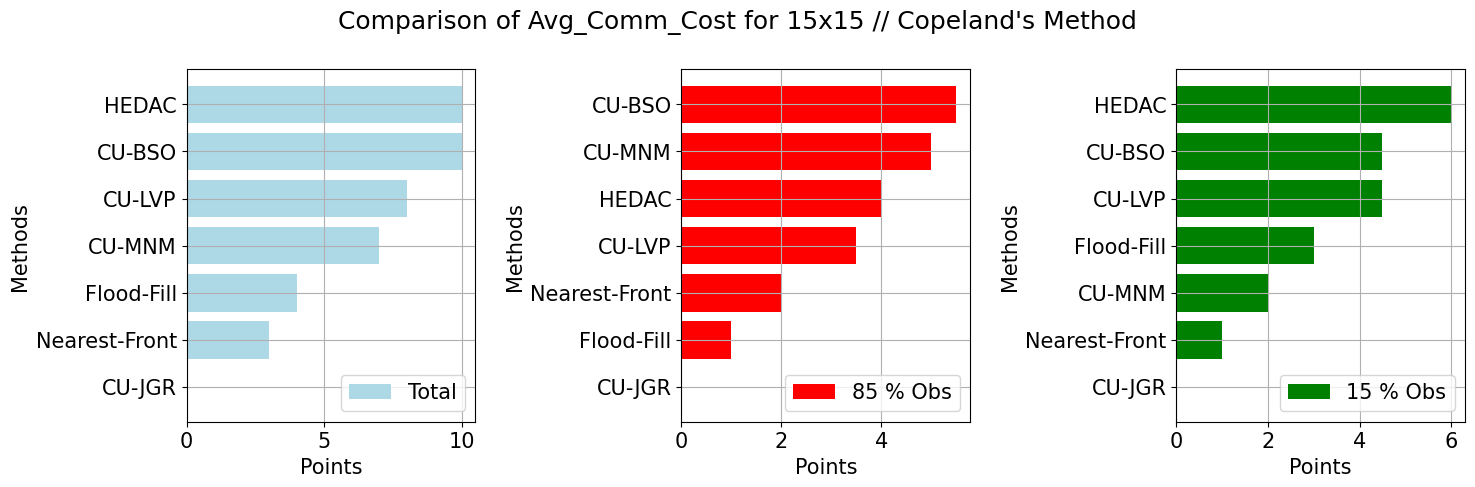

In [13]:
file_dict = {
             'CU-JGR': 'results_submaps/cu_jgr/15x15/cu_jgr_15x15_True_2_500.xlsx',
             'Flood-Fill': 'results_submaps/flood_fill/15x15/flood_fill_15x15_True_2_500.xlsx',
             'HEDAC': 'results_submaps/hedac/15x15/hedac_15x15_True_2_500.xlsx', 
             'CU-MNM': 'results_submaps/cu_mnm/15x15/cu_mnm_15x15_True_2_500.xlsx',
             'CU-BSO': 'results_submaps/cu_bso/15x15/cu_bso_15x15_True_2_500.xlsx',
             'CU-LVP': 'results_submaps/new_cu_diffgoal_path_0.2/15x15/new_cu_diffgoal_path_0.2_15x15_True_2_500.xlsx',
             'Nearest-Front': 'results_submaps/nf/15x15/nf_15x15_True_2_500.xlsx',
             }
convert_paths_os(file_dict)

plt.rcParams.update({'font.size': 14})  # changes plot font size.
plot_comparison(file_dict, 'Total_Rounds')

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Total_Rounds')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Experiment_Time', normalize=True)
plot_comparison(file_dict, 'Experiment_Time', normalize=False)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Experiment_Time')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Expl_Cost')

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Expl_Cost')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Expl_Eff', legent_left=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Expl_Eff', True)

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Comm_Cost', legent_left=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Comm_Cost')


#### 30x30 Maze

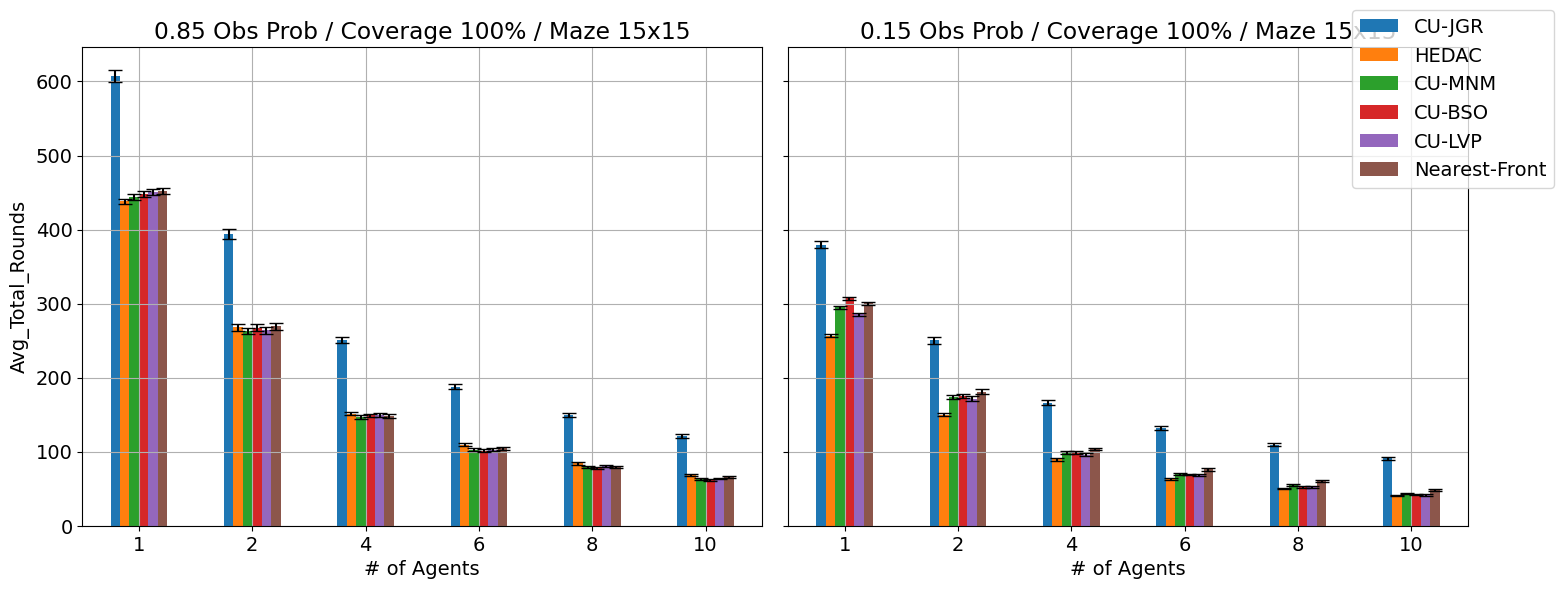

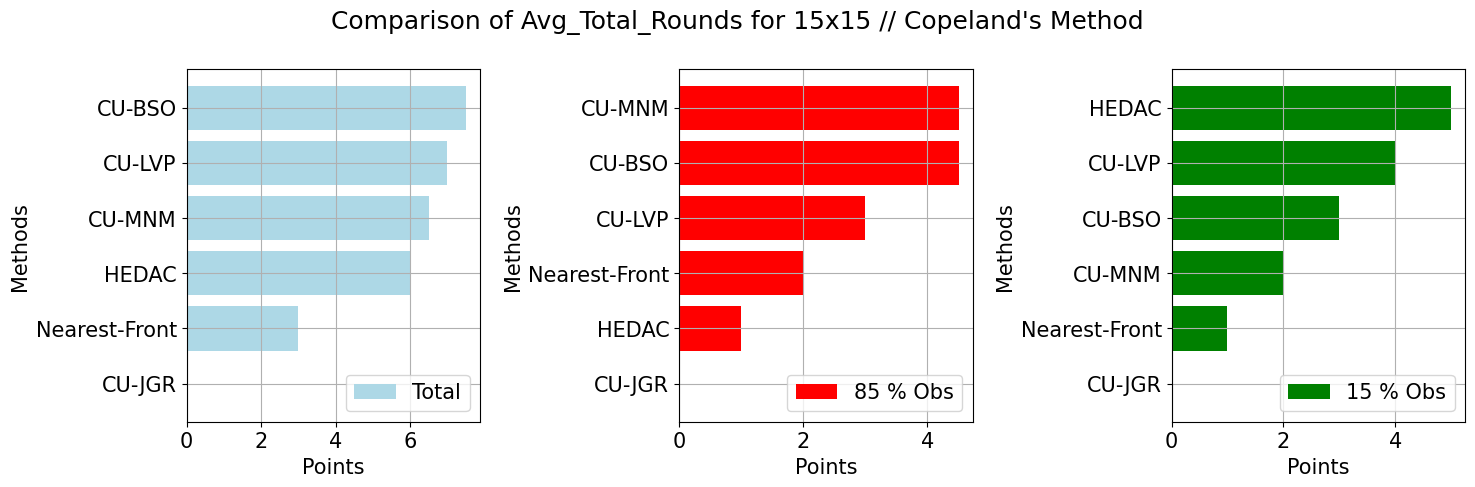

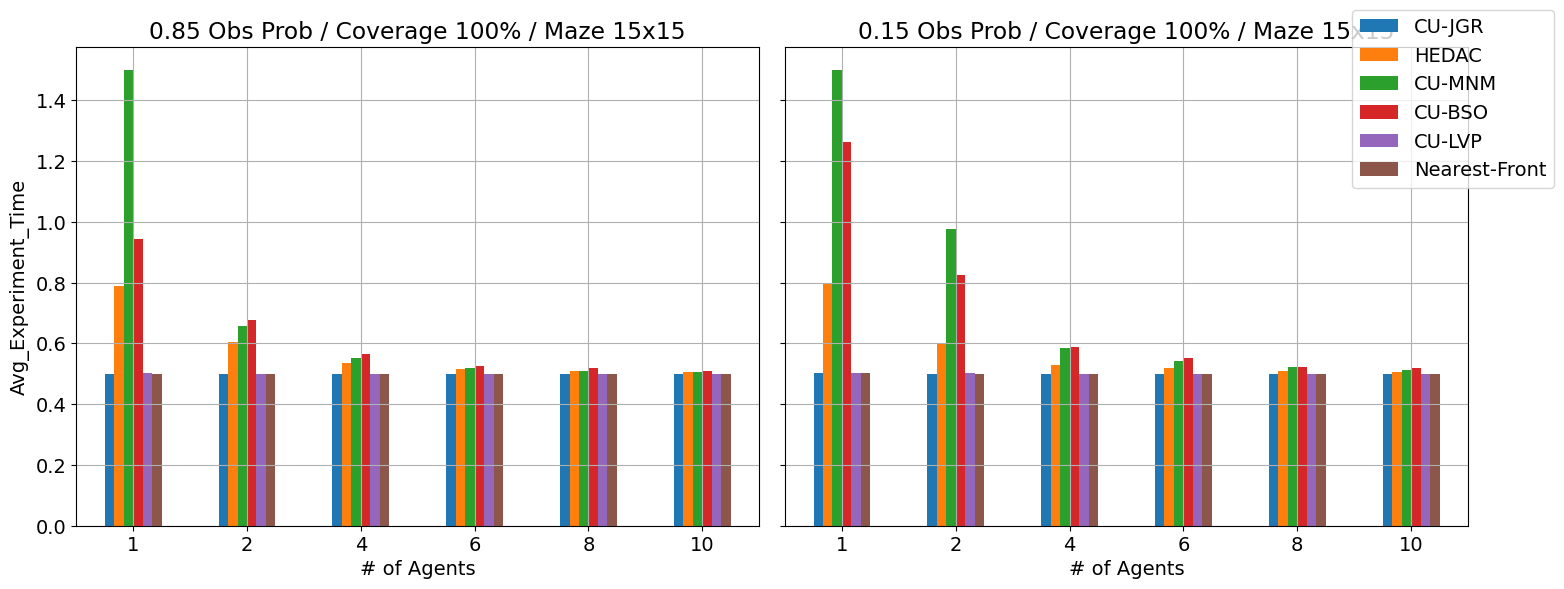

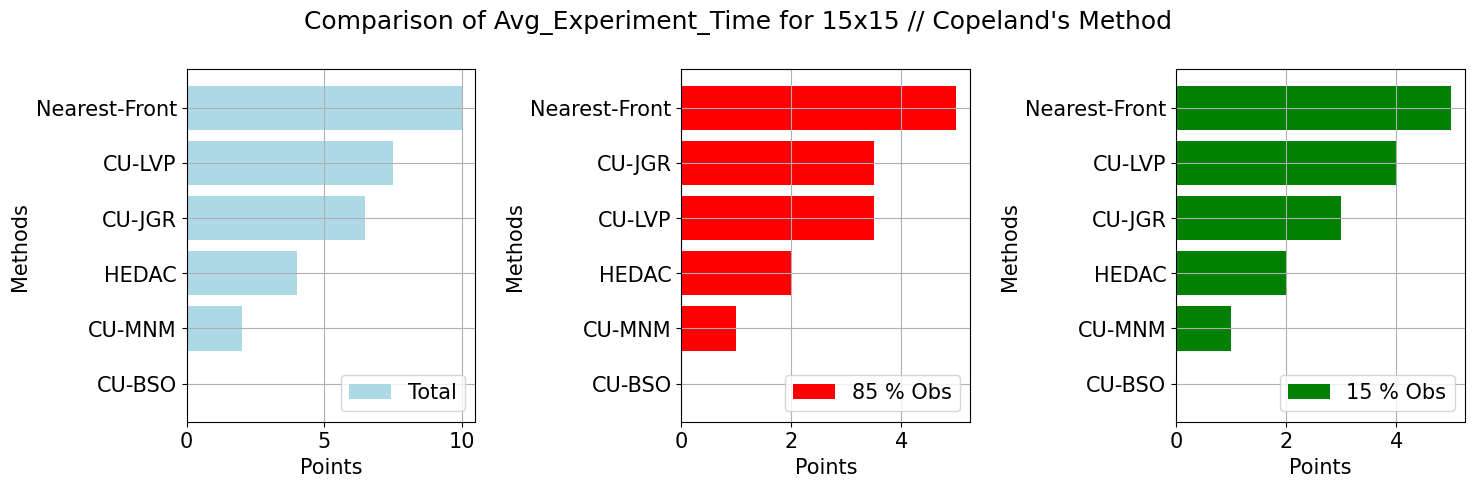

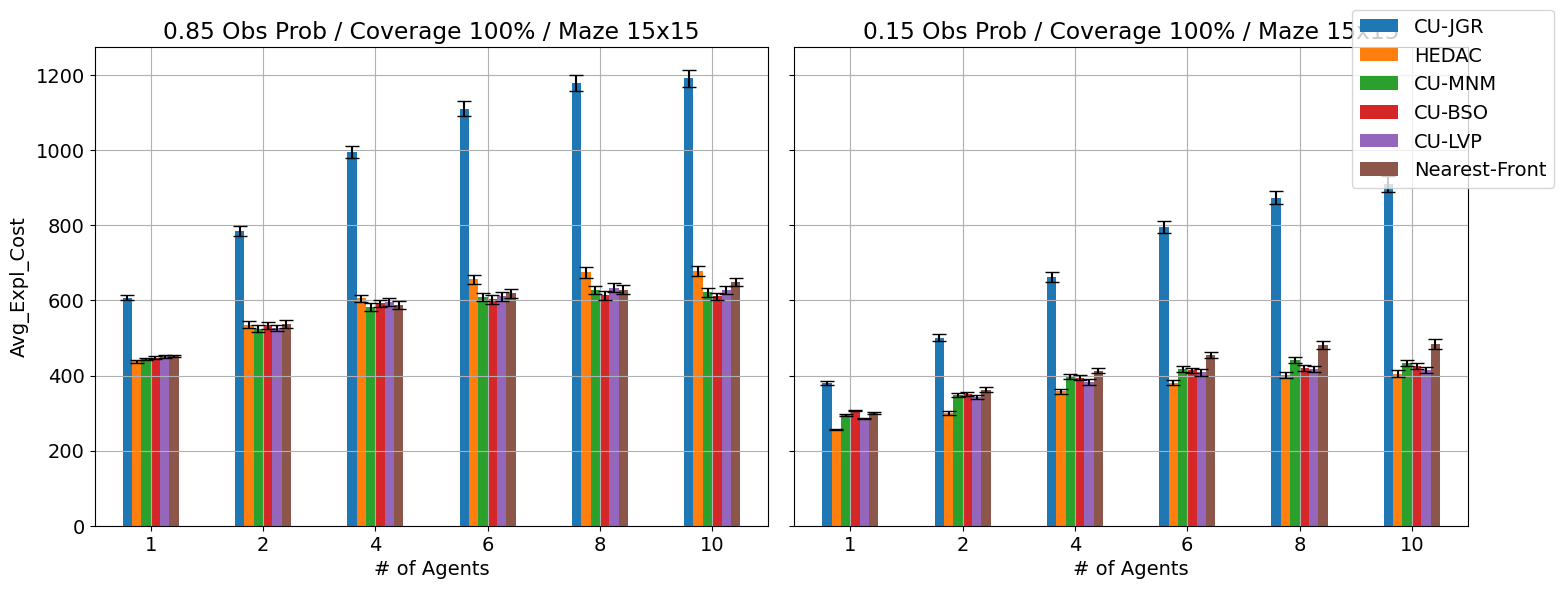

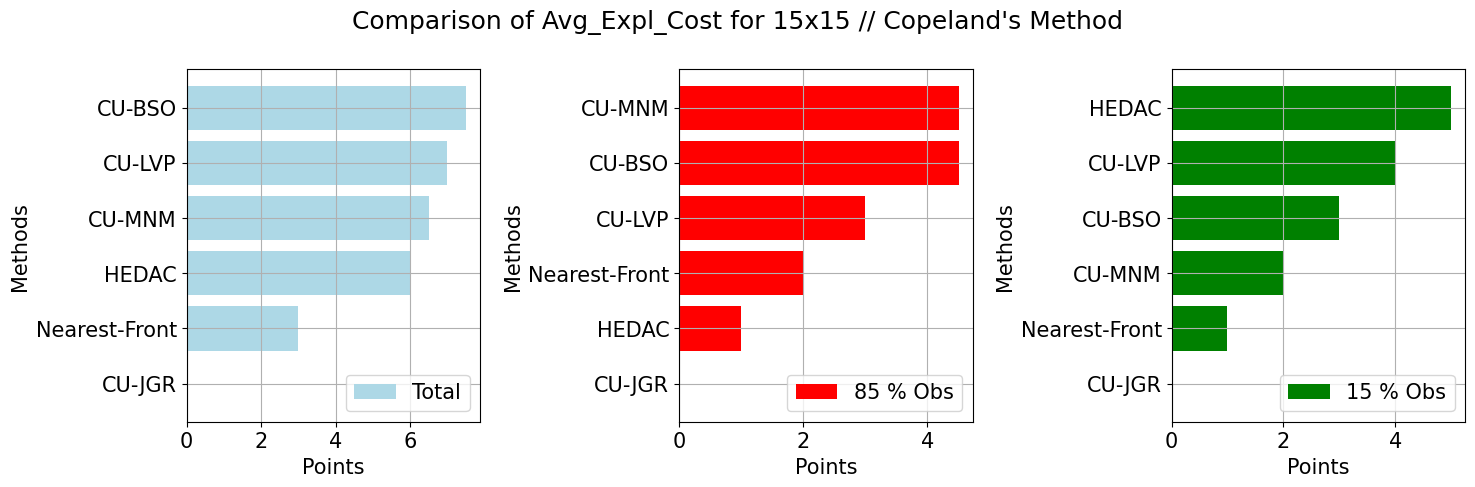

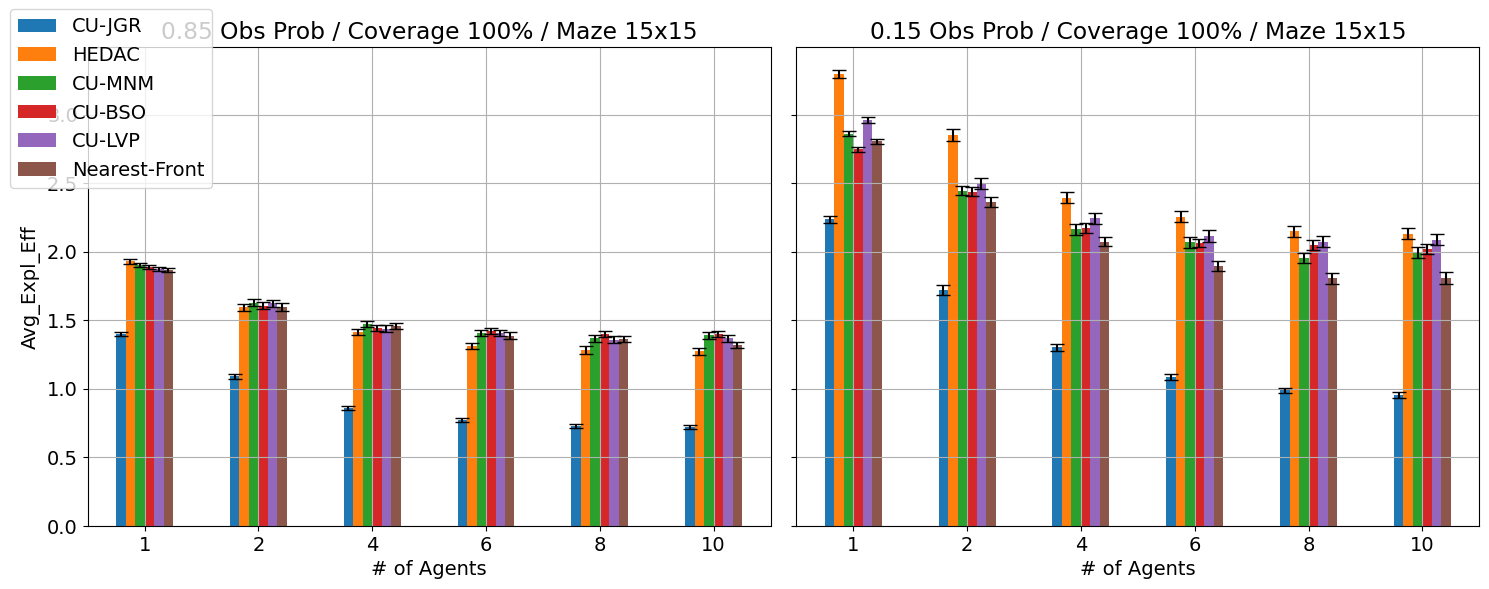

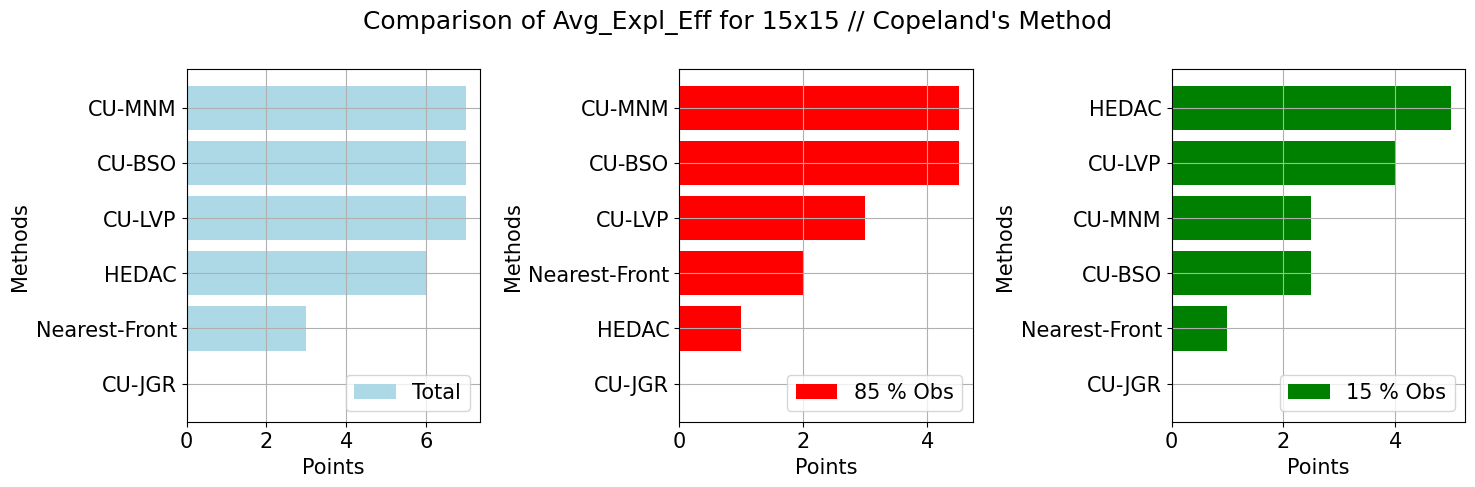

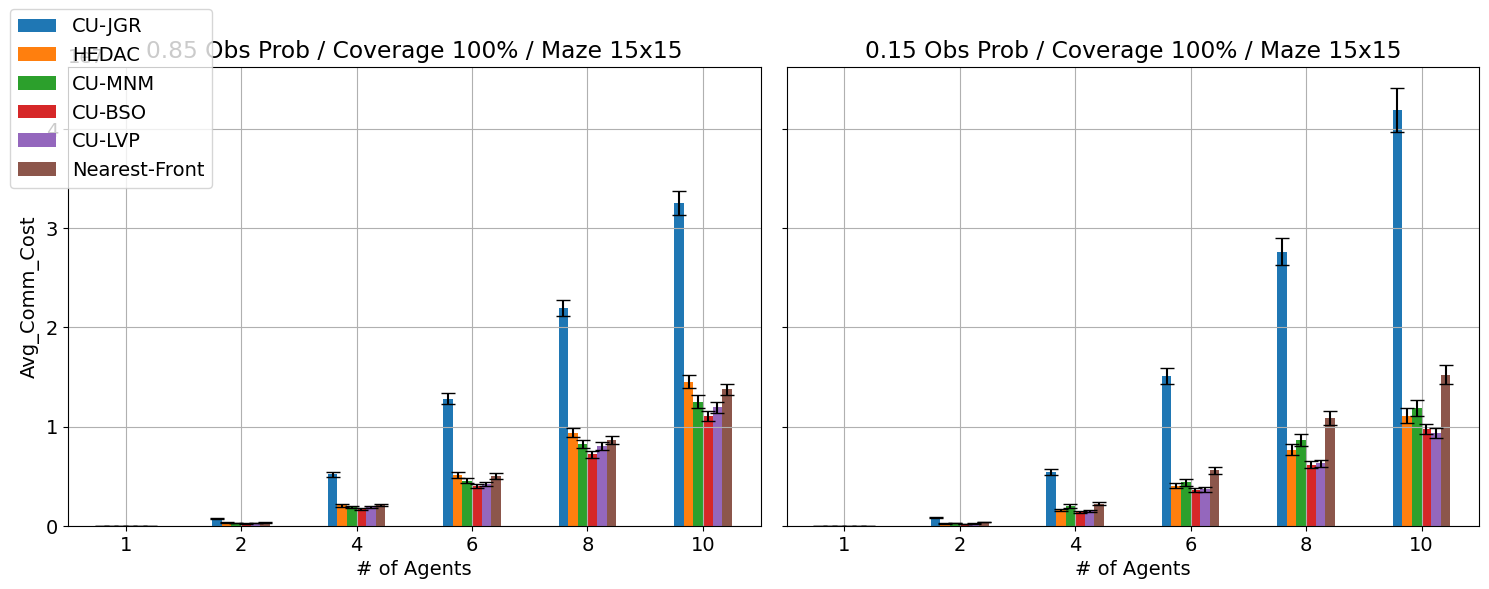

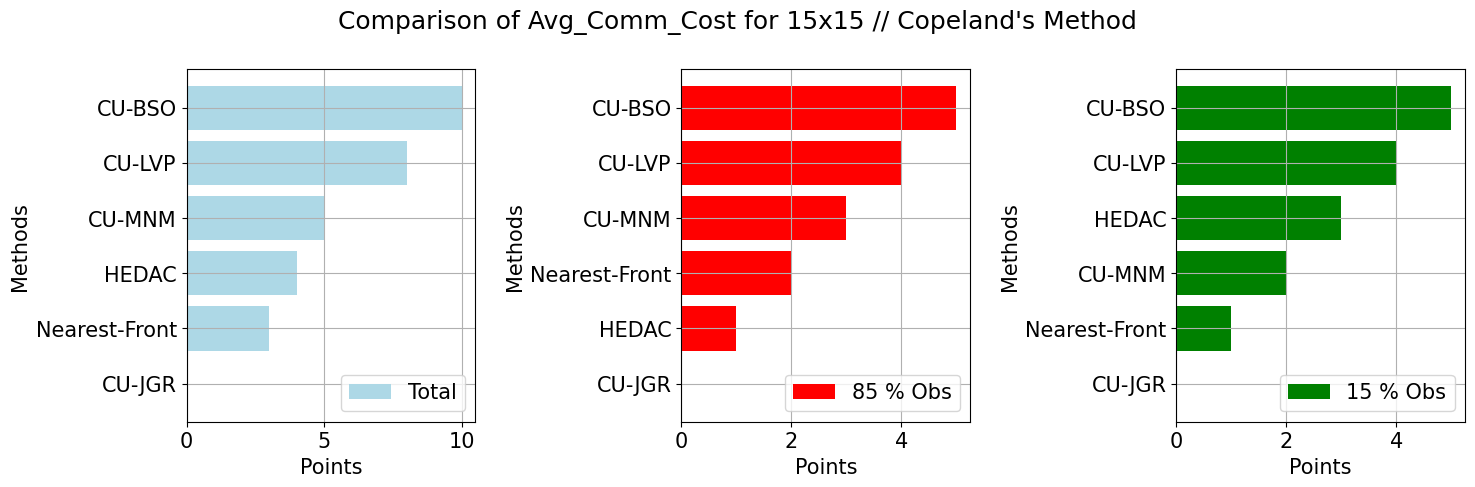

In [9]:
file_dict = {
             'CU-JGR': 'results_submaps/cu_jgr/30x30/cu_jgr_30x30_True_2_250.xlsx',
            #  'Flood-Fill': 'results_submaps/flood_fill/30x30/flood_fill_30x30_True_2_250.xlsx',
             'HEDAC': 'results_submaps/hedac/30x30/hedac_30x30_True_2_250.xlsx', 
             'CU-MNM': 'results_submaps/cu_mnm/30x30/cu_mnm_30x30_True_2_250.xlsx',
             'CU-BSO': 'results_submaps/cu_bso/30x30/cu_bso_30x30_True_2_250.xlsx',
             'CU-LVP': 'results_submaps/new_cu_diffgoal_path_0.2/30x30/new_cu_diffgoal_path_0.2_30x30_True_2_250.xlsx',
             'Nearest-Front': 'results_submaps/nf/30x30/nf_30x30_True_2_250.xlsx',
             }
convert_paths_os(file_dict)

plt.rcParams.update({'font.size': 14})  # changes plot font size.
plot_comparison(file_dict, 'Total_Rounds')

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Total_Rounds')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Experiment_Time', normalize=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Experiment_Time')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Expl_Cost')

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Expl_Cost')

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Expl_Eff', legent_left=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Expl_Eff', True)

plt.rcParams.update({'font.size': 14})
plot_comparison(file_dict, 'Comm_Cost', legent_left=True)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Comm_Cost')


#### Parameter Comparissons:

Compare individual maze dimensions:

In [ ]:
dimensions_str = "30x30"

file_dict = {
             'CU-MNM': f'results_submaps/cu_mnm/{dimensions_str}/cu_mnm_{dimensions_str}_True_2_250.xlsx',
             'Nearest-Front': f'results_submaps/nf/{dimensions_str}/nf_{dimensions_str}_True_2_250.xlsx',
             'New-CU-DIFFGOAL-PATH_0.8': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0.8/{dimensions_str}/new_cu_diffgoal_path_0.8_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0.5': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0.5/{dimensions_str}/new_cu_diffgoal_path_0.5_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0.2': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0.2/{dimensions_str}/new_cu_diffgoal_path_0.2_{dimensions_str}_True_2_100.xlsx',
             'New-CU-DIFFGOAL-PATH_0': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0/{dimensions_str}/new_cu_diffgoal_path_0_{dimensions_str}_True_2_100.xlsx',
             }

convert_paths_os(file_dict)

plt.rcParams.update({'font.size': 15})
plot_copeland_comparison(file_dict, 'Avg_Total_Rounds')
plot_copeland_comparison(file_dict, 'Avg_Experiment_Time')
plot_copeland_comparison(file_dict, 'Avg_Expl_Cost')
plot_copeland_comparison(file_dict, 'Avg_Expl_Eff', True)
plot_copeland_comparison(file_dict, 'Avg_Comm_Cost')

Addition of all copeland scores:

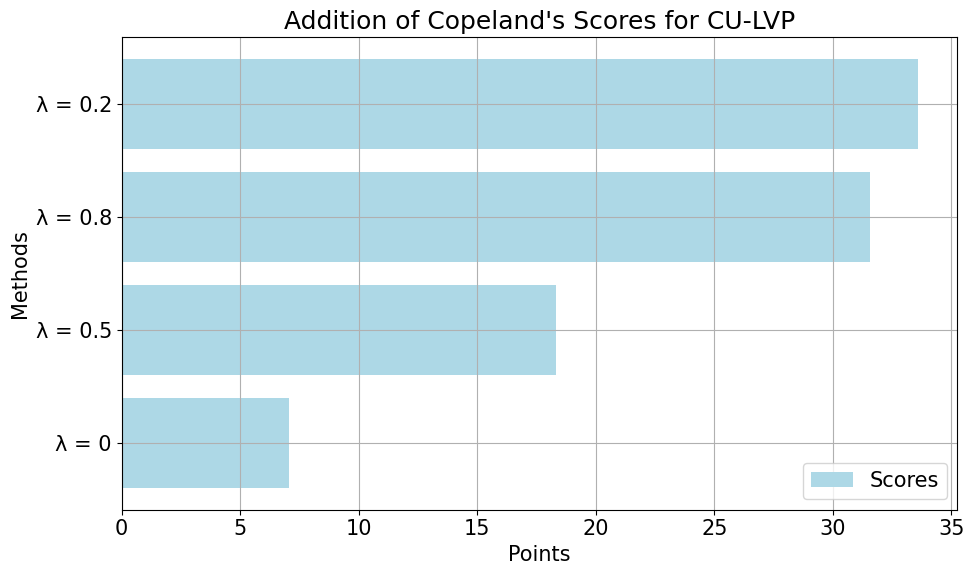

In [37]:
dimensions_list = ["15x15", "30x30", "50x50"]
scores = {}
for dimensions in dimensions_list:
    file_dict = {
                'λ = 0.8': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0.8/{dimensions}/new_cu_diffgoal_path_0.8_{dimensions}_True_2_100.xlsx',
                'λ = 0.5': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0.5/{dimensions}/new_cu_diffgoal_path_0.5_{dimensions}_True_2_100.xlsx',
                'λ = 0.2': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0.2/{dimensions}/new_cu_diffgoal_path_0.2_{dimensions}_True_2_100.xlsx',
                'λ = 0': f'results_submaps/new_cu_diffgoal_path_0.2/lambda_comps/experiments/new_cu_diffgoal_path_0/{dimensions}/new_cu_diffgoal_path_0_{dimensions}_True_2_100.xlsx',}    

    scores = find_best_along_copeland(file_dict, ['Avg_Total_Rounds', 'Avg_Experiment_Time', 'Avg_Expl_Cost', 'Avg_Comm_Cost', 'Avg_Expl_Eff'], ['Avg_Expl_Eff'], scores)

scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
methods_all = list(scores.keys())
values_all = list(scores.values())
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 15})
plt.barh(methods_all, values_all, color='lightblue', label='Scores')
plt.title("Addition of Copeland's Scores for CU-LVP")
plt.xlabel('Points')
plt.ylabel('Methods')
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



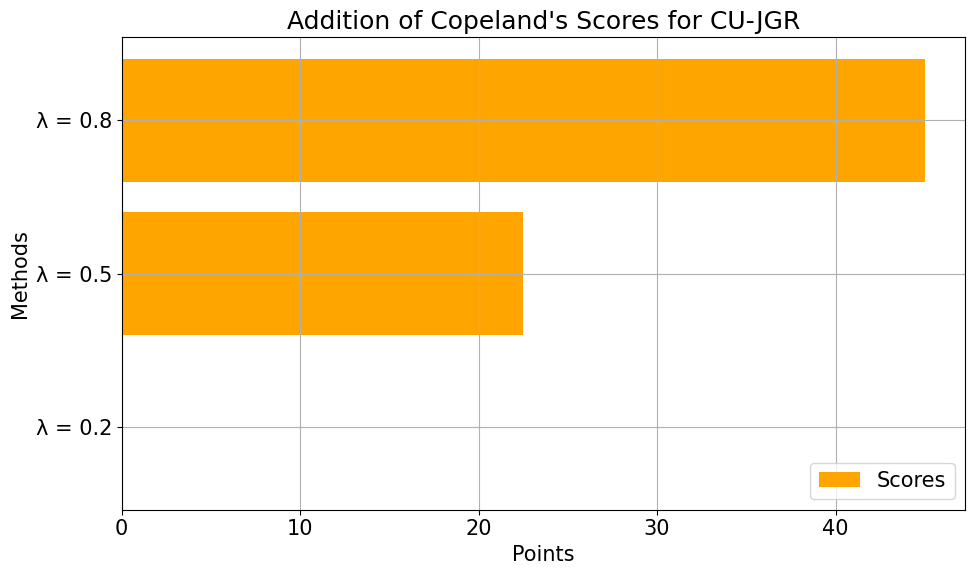

In [38]:
dimensions_list = ["15x15", "30x30", "50x50"]
scores = {}

for dimensions in dimensions_list:
    file_dict = {
                'λ = 0.8': f'results_submaps/cu_jgr/lambda_comps/experiments/cu_jgr_0.8/{dimensions}/cu_jgr_0.8_{dimensions}_True_2_100.xlsx',
                'λ = 0.5': f'results_submaps/cu_jgr/lambda_comps/experiments/cu_jgr_0.5/{dimensions}/cu_jgr_0.5_{dimensions}_True_2_100.xlsx',
                'λ = 0.2': f'results_submaps/cu_jgr/lambda_comps/experiments/cu_jgr_0.2/{dimensions}/cu_jgr_0.2_{dimensions}_True_2_100.xlsx'}

    scores = find_best_along_copeland(file_dict, ['Avg_Total_Rounds', 'Avg_Experiment_Time', 'Avg_Expl_Cost', 'Avg_Comm_Cost', 'Avg_Expl_Eff'], ['Avg_Expl_Eff'], scores)


scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
methods_all = list(scores.keys())
values_all = list(scores.values())
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 15})
plt.barh(methods_all, values_all, color='orange', label='Scores')
plt.title("Addition of Copeland's Scores for CU-JGR")
plt.xlabel('Points')
plt.ylabel('Methods')
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

